In [80]:
import os
import pandas as pd
import numpy as np
from skimage.measure import block_reduce
import time
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

autotune = tf.data.AUTOTUNE

In [81]:
image_sizes = {
    "cryptopunks": (32, 32),
    "cryptocorgis": (32, 32)
    }
batch_size = 32

In [82]:
def get_data(collection):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./%s"%collection,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_sizes[collection],
        #batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./%s"%collection,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_sizes[collection],
        #batch_size=batch_size,
    )
    return train_ds, val_ds


train_ds, val_ds = get_data("cryptopunks")

#Try removing this as well 
def process(image,label):
    #image = tf.cast((image - 127.5)/127.5 ,tf.float32)
    return image,label

train_ds = train_ds.map(process)

Found 9999 files belonging to 1 classes.
Using 8000 files for training.
Found 9999 files belonging to 1 classes.
Using 1999 files for validation.


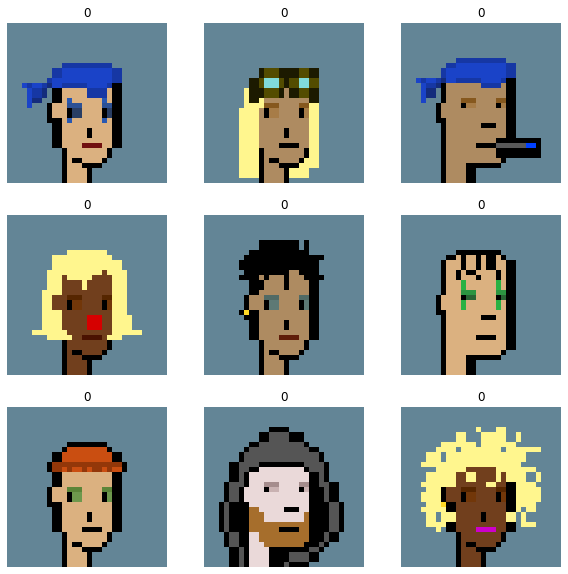

In [83]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy()).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [84]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [85]:
train_ds2, val_ds2 = get_data("cryptocorgis")

train_ds2 = train_ds2.map(process)

Found 8273 files belonging to 1 classes.
Using 6619 files for training.
Found 8273 files belonging to 1 classes.
Using 1654 files for validation.


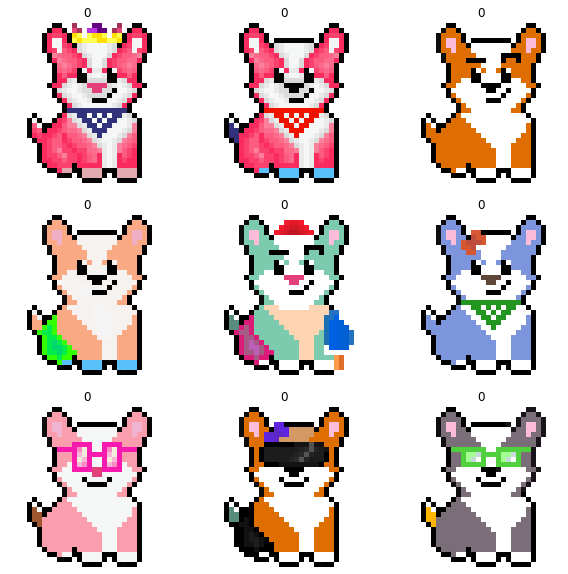

In [86]:
plt.figure(figsize=(10, 10))
for images2, labels2 in train_ds2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images2[i].numpy()).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [87]:
train_ds2 = train_ds2.prefetch(buffer_size=32)
val_ds2 = val_ds2.prefetch(buffer_size=32)

In [88]:
# Define the standard image size.
orig_img_size = (32, 32)

# Size of the random crops to be used during training.
input_img_size = (32, 32, 3)

# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Define buffer and batch sizes
buffer_size = 256
batch_size = 1


def normalize_img(img):
    #img = tf.cast(img, dtype=tf.uint8)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

# This function is used to add variety to the dataset by randomly flipping and cropping the image
def preprocess_train_image_ds(img, labels_we_dont_care_about_nor_have):
    image = tf.cast(img, tf.float32)
    
    # Random flip
    image = tf.image.random_flip_left_right(image)

    # Resize to the original size first(1,256, 256, 3)
    image = tf.image.resize(image, [32,32])

    # Random crop to 256X256
    image = tf.image.random_crop(image, [1,32,32,3])

    # Normalize the pixel values in the range [-1, 1]
    image = normalize_img(image)

    # Reshape the image to a 32x32 RGB 
    image = tf.reshape(image,[32,32,3])
    return image


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

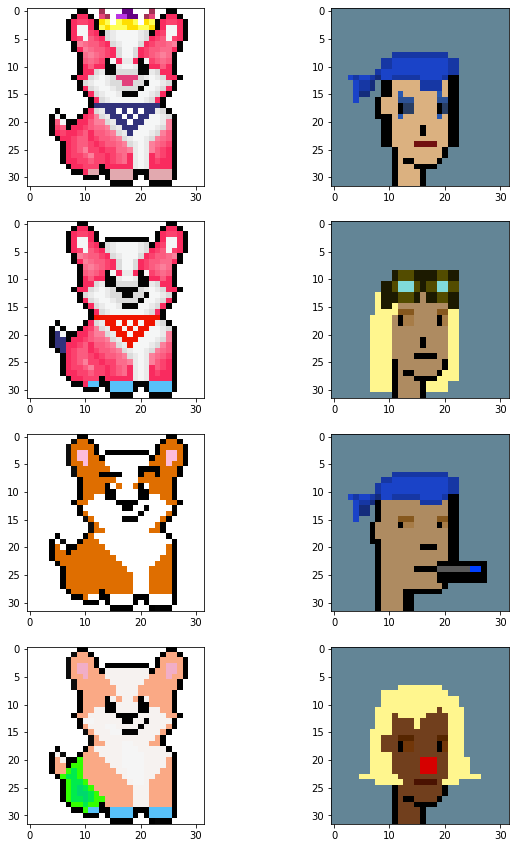

In [89]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_ds2.take(4), train_ds.take(4))):

    corgi = (images2[i].numpy()).astype("uint8")
    punk = (images[i].numpy()).astype("uint8")
    ax[i, 0].imshow(corgi)
    ax[i, 1].imshow(punk)
plt.show()

In [90]:
# Apply the preprocessing operations to the training data
train_ds = (
    train_ds.map(preprocess_train_image_ds, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)

)

In [91]:
train_ds2 = (
    train_ds2.map(preprocess_train_image_ds, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)

)

In [92]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [93]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [94]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [95]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [96]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(train_ds2.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "./generated_images_200/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

In [97]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

Epoch 1/200
207/207 [==============================] - ETA: 0s - G_loss: 5.4177 - F_loss: 8.2293 - D_X_loss: 0.0554 - D_Y_loss: 0.0640

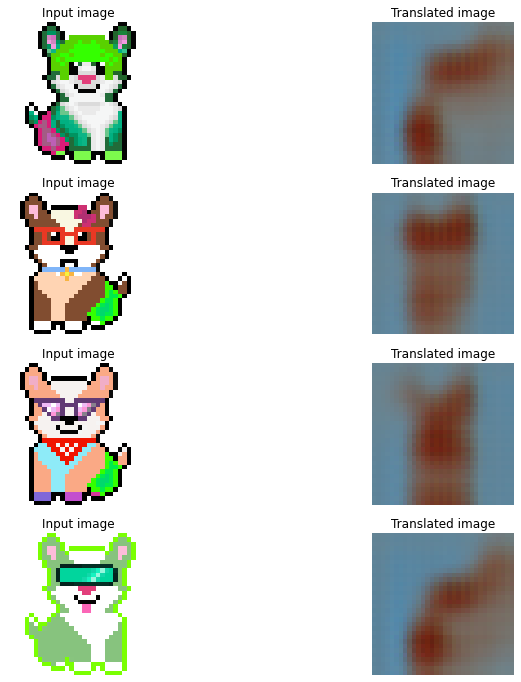

207/207 [==============================] - 180s 581ms/step - G_loss: 5.4104 - F_loss: 8.2146 - D_X_loss: 0.0551 - D_Y_loss: 0.0637
Epoch 2/200
207/207 [==============================] - ETA: 0s - G_loss: 5.0786 - F_loss: 6.7776 - D_X_loss: 3.1492e-04 - D_Y_loss: 0.0193

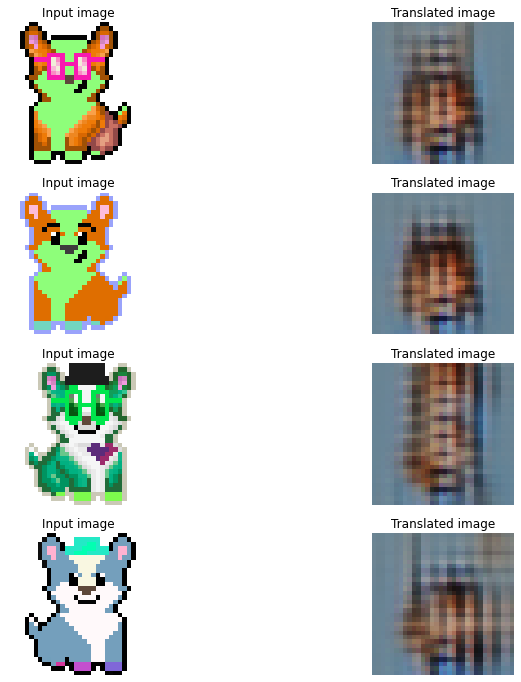

207/207 [==============================] - 120s 581ms/step - G_loss: 5.0763 - F_loss: 6.7804 - D_X_loss: 3.1407e-04 - D_Y_loss: 0.0192
Epoch 3/200
207/207 [==============================] - ETA: 0s - G_loss: 4.6214 - F_loss: 6.6436 - D_X_loss: 1.7768e-04 - D_Y_loss: 0.0921

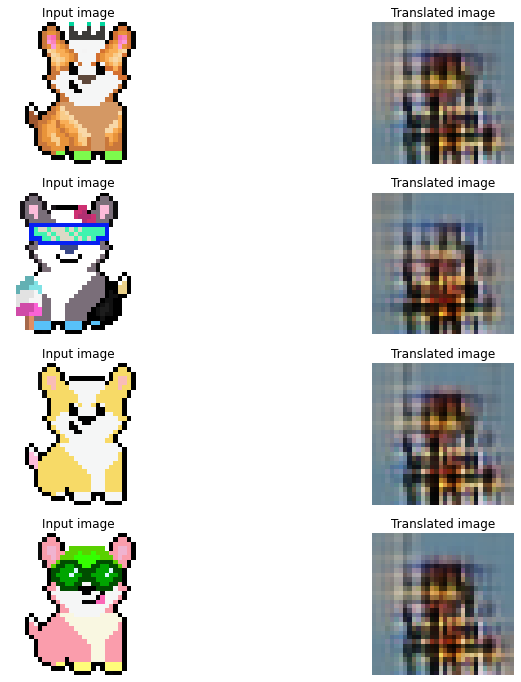

207/207 [==============================] - 120s 581ms/step - G_loss: 4.6163 - F_loss: 6.6438 - D_X_loss: 1.7699e-04 - D_Y_loss: 0.0925
Epoch 4/200
207/207 [==============================] - ETA: 0s - G_loss: 4.2442 - F_loss: 6.5517 - D_X_loss: 1.1061e-04 - D_Y_loss: 0.1324

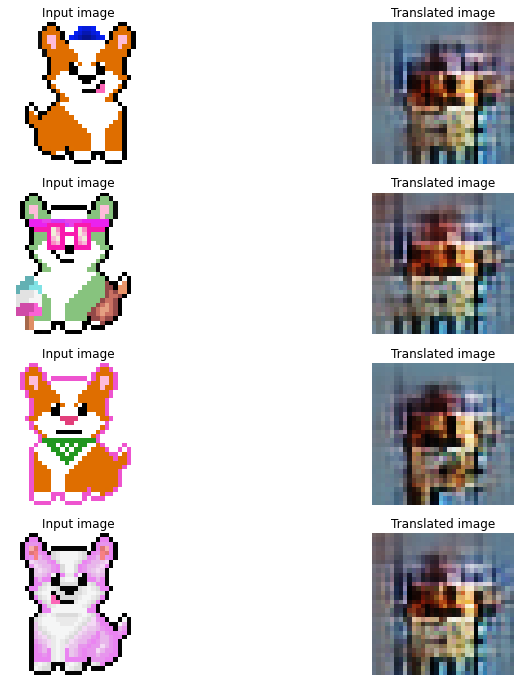

207/207 [==============================] - 120s 579ms/step - G_loss: 4.2475 - F_loss: 6.5591 - D_X_loss: 1.1040e-04 - D_Y_loss: 0.1323
Epoch 5/200
207/207 [==============================] - ETA: 0s - G_loss: 3.9348 - F_loss: 6.5165 - D_X_loss: 0.0017 - D_Y_loss: 0.1388

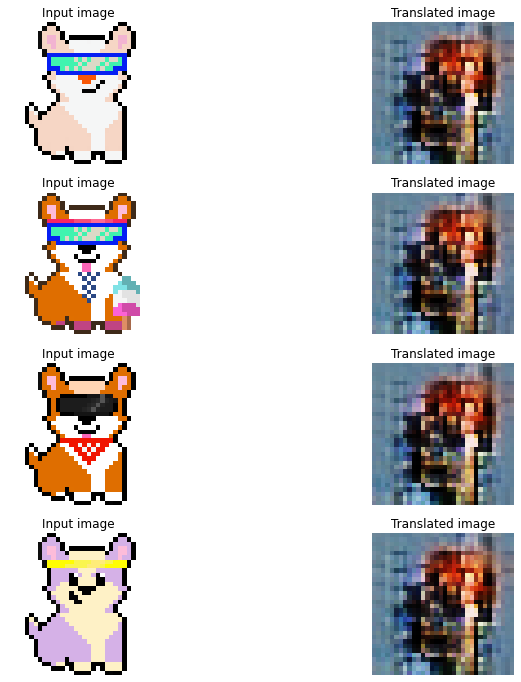

207/207 [==============================] - 120s 578ms/step - G_loss: 3.9450 - F_loss: 6.5155 - D_X_loss: 0.0017 - D_Y_loss: 0.1399
Epoch 6/200
207/207 [==============================] - ETA: 0s - G_loss: 3.9169 - F_loss: 6.4937 - D_X_loss: 0.0108 - D_Y_loss: 0.1390

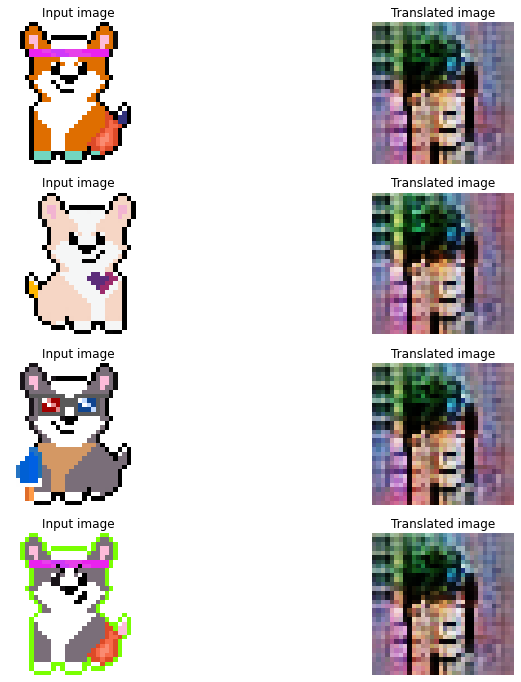

207/207 [==============================] - 119s 575ms/step - G_loss: 3.9140 - F_loss: 6.4873 - D_X_loss: 0.0109 - D_Y_loss: 0.1400
Epoch 7/200
207/207 [==============================] - ETA: 0s - G_loss: 4.0757 - F_loss: 6.1555 - D_X_loss: 0.0571 - D_Y_loss: 0.1111

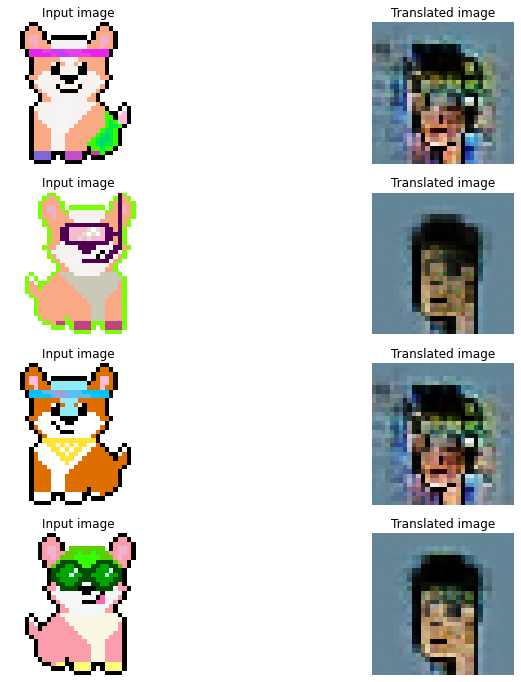

207/207 [==============================] - 119s 575ms/step - G_loss: 4.0686 - F_loss: 6.1523 - D_X_loss: 0.0568 - D_Y_loss: 0.1107
Epoch 8/200
207/207 [==============================] - ETA: 0s - G_loss: 4.0469 - F_loss: 4.9761 - D_X_loss: 0.1200 - D_Y_loss: 0.1204

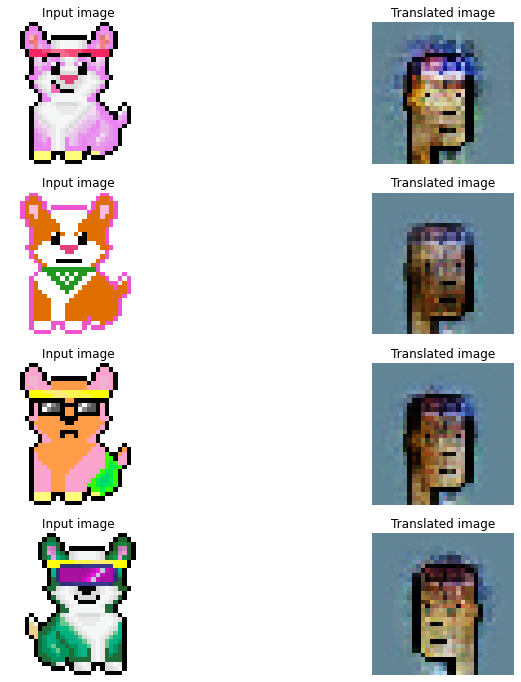

207/207 [==============================] - 119s 576ms/step - G_loss: 4.0475 - F_loss: 4.9754 - D_X_loss: 0.1210 - D_Y_loss: 0.1215
Epoch 9/200
207/207 [==============================] - ETA: 0s - G_loss: 3.9608 - F_loss: 4.1676 - D_X_loss: 0.1655 - D_Y_loss: 0.0897

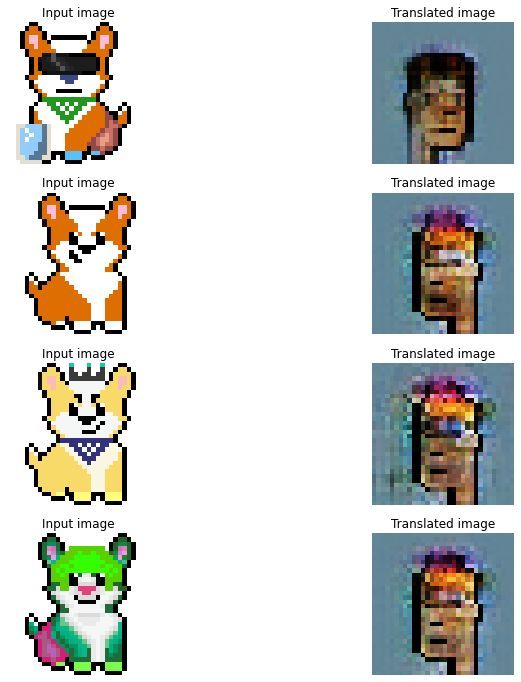

207/207 [==============================] - 120s 581ms/step - G_loss: 3.9620 - F_loss: 4.1767 - D_X_loss: 0.1650 - D_Y_loss: 0.0894
Epoch 10/200
207/207 [==============================] - ETA: 0s - G_loss: 4.0324 - F_loss: 4.0411 - D_X_loss: 0.1790 - D_Y_loss: 0.0907

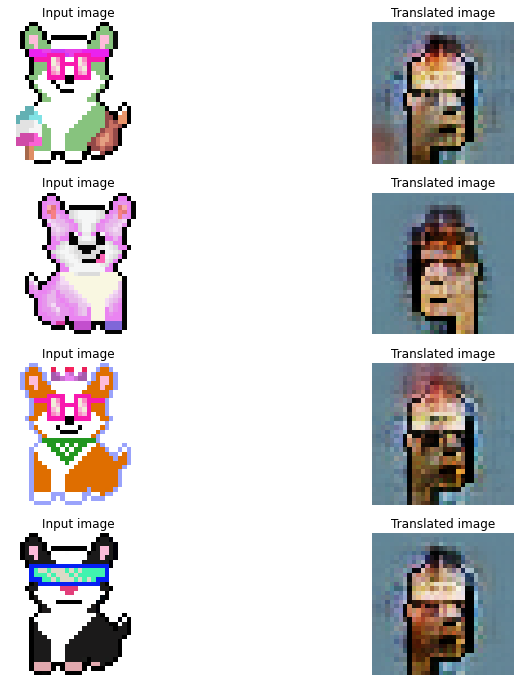

207/207 [==============================] - 120s 580ms/step - G_loss: 4.0228 - F_loss: 4.0338 - D_X_loss: 0.1784 - D_Y_loss: 0.0907
Epoch 11/200
207/207 [==============================] - ETA: 0s - G_loss: 3.9427 - F_loss: 3.9561 - D_X_loss: 0.1570 - D_Y_loss: 0.0801

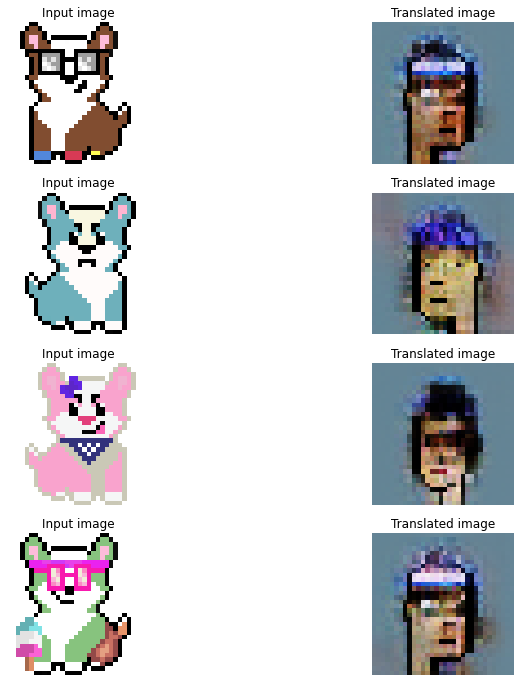

207/207 [==============================] - 120s 578ms/step - G_loss: 3.9556 - F_loss: 3.9474 - D_X_loss: 0.1573 - D_Y_loss: 0.0798
Epoch 12/200
207/207 [==============================] - ETA: 0s - G_loss: 3.7765 - F_loss: 3.9649 - D_X_loss: 0.1515 - D_Y_loss: 0.0895

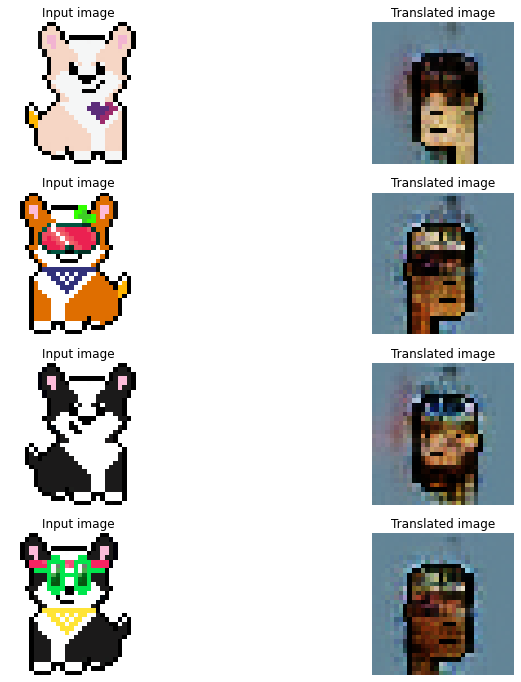

207/207 [==============================] - 119s 577ms/step - G_loss: 3.7712 - F_loss: 3.9615 - D_X_loss: 0.1520 - D_Y_loss: 0.0895
Epoch 13/200
207/207 [==============================] - ETA: 0s - G_loss: 3.8698 - F_loss: 3.8677 - D_X_loss: 0.1536 - D_Y_loss: 0.0853

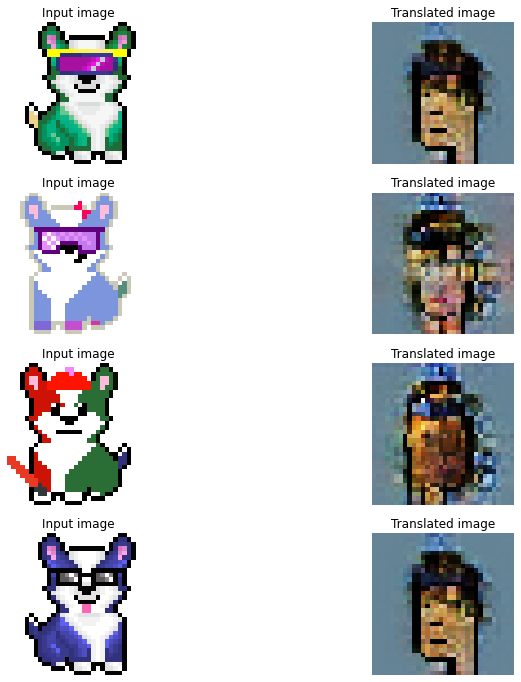

207/207 [==============================] - 119s 576ms/step - G_loss: 3.8649 - F_loss: 3.8697 - D_X_loss: 0.1530 - D_Y_loss: 0.0865
Epoch 14/200
207/207 [==============================] - ETA: 0s - G_loss: 3.7396 - F_loss: 3.8842 - D_X_loss: 0.1540 - D_Y_loss: 0.0756

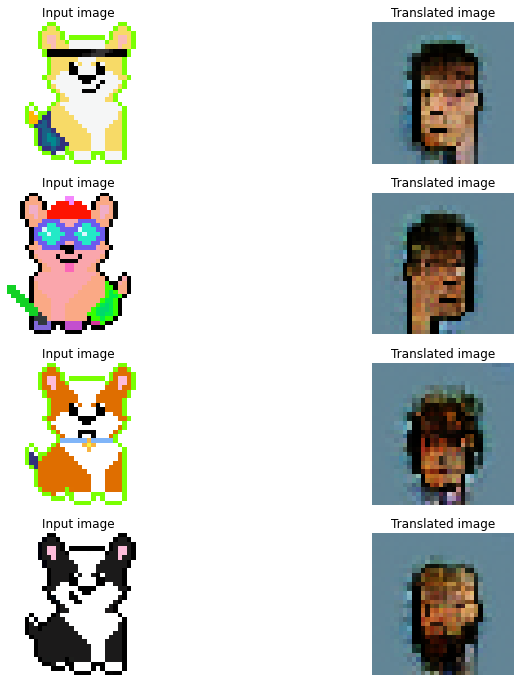

207/207 [==============================] - 119s 574ms/step - G_loss: 3.7373 - F_loss: 3.8806 - D_X_loss: 0.1541 - D_Y_loss: 0.0753
Epoch 15/200
207/207 [==============================] - ETA: 0s - G_loss: 3.7730 - F_loss: 3.8836 - D_X_loss: 0.1381 - D_Y_loss: 0.0782

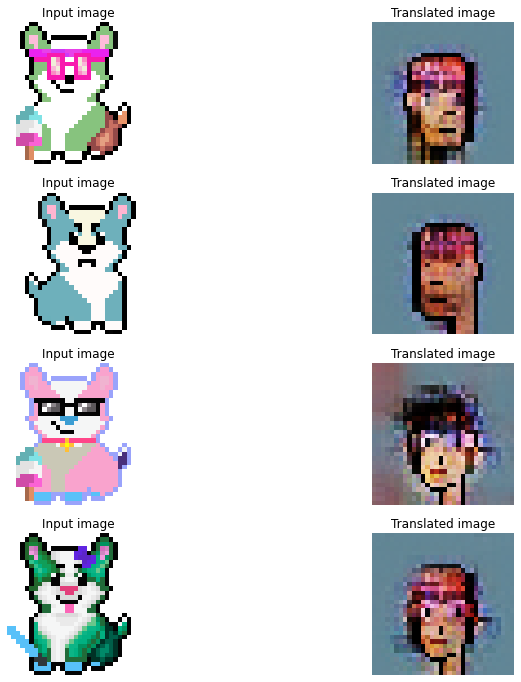

207/207 [==============================] - 119s 573ms/step - G_loss: 3.7807 - F_loss: 3.8780 - D_X_loss: 0.1390 - D_Y_loss: 0.0779
Epoch 16/200
207/207 [==============================] - ETA: 0s - G_loss: 3.7181 - F_loss: 3.9390 - D_X_loss: 0.1346 - D_Y_loss: 0.0848

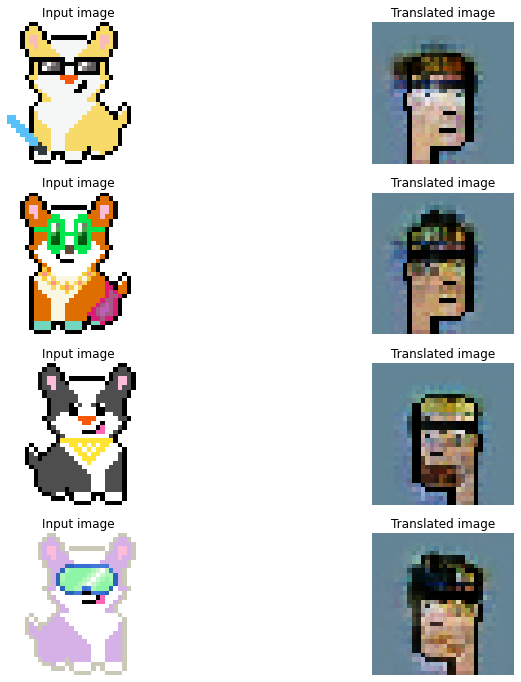

207/207 [==============================] - 119s 573ms/step - G_loss: 3.7178 - F_loss: 3.9490 - D_X_loss: 0.1344 - D_Y_loss: 0.0844
Epoch 17/200
207/207 [==============================] - ETA: 0s - G_loss: 3.6886 - F_loss: 3.7569 - D_X_loss: 0.1304 - D_Y_loss: 0.0660

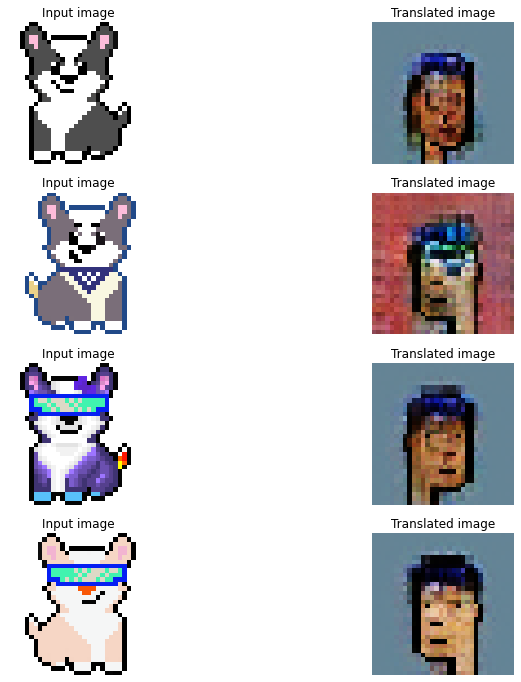

207/207 [==============================] - 118s 571ms/step - G_loss: 3.6924 - F_loss: 3.7565 - D_X_loss: 0.1299 - D_Y_loss: 0.0658
Epoch 18/200
207/207 [==============================] - ETA: 0s - G_loss: 3.6019 - F_loss: 3.8348 - D_X_loss: 0.1177 - D_Y_loss: 0.0795

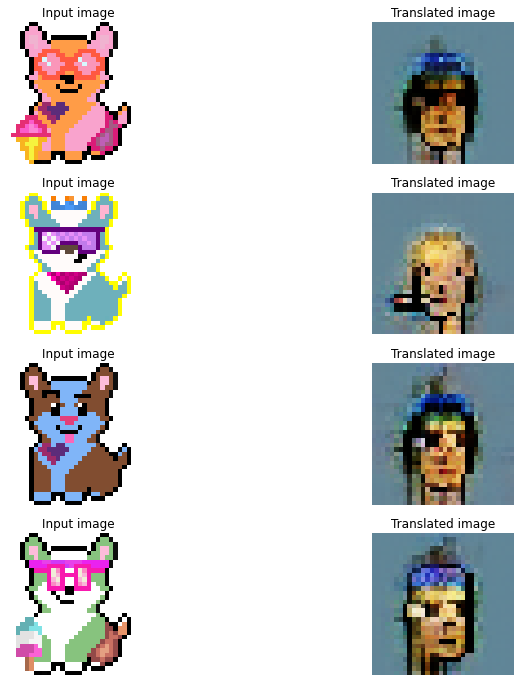

207/207 [==============================] - 118s 569ms/step - G_loss: 3.5973 - F_loss: 3.8427 - D_X_loss: 0.1173 - D_Y_loss: 0.0800
Epoch 19/200
207/207 [==============================] - ETA: 0s - G_loss: 3.5744 - F_loss: 3.7763 - D_X_loss: 0.1251 - D_Y_loss: 0.0721

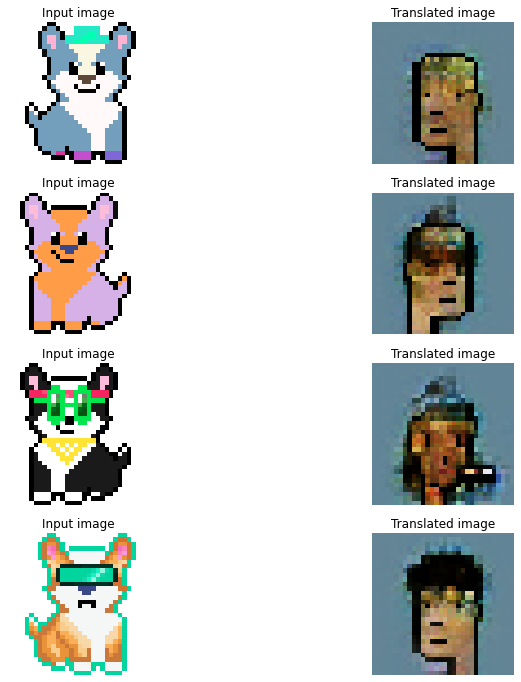

207/207 [==============================] - 118s 569ms/step - G_loss: 3.5691 - F_loss: 3.7800 - D_X_loss: 0.1248 - D_Y_loss: 0.0718
Epoch 20/200
207/207 [==============================] - ETA: 0s - G_loss: 3.6059 - F_loss: 3.7298 - D_X_loss: 0.1255 - D_Y_loss: 0.0668

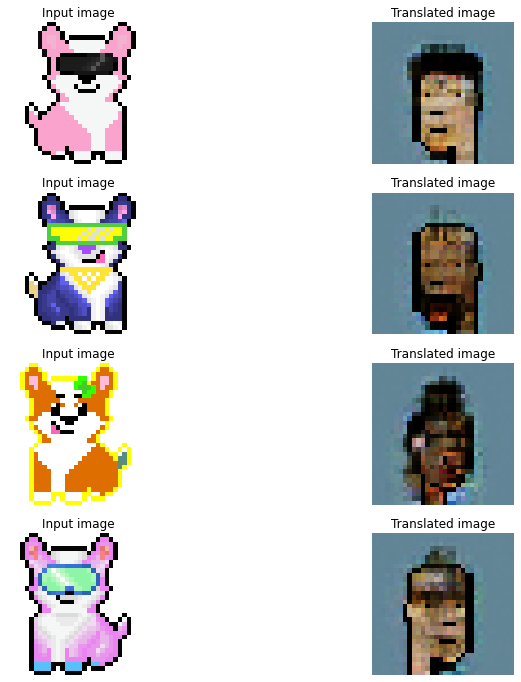

207/207 [==============================] - 117s 567ms/step - G_loss: 3.6132 - F_loss: 3.7221 - D_X_loss: 0.1264 - D_Y_loss: 0.0665
Epoch 21/200
207/207 [==============================] - ETA: 0s - G_loss: 3.6577 - F_loss: 3.5832 - D_X_loss: 0.1258 - D_Y_loss: 0.0672

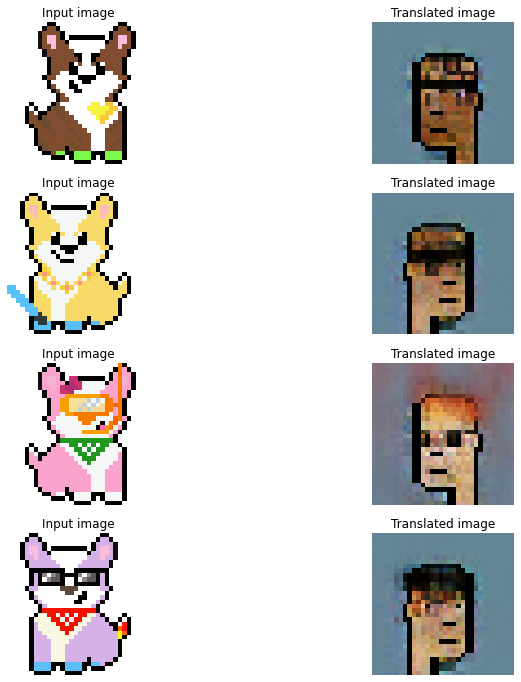

207/207 [==============================] - 117s 566ms/step - G_loss: 3.6551 - F_loss: 3.5838 - D_X_loss: 0.1253 - D_Y_loss: 0.0671
Epoch 22/200
207/207 [==============================] - ETA: 0s - G_loss: 3.4432 - F_loss: 3.6148 - D_X_loss: 0.1234 - D_Y_loss: 0.0758

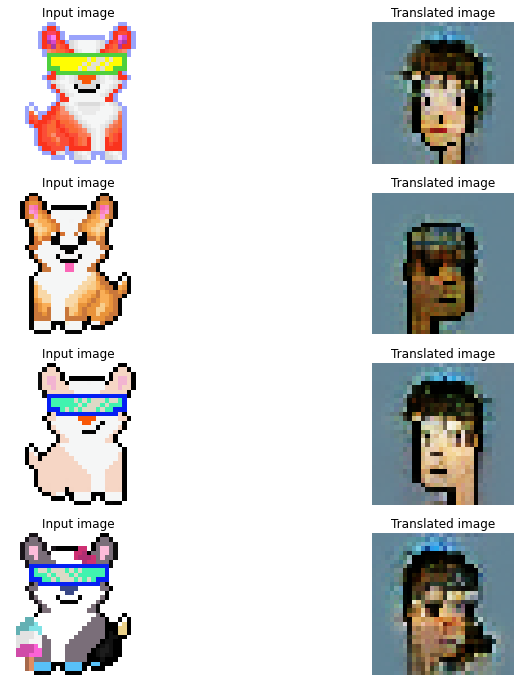

207/207 [==============================] - 117s 564ms/step - G_loss: 3.4566 - F_loss: 3.6116 - D_X_loss: 0.1230 - D_Y_loss: 0.0765
Epoch 23/200
207/207 [==============================] - ETA: 0s - G_loss: 3.5312 - F_loss: 3.5083 - D_X_loss: 0.1251 - D_Y_loss: 0.0620

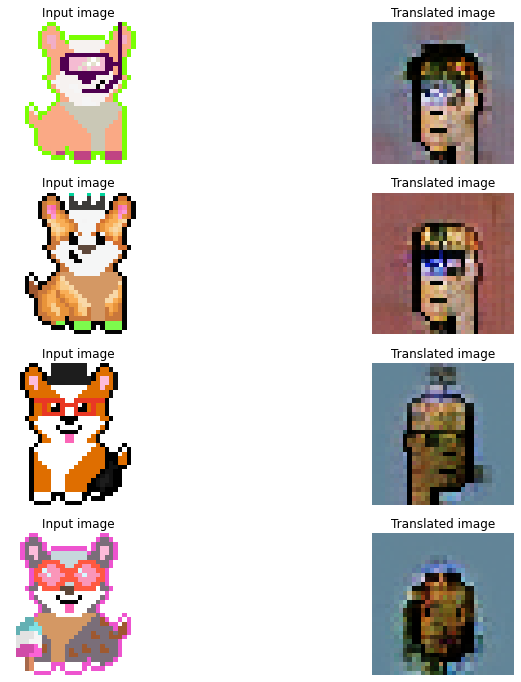

207/207 [==============================] - 116s 563ms/step - G_loss: 3.5294 - F_loss: 3.5123 - D_X_loss: 0.1246 - D_Y_loss: 0.0618
Epoch 24/200
207/207 [==============================] - ETA: 0s - G_loss: 3.5151 - F_loss: 3.4235 - D_X_loss: 0.1256 - D_Y_loss: 0.0530

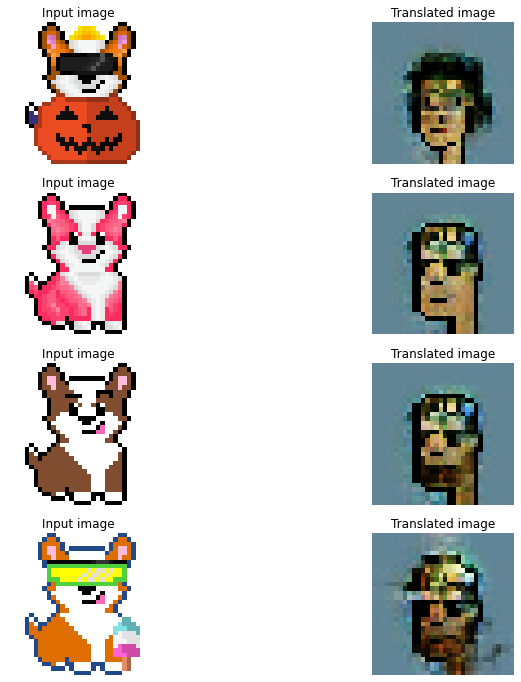

207/207 [==============================] - 119s 576ms/step - G_loss: 3.5301 - F_loss: 3.4164 - D_X_loss: 0.1258 - D_Y_loss: 0.0528
Epoch 25/200
207/207 [==============================] - ETA: 0s - G_loss: 3.5675 - F_loss: 3.3749 - D_X_loss: 0.1264 - D_Y_loss: 0.0534

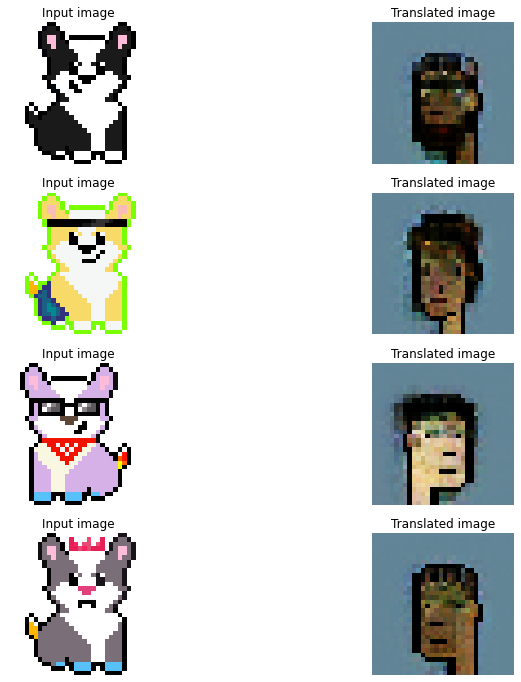

207/207 [==============================] - 120s 580ms/step - G_loss: 3.5737 - F_loss: 3.3696 - D_X_loss: 0.1266 - D_Y_loss: 0.0531
Epoch 26/200
207/207 [==============================] - ETA: 0s - G_loss: 3.4023 - F_loss: 3.4204 - D_X_loss: 0.1153 - D_Y_loss: 0.0633

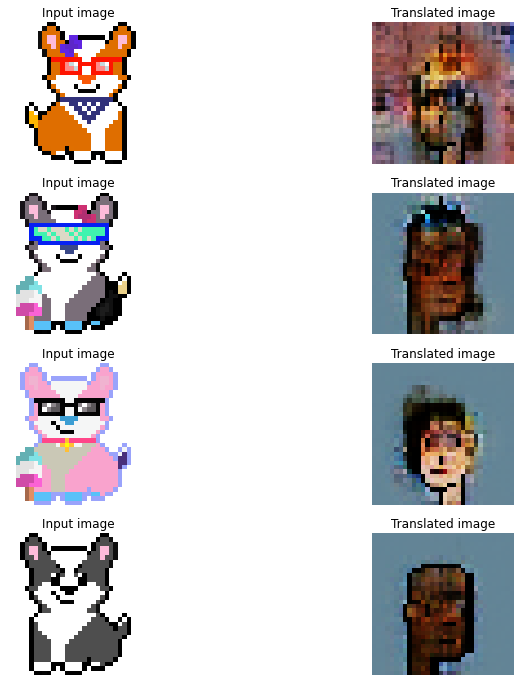

207/207 [==============================] - 117s 563ms/step - G_loss: 3.3964 - F_loss: 3.4198 - D_X_loss: 0.1149 - D_Y_loss: 0.0638
Epoch 27/200
207/207 [==============================] - ETA: 0s - G_loss: 3.2743 - F_loss: 3.3458 - D_X_loss: 0.1186 - D_Y_loss: 0.0613

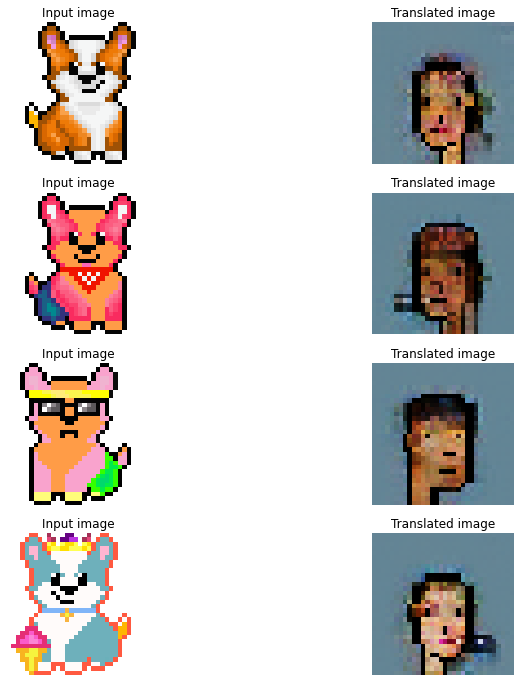

207/207 [==============================] - 116s 562ms/step - G_loss: 3.2680 - F_loss: 3.3415 - D_X_loss: 0.1196 - D_Y_loss: 0.0612
Epoch 28/200
207/207 [==============================] - ETA: 0s - G_loss: 3.3523 - F_loss: 3.3120 - D_X_loss: 0.1085 - D_Y_loss: 0.0692

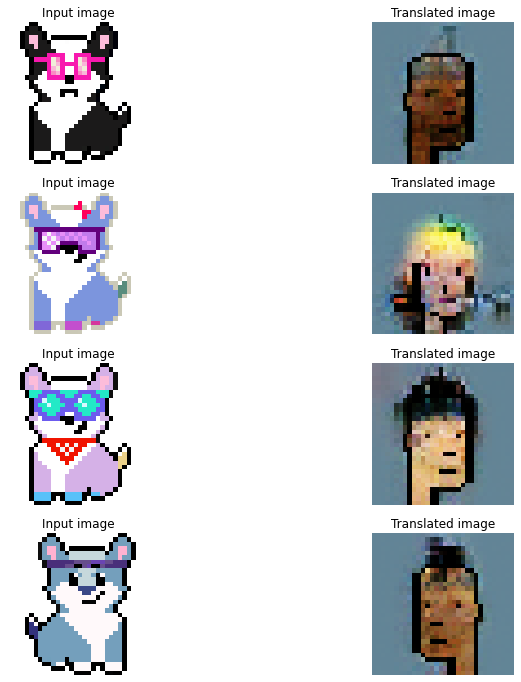

207/207 [==============================] - 116s 562ms/step - G_loss: 3.3612 - F_loss: 3.3075 - D_X_loss: 0.1080 - D_Y_loss: 0.0690
Epoch 29/200
207/207 [==============================] - ETA: 0s - G_loss: 3.3024 - F_loss: 3.2312 - D_X_loss: 0.1212 - D_Y_loss: 0.0638

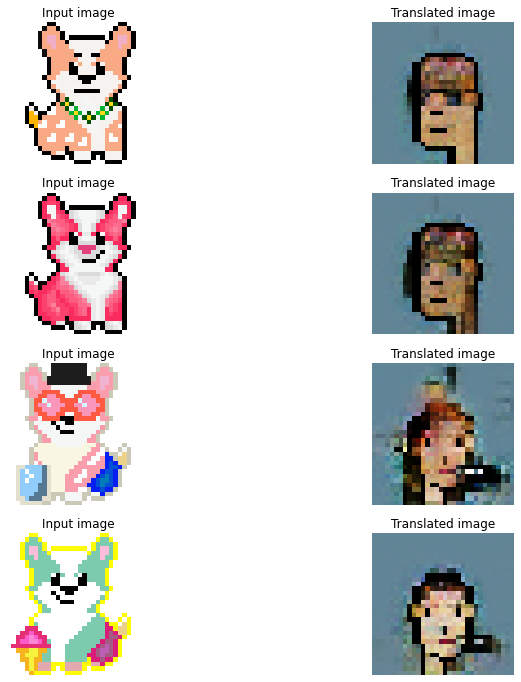

207/207 [==============================] - 116s 560ms/step - G_loss: 3.2979 - F_loss: 3.2336 - D_X_loss: 0.1209 - D_Y_loss: 0.0653
Epoch 30/200
207/207 [==============================] - ETA: 0s - G_loss: 3.2788 - F_loss: 3.1336 - D_X_loss: 0.1331 - D_Y_loss: 0.0693

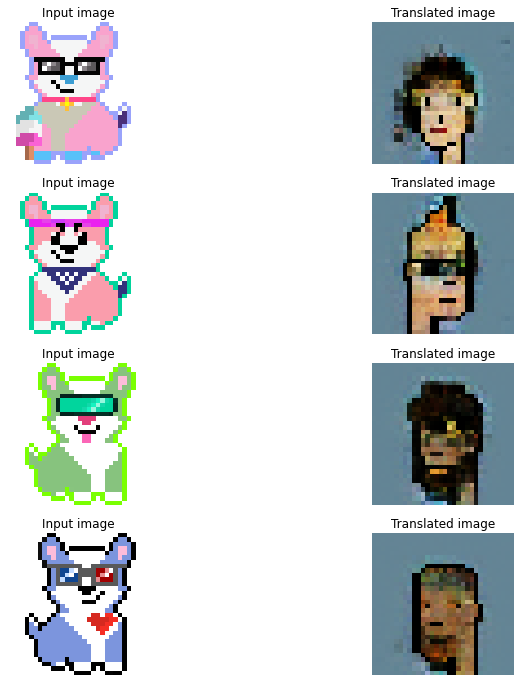

207/207 [==============================] - 116s 559ms/step - G_loss: 3.2727 - F_loss: 3.1318 - D_X_loss: 0.1327 - D_Y_loss: 0.0690
Epoch 31/200
207/207 [==============================] - ETA: 0s - G_loss: 3.0945 - F_loss: 3.2413 - D_X_loss: 0.1109 - D_Y_loss: 0.0858

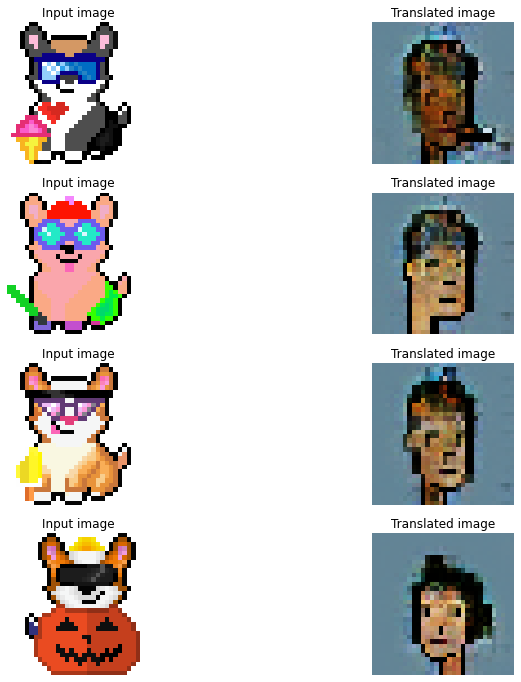

207/207 [==============================] - 115s 557ms/step - G_loss: 3.1062 - F_loss: 3.2414 - D_X_loss: 0.1106 - D_Y_loss: 0.0854
Epoch 32/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1289 - F_loss: 3.0632 - D_X_loss: 0.1270 - D_Y_loss: 0.0634

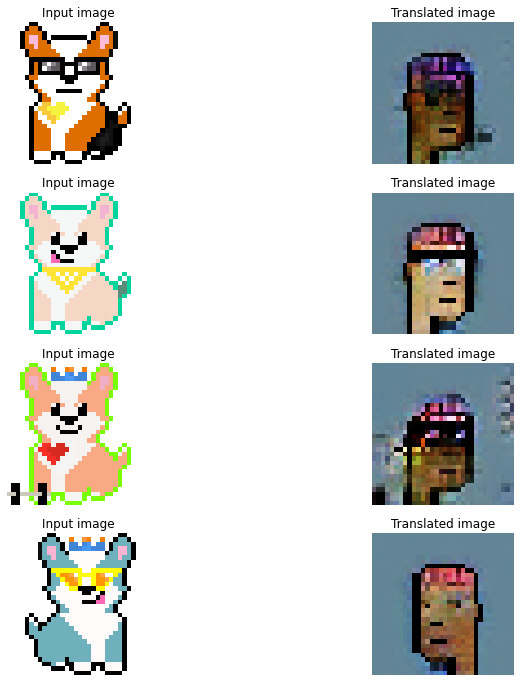

207/207 [==============================] - 115s 556ms/step - G_loss: 3.1292 - F_loss: 3.0588 - D_X_loss: 0.1275 - D_Y_loss: 0.0631
Epoch 33/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1681 - F_loss: 3.1324 - D_X_loss: 0.1104 - D_Y_loss: 0.0718

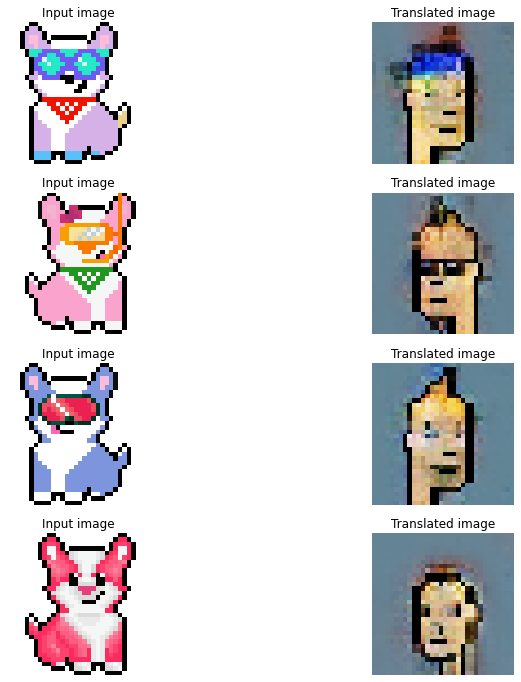

207/207 [==============================] - 115s 556ms/step - G_loss: 3.1710 - F_loss: 3.1467 - D_X_loss: 0.1102 - D_Y_loss: 0.0715
Epoch 34/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1429 - F_loss: 3.1129 - D_X_loss: 0.1194 - D_Y_loss: 0.0729

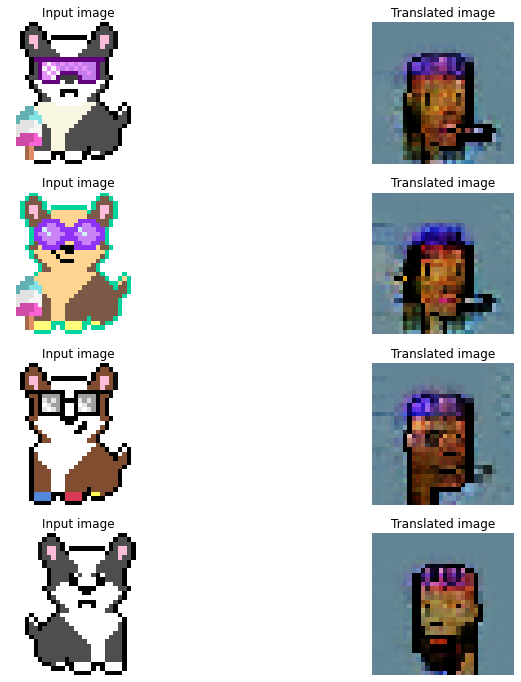

207/207 [==============================] - 115s 555ms/step - G_loss: 3.1410 - F_loss: 3.1151 - D_X_loss: 0.1189 - D_Y_loss: 0.0726
Epoch 35/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1299 - F_loss: 3.0358 - D_X_loss: 0.1178 - D_Y_loss: 0.0791

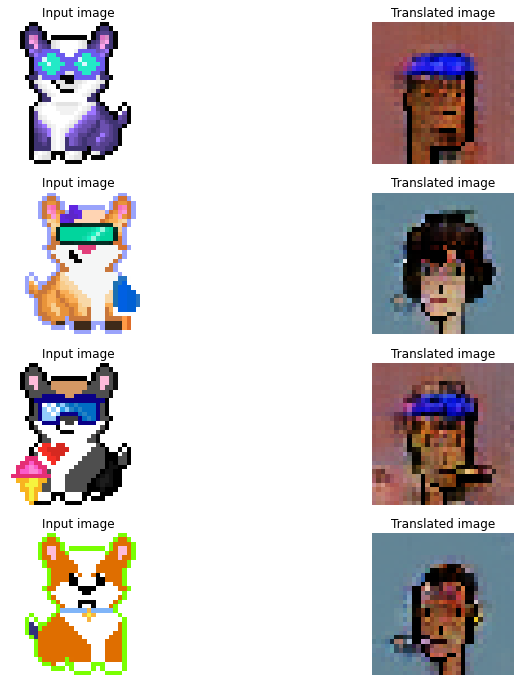

207/207 [==============================] - 115s 556ms/step - G_loss: 3.1263 - F_loss: 3.0367 - D_X_loss: 0.1173 - D_Y_loss: 0.0787
Epoch 36/200
207/207 [==============================] - ETA: 0s - G_loss: 3.2135 - F_loss: 3.0395 - D_X_loss: 0.1084 - D_Y_loss: 0.0732

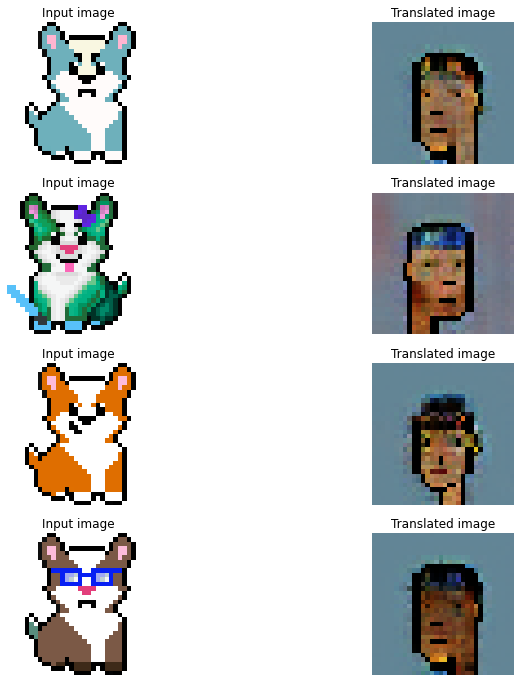

207/207 [==============================] - 116s 561ms/step - G_loss: 3.2115 - F_loss: 3.0375 - D_X_loss: 0.1083 - D_Y_loss: 0.0729
Epoch 37/200
207/207 [==============================] - ETA: 0s - G_loss: 3.1071 - F_loss: 3.0823 - D_X_loss: 0.1066 - D_Y_loss: 0.0731

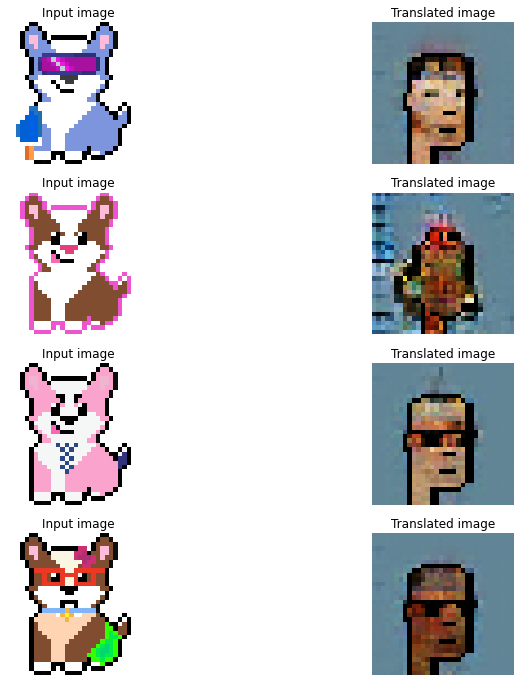

207/207 [==============================] - 122s 587ms/step - G_loss: 3.1063 - F_loss: 3.0873 - D_X_loss: 0.1061 - D_Y_loss: 0.0729
Epoch 38/200
207/207 [==============================] - ETA: 0s - G_loss: 3.0071 - F_loss: 3.1070 - D_X_loss: 0.0961 - D_Y_loss: 0.0696

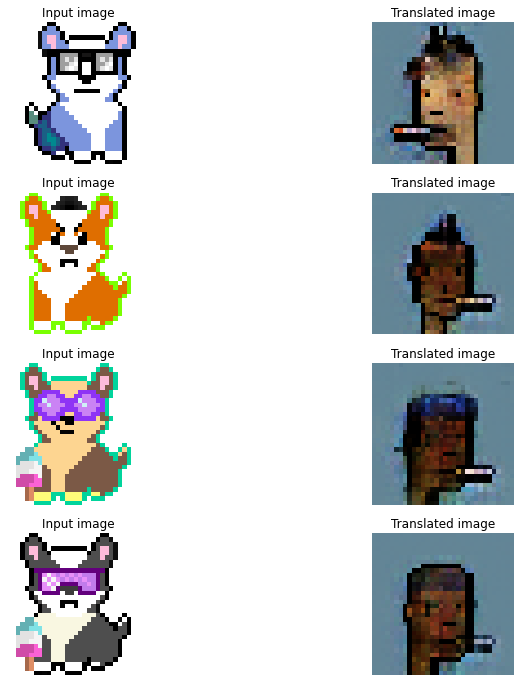

207/207 [==============================] - 121s 586ms/step - G_loss: 3.0039 - F_loss: 3.1046 - D_X_loss: 0.0959 - D_Y_loss: 0.0693
Epoch 39/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9747 - F_loss: 3.1317 - D_X_loss: 0.0982 - D_Y_loss: 0.0697

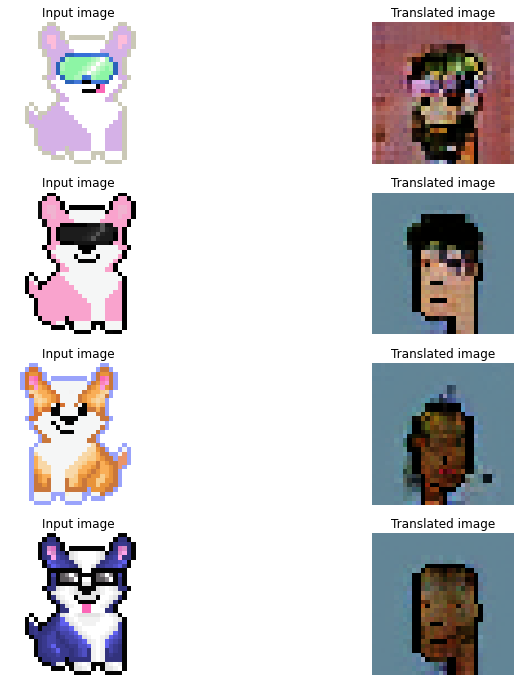

207/207 [==============================] - 121s 584ms/step - G_loss: 2.9711 - F_loss: 3.1252 - D_X_loss: 0.0983 - D_Y_loss: 0.0694
Epoch 40/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9903 - F_loss: 2.9765 - D_X_loss: 0.1027 - D_Y_loss: 0.0845

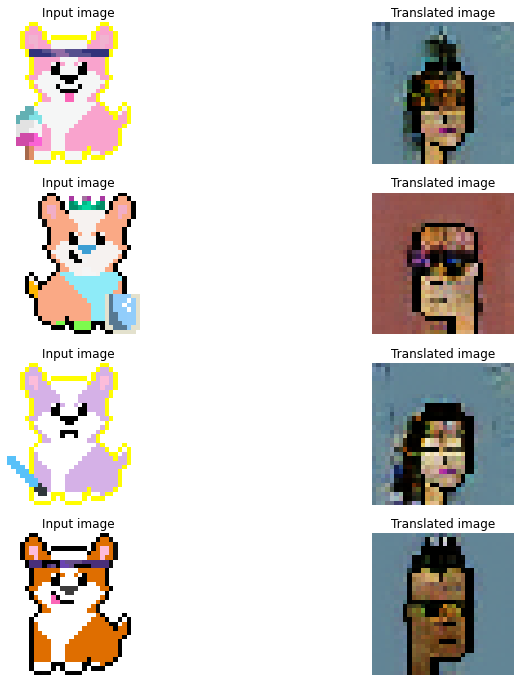

207/207 [==============================] - 121s 583ms/step - G_loss: 2.9903 - F_loss: 2.9749 - D_X_loss: 0.1022 - D_Y_loss: 0.0841
Epoch 41/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9295 - F_loss: 2.9809 - D_X_loss: 0.1040 - D_Y_loss: 0.0815

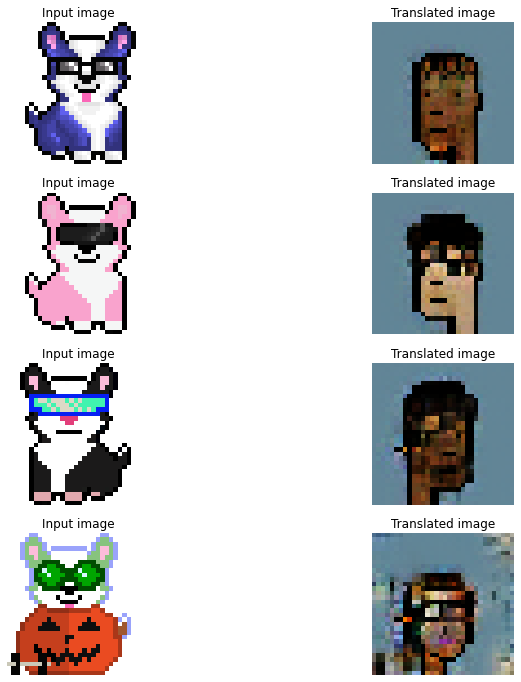

207/207 [==============================] - 120s 581ms/step - G_loss: 2.9403 - F_loss: 2.9819 - D_X_loss: 0.1036 - D_Y_loss: 0.0817
Epoch 42/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9845 - F_loss: 3.0104 - D_X_loss: 0.1024 - D_Y_loss: 0.0858

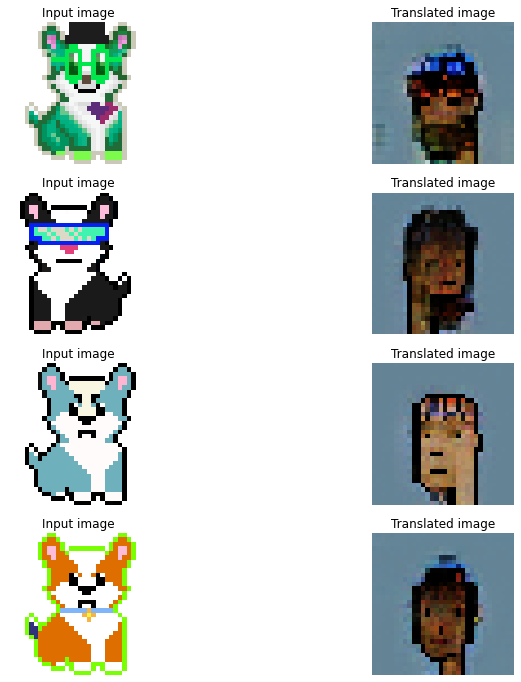

207/207 [==============================] - 120s 581ms/step - G_loss: 2.9785 - F_loss: 3.0094 - D_X_loss: 0.1026 - D_Y_loss: 0.0856
Epoch 43/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9748 - F_loss: 3.0022 - D_X_loss: 0.0945 - D_Y_loss: 0.0611

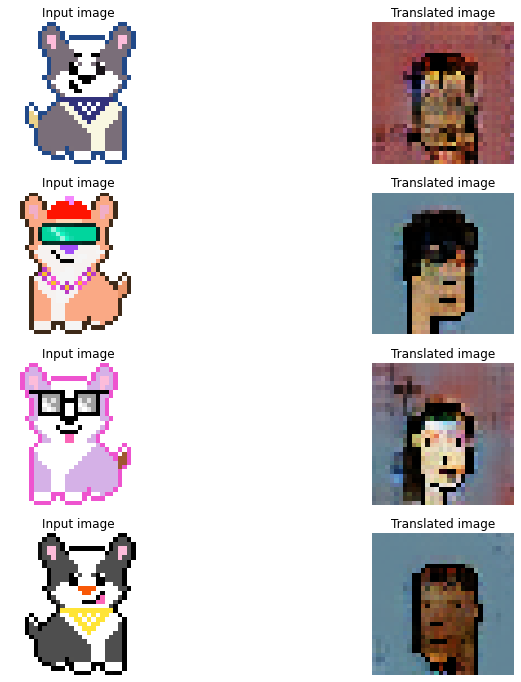

207/207 [==============================] - 120s 579ms/step - G_loss: 2.9723 - F_loss: 2.9983 - D_X_loss: 0.0943 - D_Y_loss: 0.0608
Epoch 44/200
207/207 [==============================] - ETA: 0s - G_loss: 3.0607 - F_loss: 2.9826 - D_X_loss: 0.1006 - D_Y_loss: 0.0686

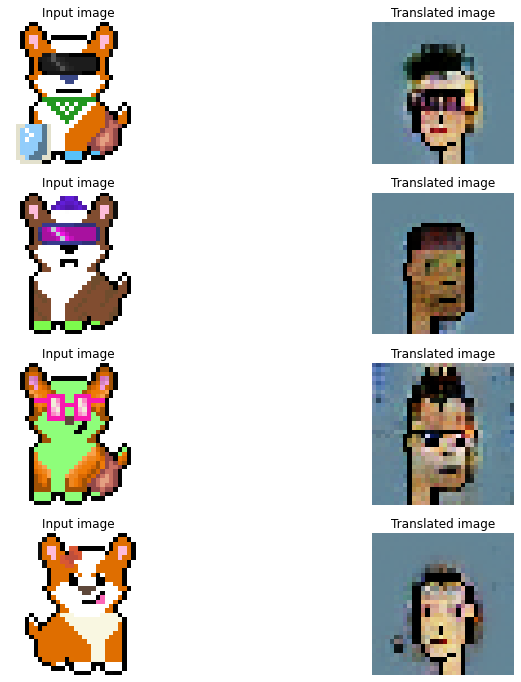

207/207 [==============================] - 120s 577ms/step - G_loss: 3.0575 - F_loss: 2.9796 - D_X_loss: 0.1007 - D_Y_loss: 0.0683
Epoch 45/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8134 - F_loss: 2.9399 - D_X_loss: 0.1043 - D_Y_loss: 0.0784

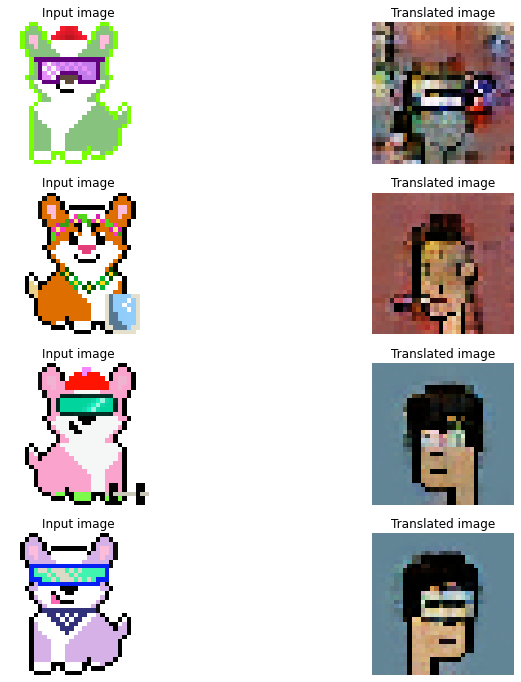

207/207 [==============================] - 119s 576ms/step - G_loss: 2.8107 - F_loss: 2.9387 - D_X_loss: 0.1044 - D_Y_loss: 0.0783
Epoch 46/200
207/207 [==============================] - ETA: 0s - G_loss: 2.9886 - F_loss: 2.9317 - D_X_loss: 0.1044 - D_Y_loss: 0.0720

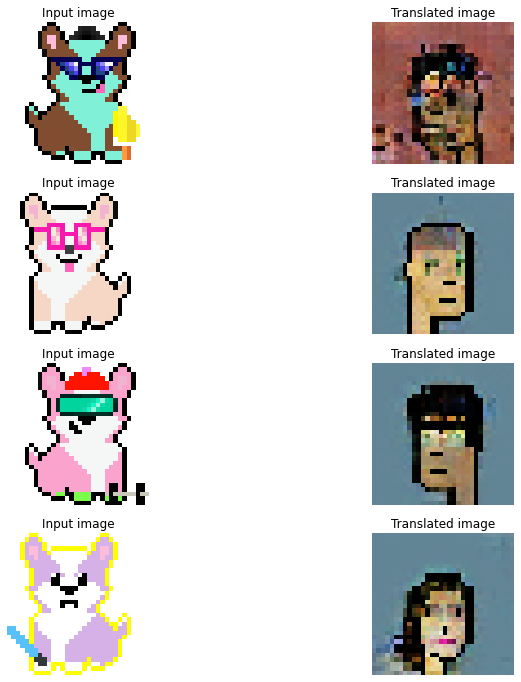

207/207 [==============================] - 119s 575ms/step - G_loss: 2.9869 - F_loss: 2.9328 - D_X_loss: 0.1040 - D_Y_loss: 0.0716
Epoch 47/200
207/207 [==============================] - ETA: 0s - G_loss: 3.0380 - F_loss: 2.8746 - D_X_loss: 0.1048 - D_Y_loss: 0.0649

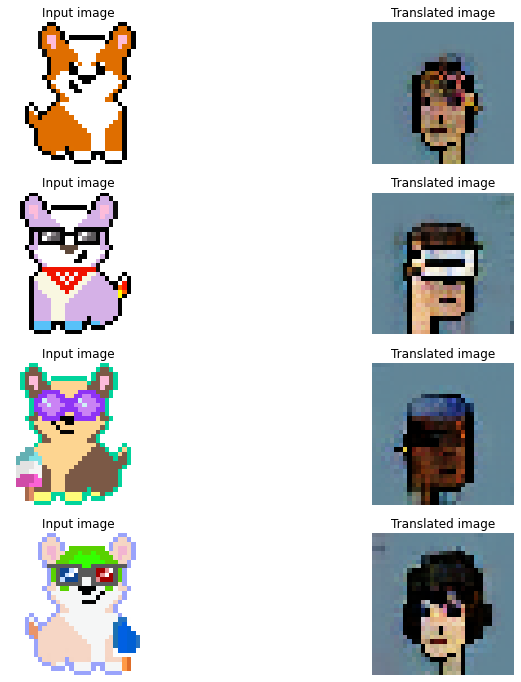

207/207 [==============================] - 119s 574ms/step - G_loss: 3.0320 - F_loss: 2.8739 - D_X_loss: 0.1047 - D_Y_loss: 0.0661
Epoch 48/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8738 - F_loss: 2.8611 - D_X_loss: 0.0970 - D_Y_loss: 0.0928

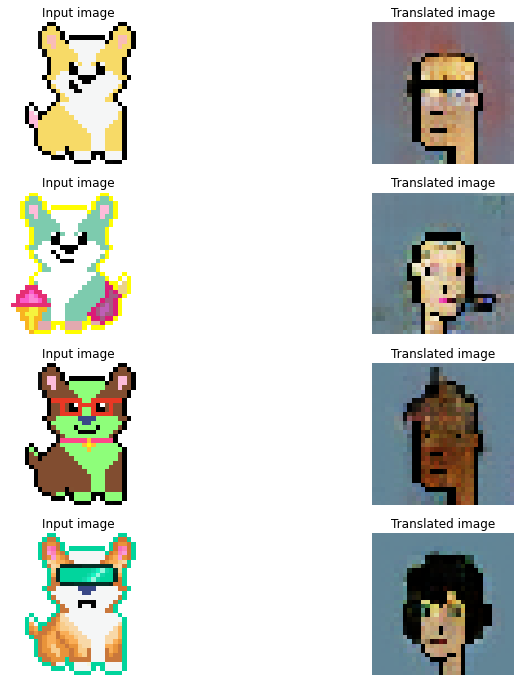

207/207 [==============================] - 119s 573ms/step - G_loss: 2.8680 - F_loss: 2.8616 - D_X_loss: 0.0967 - D_Y_loss: 0.0941
Epoch 49/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7589 - F_loss: 2.8109 - D_X_loss: 0.1018 - D_Y_loss: 0.0795

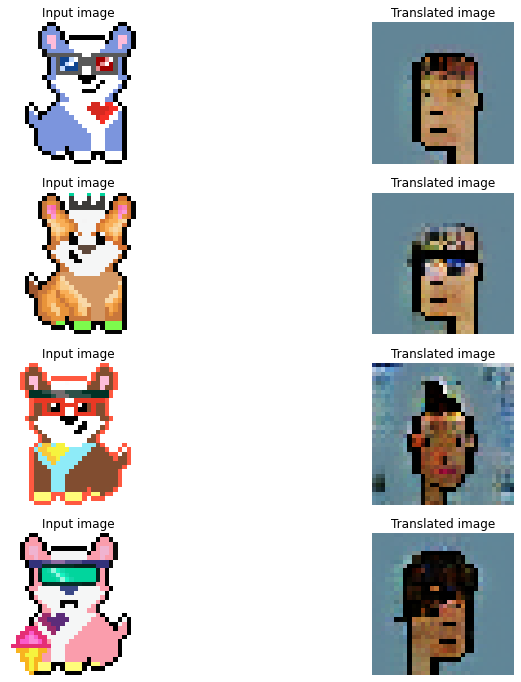

207/207 [==============================] - 119s 573ms/step - G_loss: 2.7640 - F_loss: 2.8139 - D_X_loss: 0.1022 - D_Y_loss: 0.0792
Epoch 50/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7459 - F_loss: 2.8428 - D_X_loss: 0.1016 - D_Y_loss: 0.0883

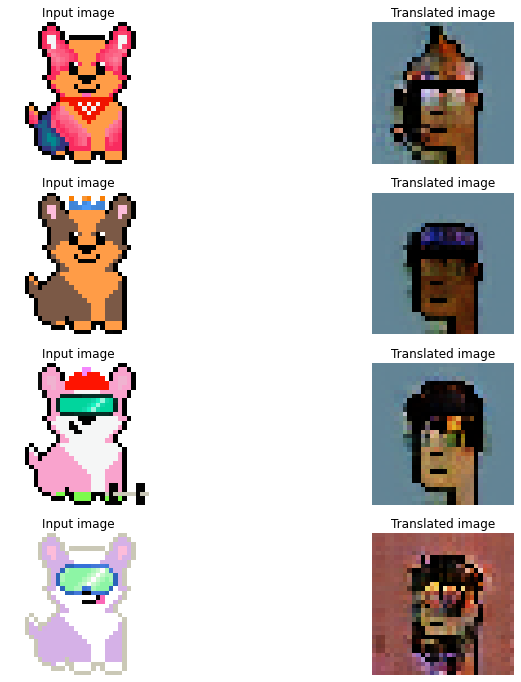

207/207 [==============================] - 118s 571ms/step - G_loss: 2.7587 - F_loss: 2.8448 - D_X_loss: 0.1014 - D_Y_loss: 0.0883
Epoch 51/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7731 - F_loss: 2.8590 - D_X_loss: 0.1073 - D_Y_loss: 0.0874

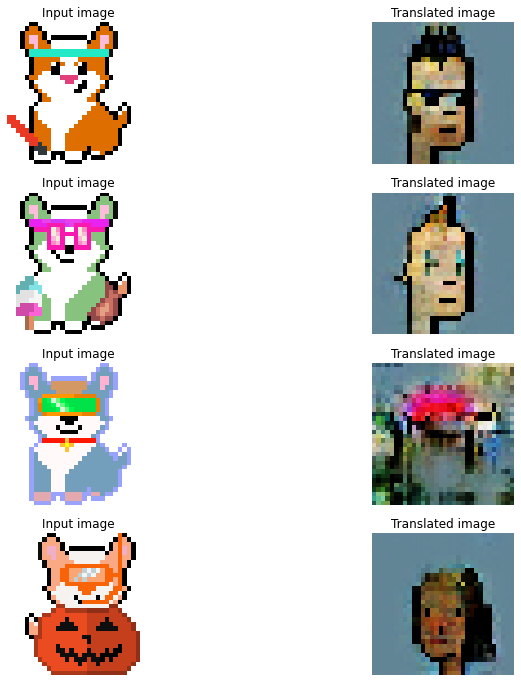

207/207 [==============================] - 118s 570ms/step - G_loss: 2.7712 - F_loss: 2.8615 - D_X_loss: 0.1069 - D_Y_loss: 0.0872
Epoch 52/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7940 - F_loss: 2.7763 - D_X_loss: 0.1187 - D_Y_loss: 0.0897

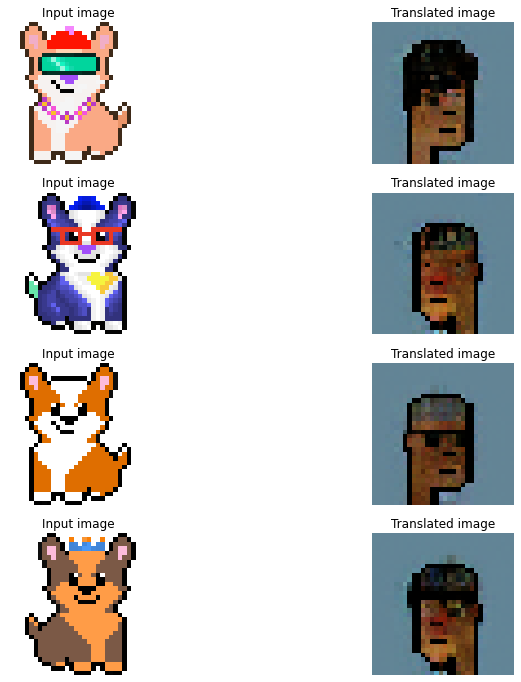

207/207 [==============================] - 118s 568ms/step - G_loss: 2.7950 - F_loss: 2.7855 - D_X_loss: 0.1185 - D_Y_loss: 0.0903
Epoch 53/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7576 - F_loss: 2.7801 - D_X_loss: 0.0941 - D_Y_loss: 0.0874

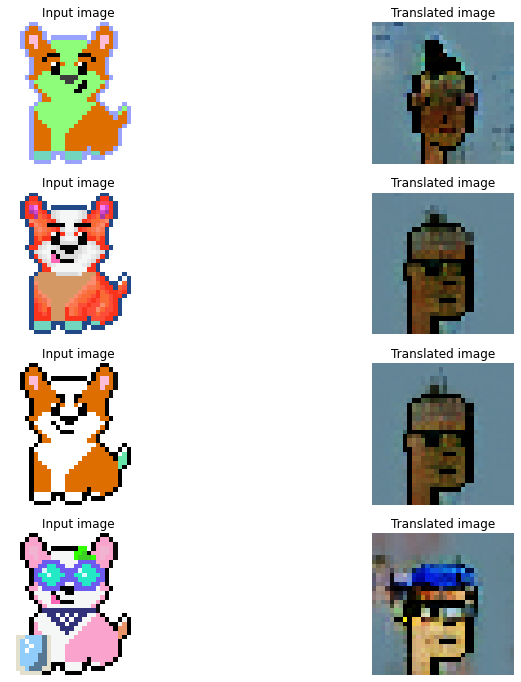

207/207 [==============================] - 117s 566ms/step - G_loss: 2.7571 - F_loss: 2.7785 - D_X_loss: 0.0938 - D_Y_loss: 0.0870
Epoch 54/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7920 - F_loss: 2.9647 - D_X_loss: 0.0959 - D_Y_loss: 0.0917

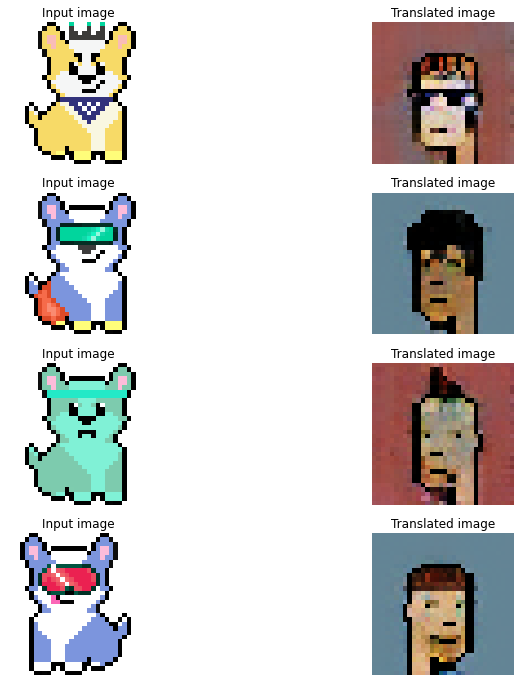

207/207 [==============================] - 117s 566ms/step - G_loss: 2.7861 - F_loss: 2.9600 - D_X_loss: 0.0955 - D_Y_loss: 0.0915
Epoch 55/200
207/207 [==============================] - ETA: 0s - G_loss: 2.8401 - F_loss: 2.8081 - D_X_loss: 0.0911 - D_Y_loss: 0.0888

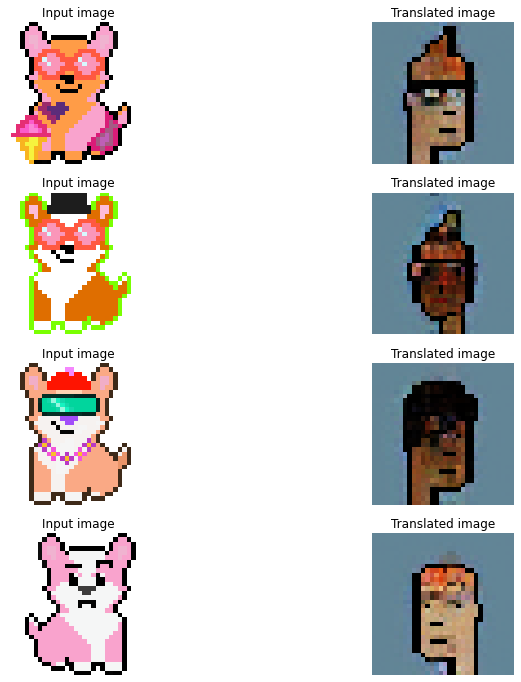

207/207 [==============================] - 117s 565ms/step - G_loss: 2.8362 - F_loss: 2.8107 - D_X_loss: 0.0913 - D_Y_loss: 0.0885
Epoch 56/200
207/207 [==============================] - ETA: 0s - G_loss: 2.6414 - F_loss: 2.7671 - D_X_loss: 0.0993 - D_Y_loss: 0.0918

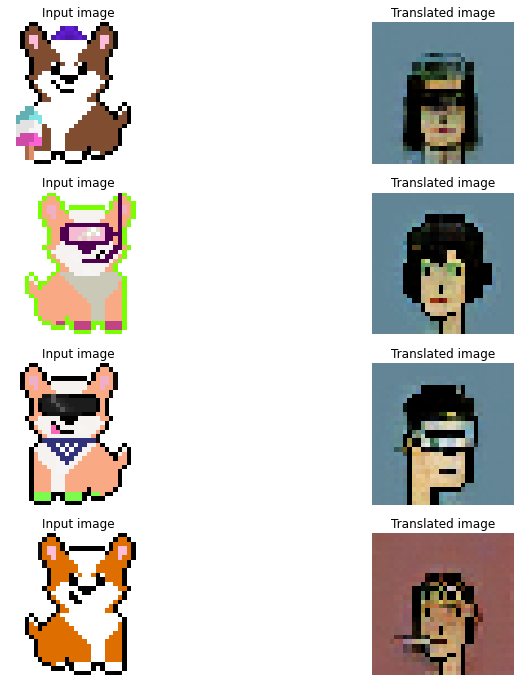

207/207 [==============================] - 117s 564ms/step - G_loss: 2.6504 - F_loss: 2.7717 - D_X_loss: 0.0989 - D_Y_loss: 0.0917
Epoch 57/200
207/207 [==============================] - ETA: 0s - G_loss: 2.6703 - F_loss: 2.7574 - D_X_loss: 0.0938 - D_Y_loss: 0.0869

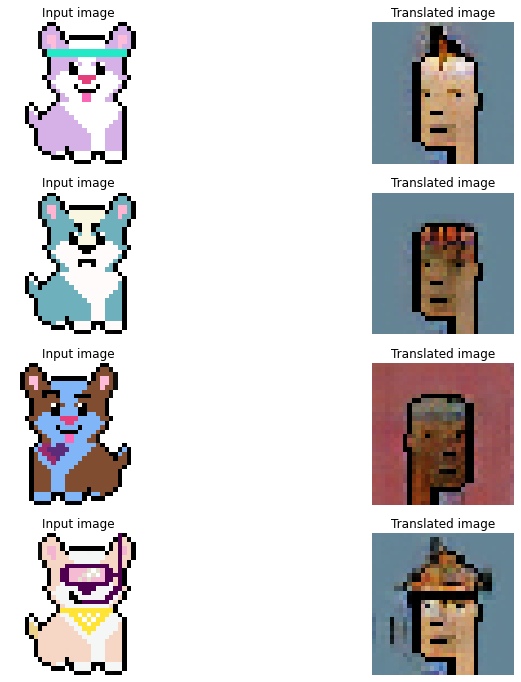

207/207 [==============================] - 116s 563ms/step - G_loss: 2.6695 - F_loss: 2.7600 - D_X_loss: 0.0936 - D_Y_loss: 0.0872
Epoch 58/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7241 - F_loss: 2.7456 - D_X_loss: 0.1037 - D_Y_loss: 0.0967

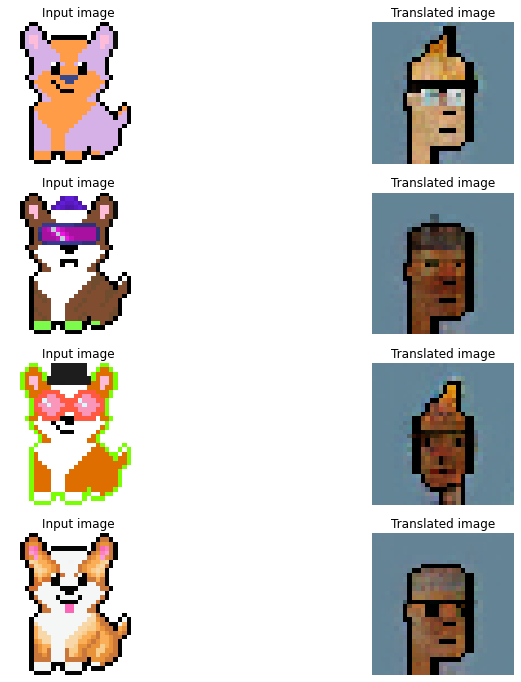

207/207 [==============================] - 116s 563ms/step - G_loss: 2.7208 - F_loss: 2.7463 - D_X_loss: 0.1036 - D_Y_loss: 0.0963
Epoch 59/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5665 - F_loss: 2.6417 - D_X_loss: 0.1012 - D_Y_loss: 0.0876

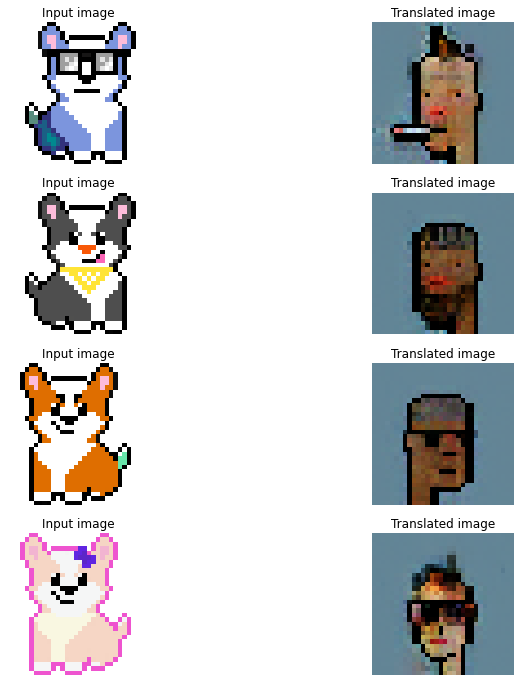

207/207 [==============================] - 116s 561ms/step - G_loss: 2.5608 - F_loss: 2.6395 - D_X_loss: 0.1008 - D_Y_loss: 0.0882
Epoch 60/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7362 - F_loss: 2.6267 - D_X_loss: 0.1043 - D_Y_loss: 0.0875

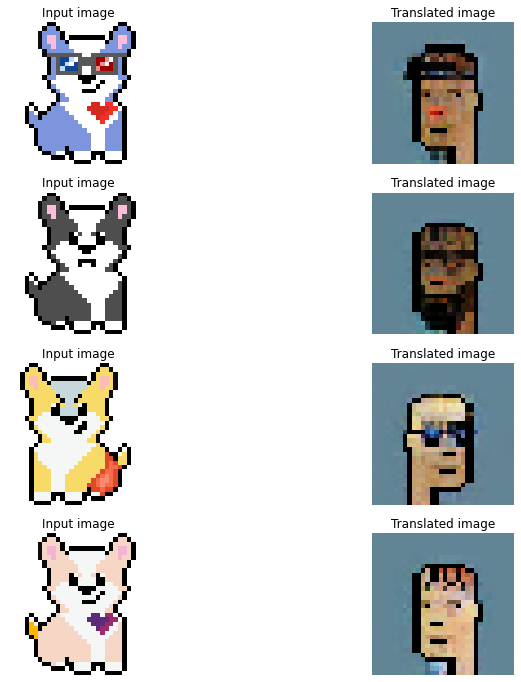

207/207 [==============================] - 116s 561ms/step - G_loss: 2.7279 - F_loss: 2.6238 - D_X_loss: 0.1065 - D_Y_loss: 0.0888
Epoch 61/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5738 - F_loss: 2.6491 - D_X_loss: 0.1064 - D_Y_loss: 0.1073

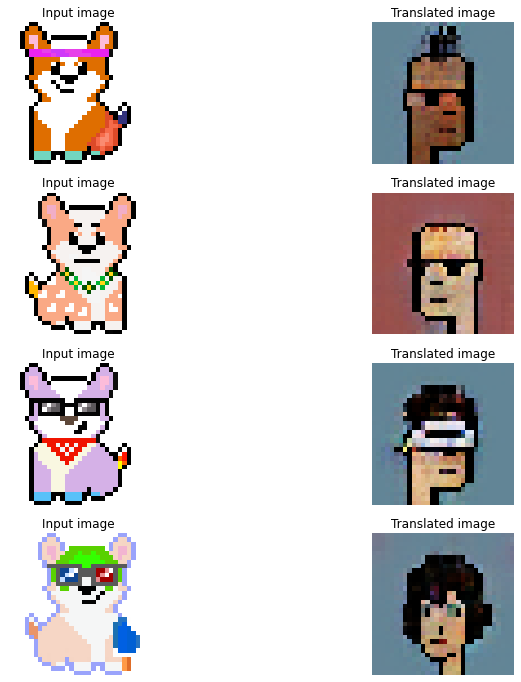

207/207 [==============================] - 116s 562ms/step - G_loss: 2.5696 - F_loss: 2.6497 - D_X_loss: 0.1060 - D_Y_loss: 0.1075
Epoch 62/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5837 - F_loss: 2.6266 - D_X_loss: 0.1059 - D_Y_loss: 0.0886

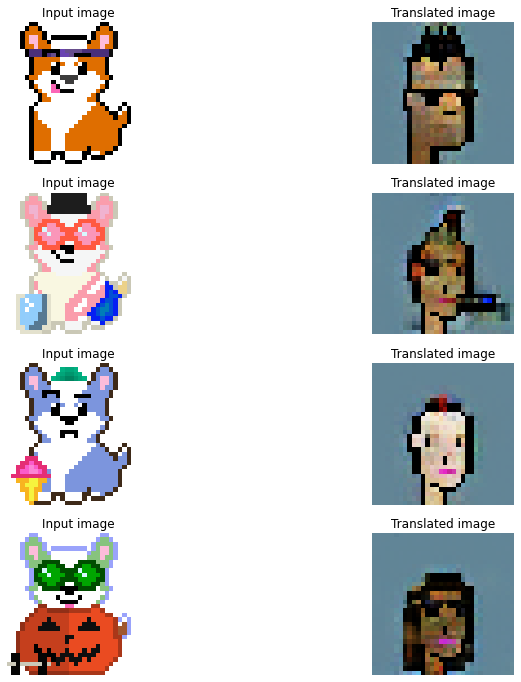

207/207 [==============================] - 117s 565ms/step - G_loss: 2.5794 - F_loss: 2.6347 - D_X_loss: 0.1067 - D_Y_loss: 0.0886
Epoch 63/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5585 - F_loss: 2.5958 - D_X_loss: 0.1037 - D_Y_loss: 0.0926

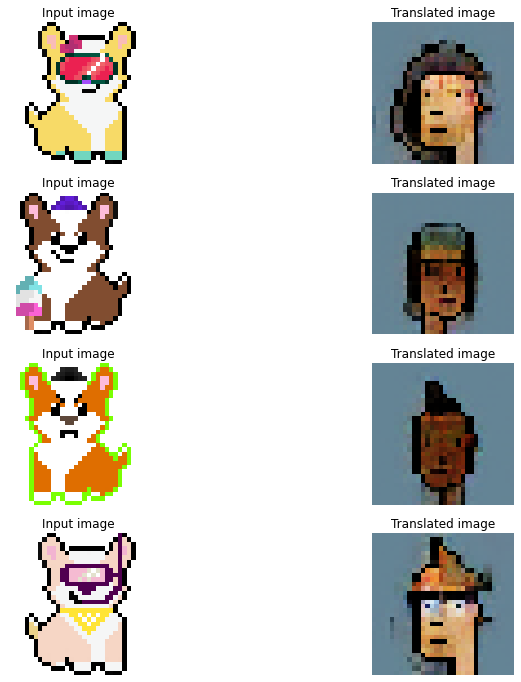

207/207 [==============================] - 118s 568ms/step - G_loss: 2.5698 - F_loss: 2.5933 - D_X_loss: 0.1034 - D_Y_loss: 0.0923
Epoch 64/200
207/207 [==============================] - ETA: 0s - G_loss: 2.7229 - F_loss: 2.7608 - D_X_loss: 0.1045 - D_Y_loss: 0.0837

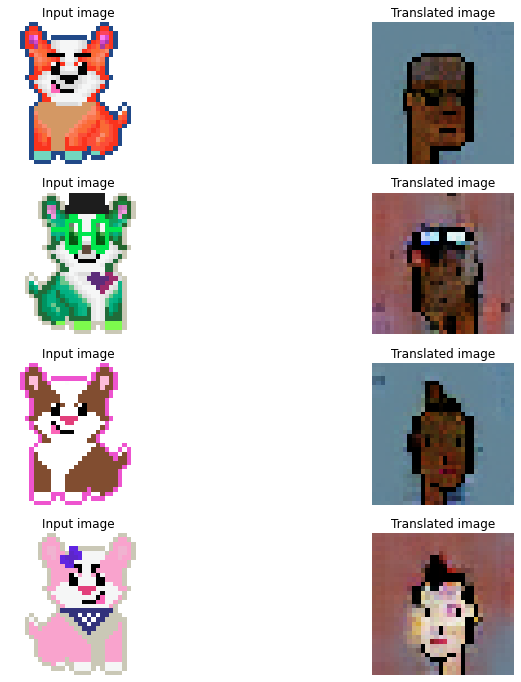

207/207 [==============================] - 122s 589ms/step - G_loss: 2.7244 - F_loss: 2.7517 - D_X_loss: 0.1057 - D_Y_loss: 0.0833
Epoch 65/200
207/207 [==============================] - ETA: 0s - G_loss: 2.6720 - F_loss: 2.6110 - D_X_loss: 0.0958 - D_Y_loss: 0.0945

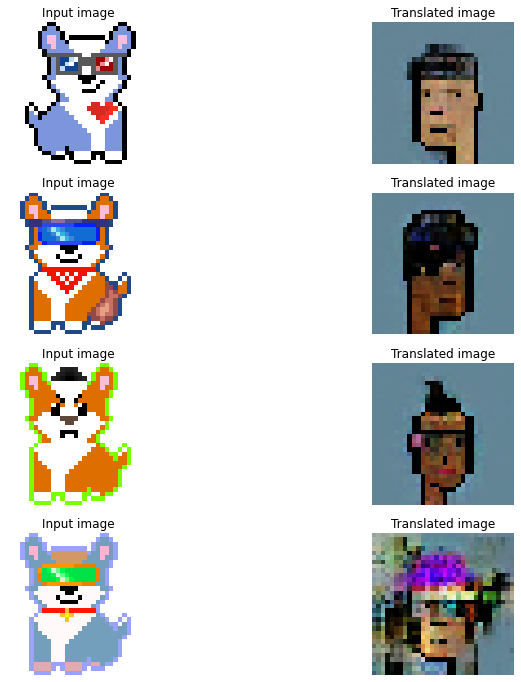

207/207 [==============================] - 122s 587ms/step - G_loss: 2.6699 - F_loss: 2.6086 - D_X_loss: 0.0955 - D_Y_loss: 0.0941
Epoch 66/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5665 - F_loss: 2.6502 - D_X_loss: 0.1088 - D_Y_loss: 0.0930

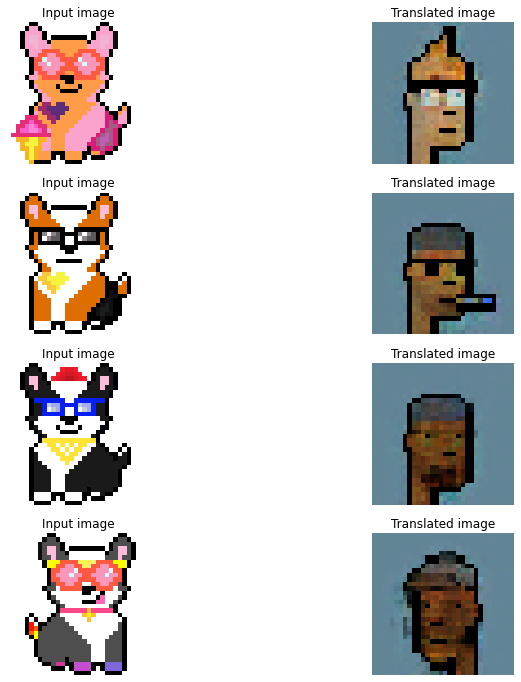

207/207 [==============================] - 121s 586ms/step - G_loss: 2.5583 - F_loss: 2.6495 - D_X_loss: 0.1102 - D_Y_loss: 0.0940
Epoch 67/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4697 - F_loss: 2.5788 - D_X_loss: 0.0990 - D_Y_loss: 0.0925

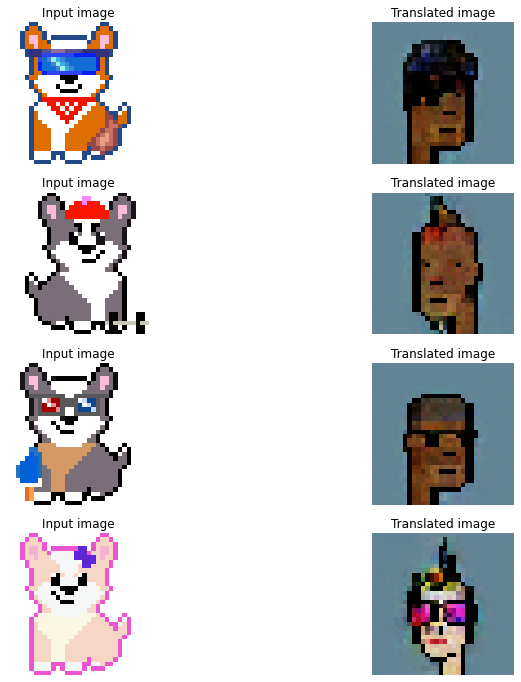

207/207 [==============================] - 121s 584ms/step - G_loss: 2.4689 - F_loss: 2.5783 - D_X_loss: 0.0987 - D_Y_loss: 0.0921
Epoch 68/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5587 - F_loss: 2.5183 - D_X_loss: 0.1132 - D_Y_loss: 0.0942

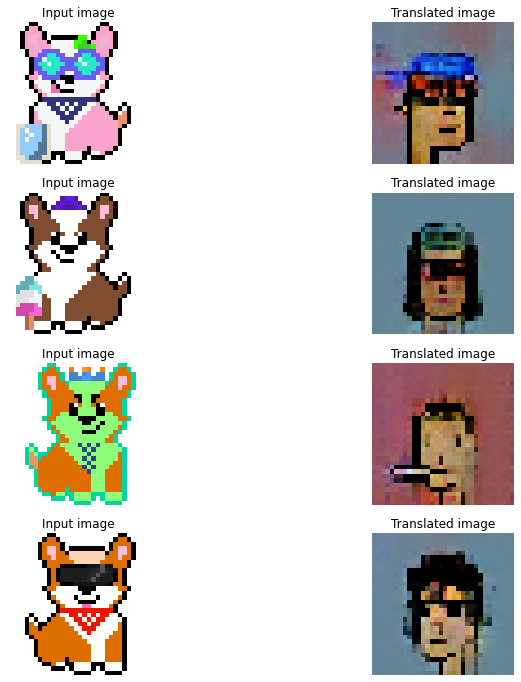

207/207 [==============================] - 121s 584ms/step - G_loss: 2.5542 - F_loss: 2.5181 - D_X_loss: 0.1133 - D_Y_loss: 0.0938
Epoch 69/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5689 - F_loss: 2.5365 - D_X_loss: 0.1005 - D_Y_loss: 0.0859

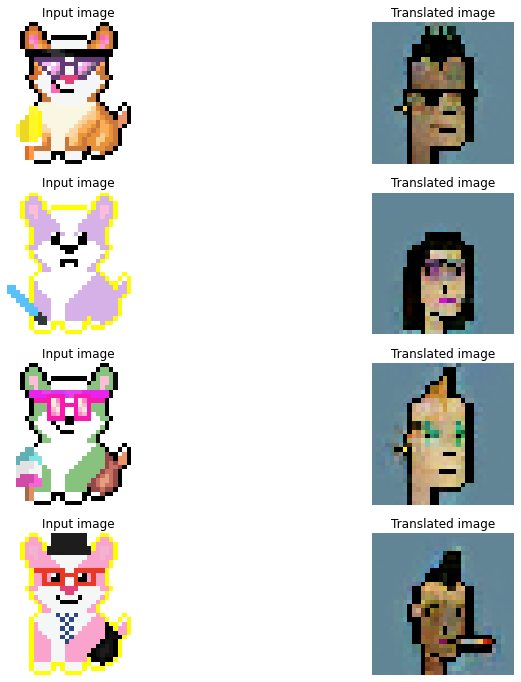

207/207 [==============================] - 120s 582ms/step - G_loss: 2.5661 - F_loss: 2.5368 - D_X_loss: 0.1002 - D_Y_loss: 0.0860
Epoch 70/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4146 - F_loss: 2.4956 - D_X_loss: 0.1088 - D_Y_loss: 0.1030

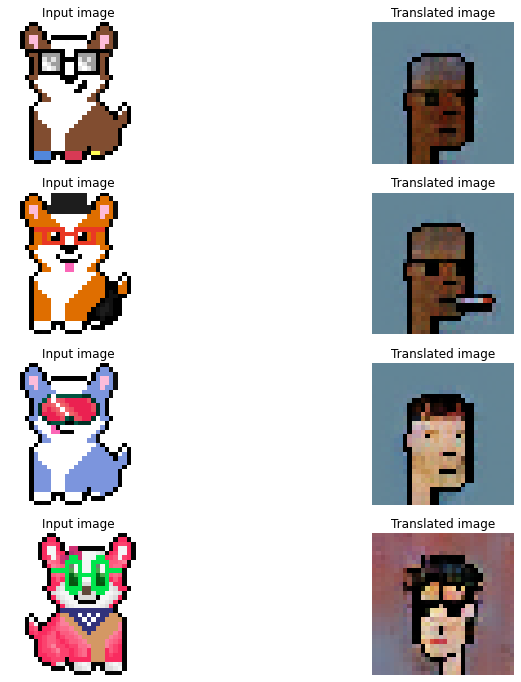

207/207 [==============================] - 120s 580ms/step - G_loss: 2.4122 - F_loss: 2.4873 - D_X_loss: 0.1110 - D_Y_loss: 0.1028
Epoch 71/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4173 - F_loss: 2.5407 - D_X_loss: 0.1030 - D_Y_loss: 0.1074

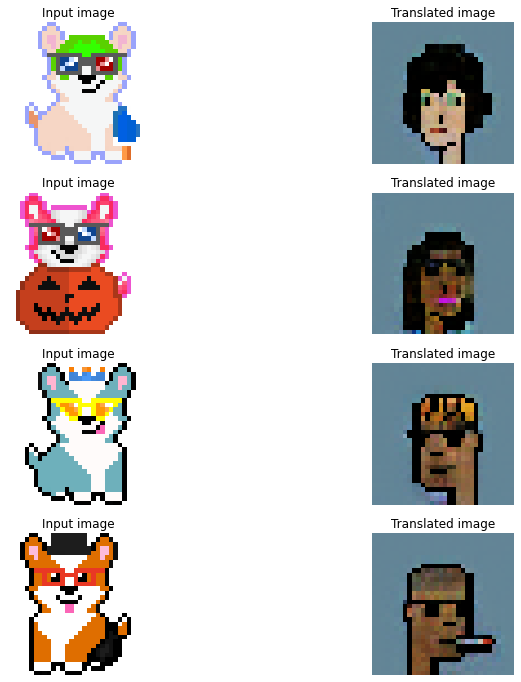

207/207 [==============================] - 120s 578ms/step - G_loss: 2.4106 - F_loss: 2.5375 - D_X_loss: 0.1029 - D_Y_loss: 0.1082
Epoch 72/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4487 - F_loss: 2.4730 - D_X_loss: 0.1151 - D_Y_loss: 0.0924

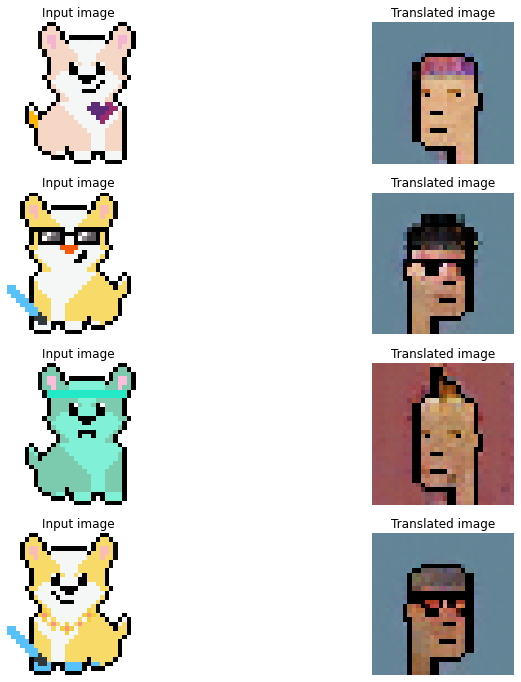

207/207 [==============================] - 120s 577ms/step - G_loss: 2.4520 - F_loss: 2.4773 - D_X_loss: 0.1148 - D_Y_loss: 0.0922
Epoch 73/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5075 - F_loss: 2.5402 - D_X_loss: 0.1084 - D_Y_loss: 0.0879

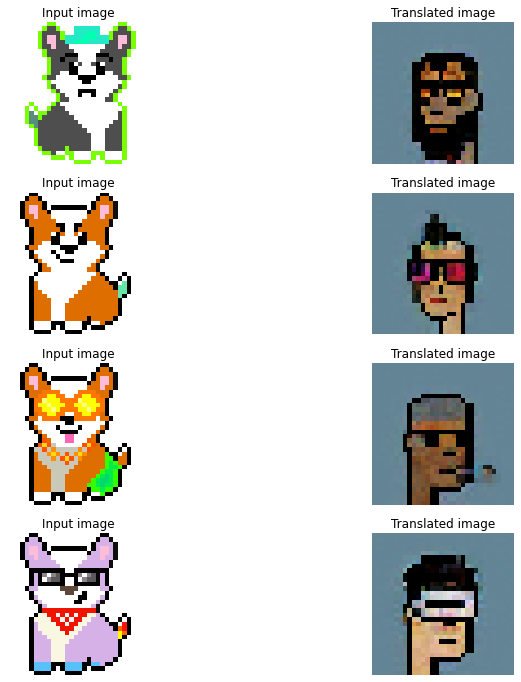

207/207 [==============================] - 119s 576ms/step - G_loss: 2.5218 - F_loss: 2.5403 - D_X_loss: 0.1080 - D_Y_loss: 0.0880
Epoch 74/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4585 - F_loss: 2.4684 - D_X_loss: 0.1138 - D_Y_loss: 0.0952

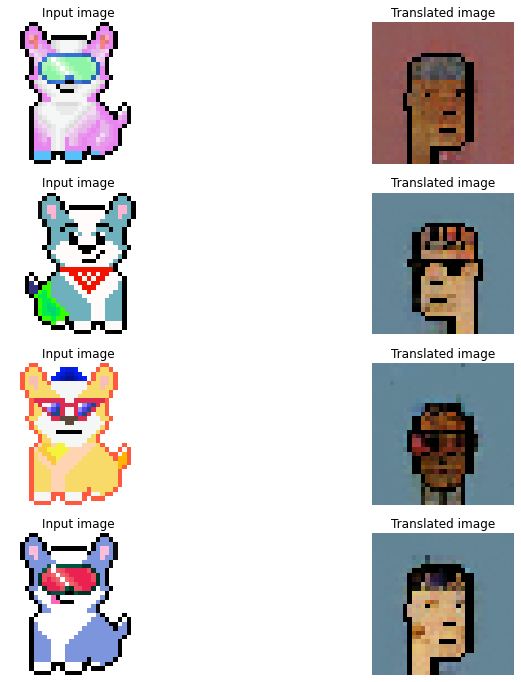

207/207 [==============================] - 119s 574ms/step - G_loss: 2.4627 - F_loss: 2.4717 - D_X_loss: 0.1135 - D_Y_loss: 0.0947
Epoch 75/200
207/207 [==============================] - ETA: 0s - G_loss: 2.5349 - F_loss: 2.5300 - D_X_loss: 0.1082 - D_Y_loss: 0.0999

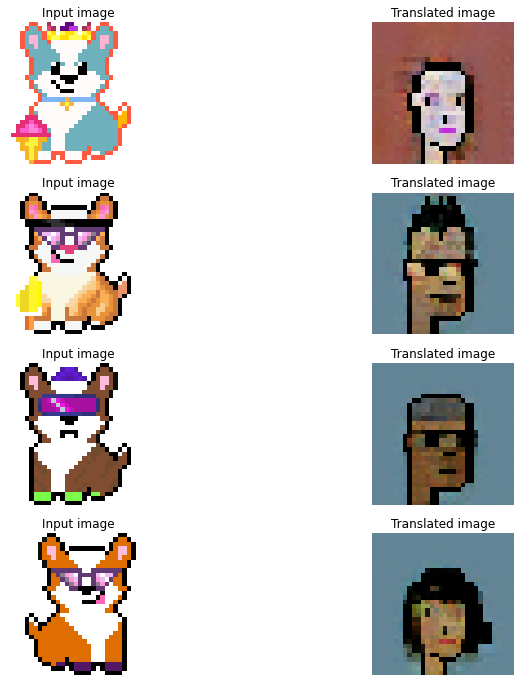

207/207 [==============================] - 119s 573ms/step - G_loss: 2.5372 - F_loss: 2.5324 - D_X_loss: 0.1078 - D_Y_loss: 0.0995
Epoch 76/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4417 - F_loss: 2.4832 - D_X_loss: 0.1083 - D_Y_loss: 0.0994

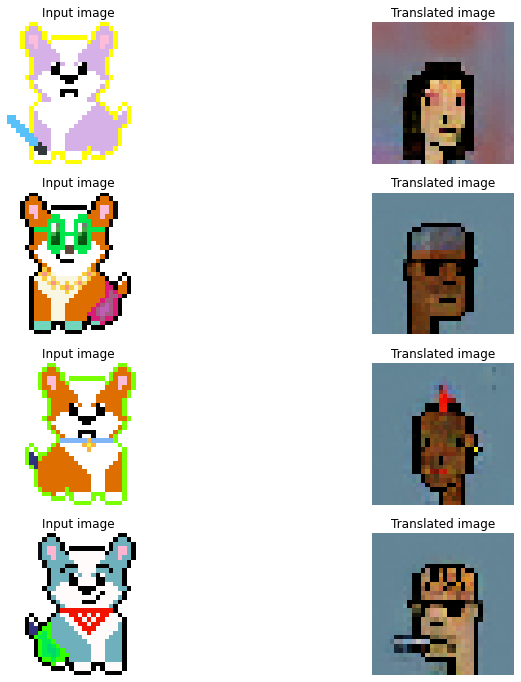

207/207 [==============================] - 119s 573ms/step - G_loss: 2.4340 - F_loss: 2.4827 - D_X_loss: 0.1081 - D_Y_loss: 0.1006
Epoch 77/200
207/207 [==============================] - ETA: 0s - G_loss: 2.3658 - F_loss: 2.4175 - D_X_loss: 0.1241 - D_Y_loss: 0.1057

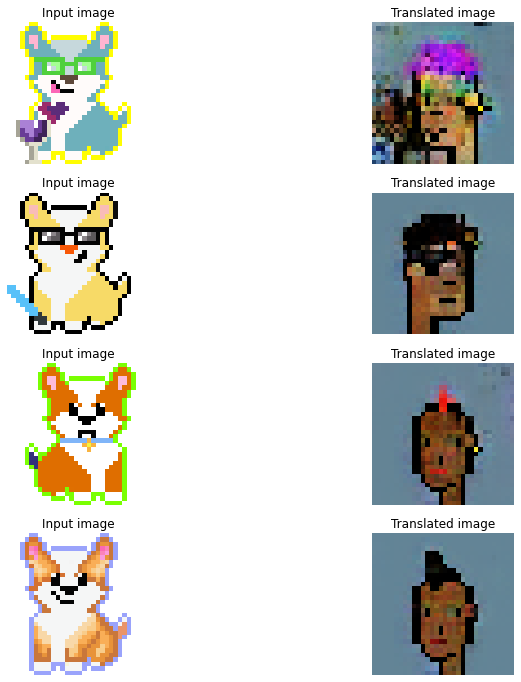

207/207 [==============================] - 118s 571ms/step - G_loss: 2.3734 - F_loss: 2.4209 - D_X_loss: 0.1237 - D_Y_loss: 0.1052
Epoch 78/200
207/207 [==============================] - ETA: 0s - G_loss: 2.3317 - F_loss: 2.3683 - D_X_loss: 0.1172 - D_Y_loss: 0.1027

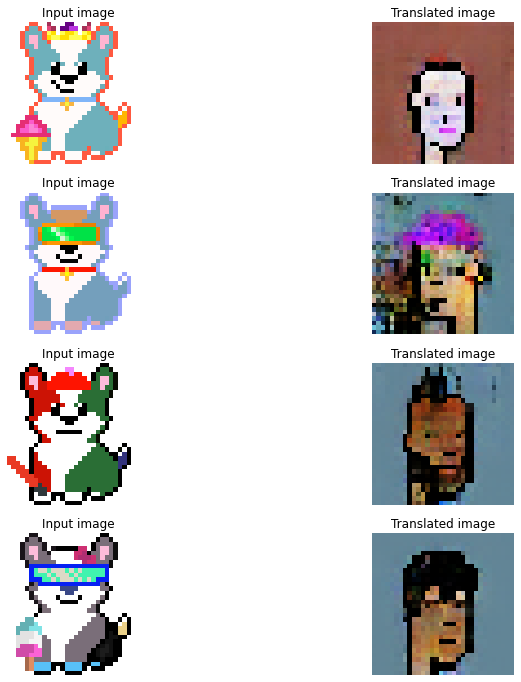

207/207 [==============================] - 118s 571ms/step - G_loss: 2.3241 - F_loss: 2.3653 - D_X_loss: 0.1177 - D_Y_loss: 0.1037
Epoch 79/200
207/207 [==============================] - ETA: 0s - G_loss: 2.4130 - F_loss: 2.3667 - D_X_loss: 0.1125 - D_Y_loss: 0.0946

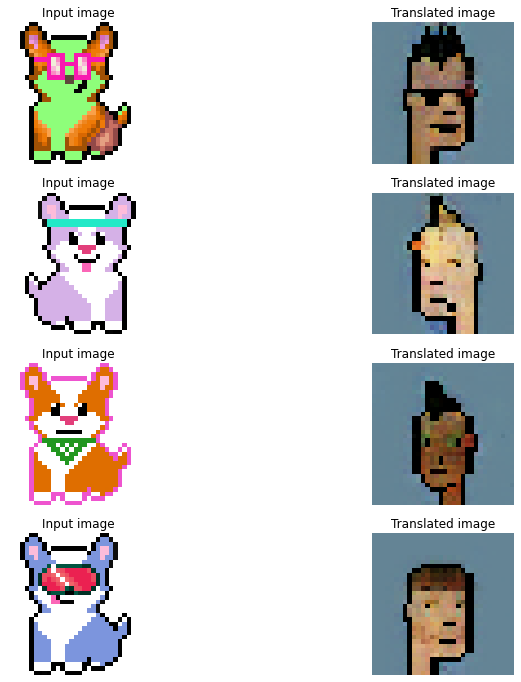

207/207 [==============================] - 118s 570ms/step - G_loss: 2.4167 - F_loss: 2.3672 - D_X_loss: 0.1130 - D_Y_loss: 0.0942
Epoch 80/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2518 - F_loss: 2.3801 - D_X_loss: 0.1081 - D_Y_loss: 0.1111

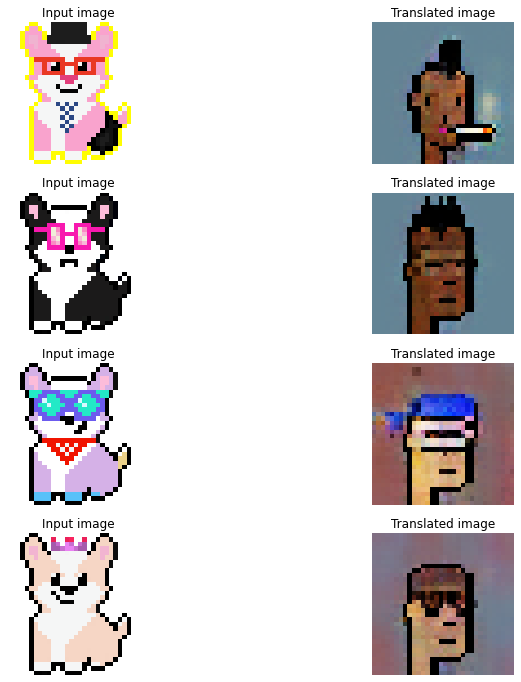

207/207 [==============================] - 118s 569ms/step - G_loss: 2.2647 - F_loss: 2.3742 - D_X_loss: 0.1087 - D_Y_loss: 0.1109
Epoch 81/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2367 - F_loss: 2.3887 - D_X_loss: 0.1194 - D_Y_loss: 0.1202

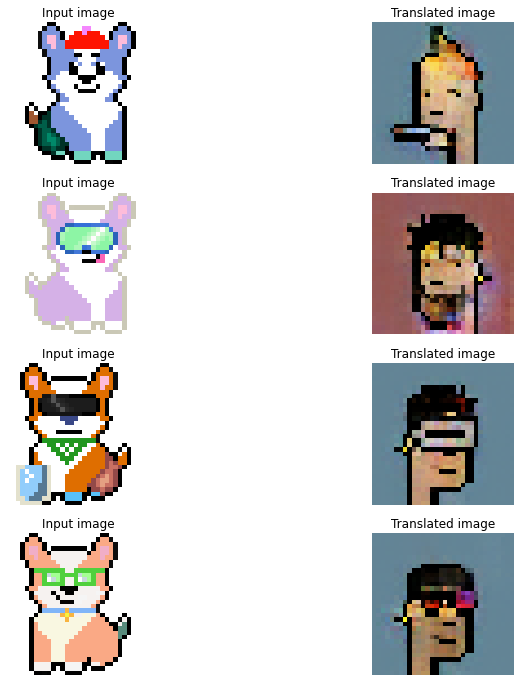

207/207 [==============================] - 118s 569ms/step - G_loss: 2.2339 - F_loss: 2.3883 - D_X_loss: 0.1189 - D_Y_loss: 0.1197
Epoch 82/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2180 - F_loss: 2.2975 - D_X_loss: 0.1222 - D_Y_loss: 0.1113

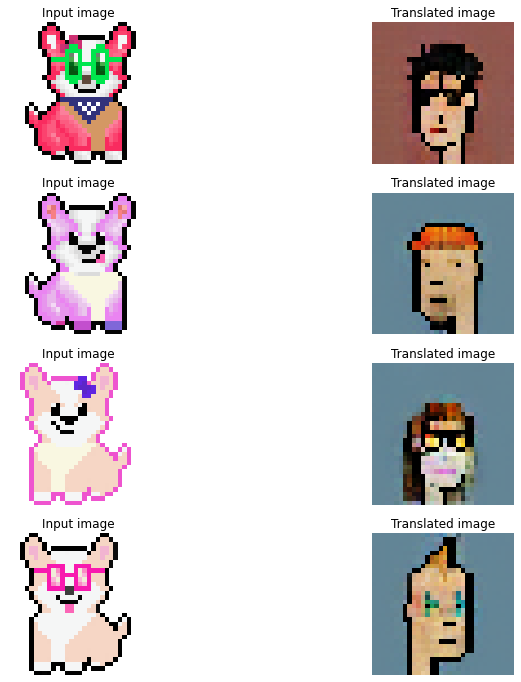

207/207 [==============================] - 117s 567ms/step - G_loss: 2.2141 - F_loss: 2.3008 - D_X_loss: 0.1217 - D_Y_loss: 0.1113
Epoch 83/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2239 - F_loss: 2.3459 - D_X_loss: 0.1176 - D_Y_loss: 0.1145

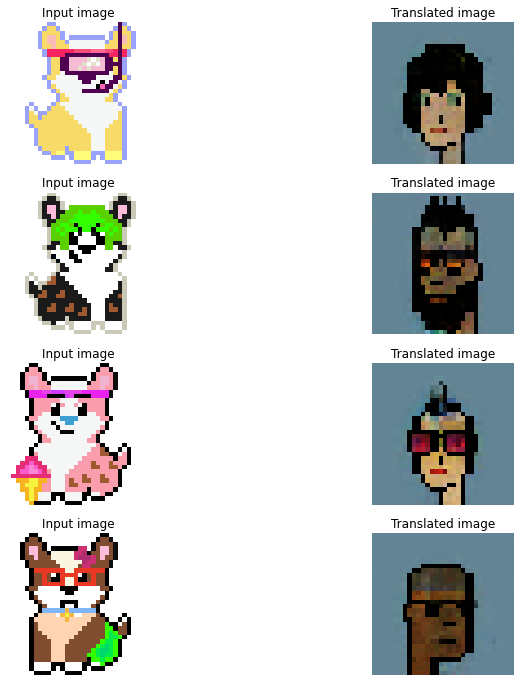

207/207 [==============================] - 117s 565ms/step - G_loss: 2.2182 - F_loss: 2.3504 - D_X_loss: 0.1171 - D_Y_loss: 0.1156
Epoch 84/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2826 - F_loss: 2.3822 - D_X_loss: 0.1157 - D_Y_loss: 0.1069

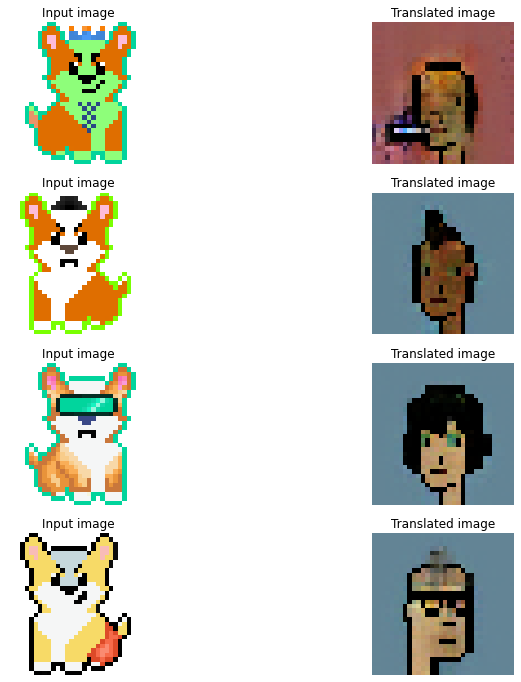

207/207 [==============================] - 117s 564ms/step - G_loss: 2.2804 - F_loss: 2.3765 - D_X_loss: 0.1167 - D_Y_loss: 0.1068
Epoch 85/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1898 - F_loss: 2.3079 - D_X_loss: 0.1165 - D_Y_loss: 0.1092

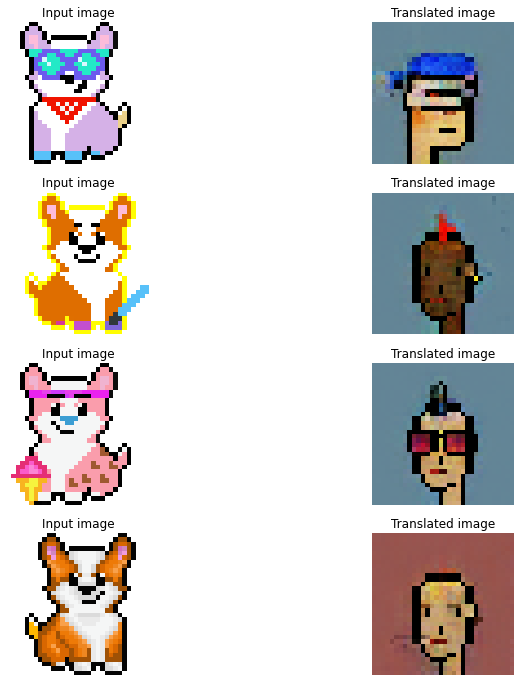

207/207 [==============================] - 116s 562ms/step - G_loss: 2.1898 - F_loss: 2.3014 - D_X_loss: 0.1174 - D_Y_loss: 0.1089
Epoch 86/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1665 - F_loss: 2.3145 - D_X_loss: 0.1208 - D_Y_loss: 0.1086

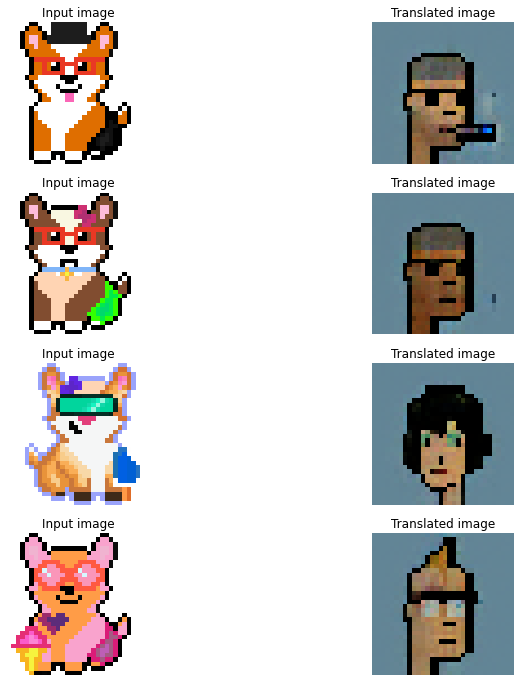

207/207 [==============================] - 116s 561ms/step - G_loss: 2.1624 - F_loss: 2.3125 - D_X_loss: 0.1206 - D_Y_loss: 0.1096
Epoch 87/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2808 - F_loss: 2.2926 - D_X_loss: 0.1265 - D_Y_loss: 0.1068

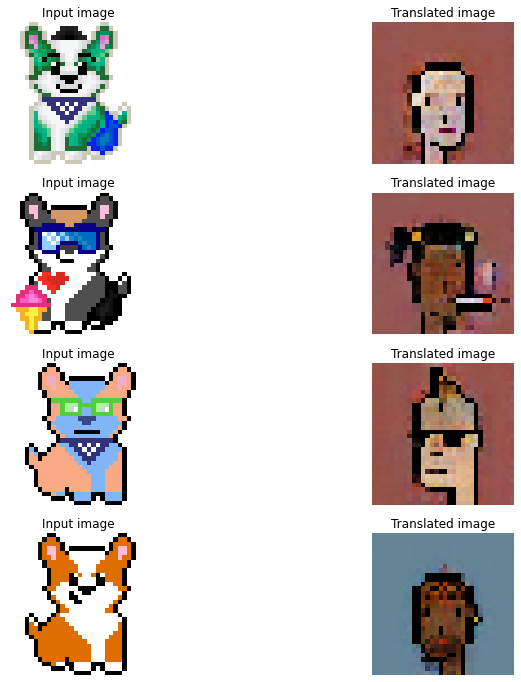

207/207 [==============================] - 116s 561ms/step - G_loss: 2.2784 - F_loss: 2.2926 - D_X_loss: 0.1259 - D_Y_loss: 0.1063
Epoch 88/200
207/207 [==============================] - ETA: 0s - G_loss: 2.3054 - F_loss: 2.2814 - D_X_loss: 0.1317 - D_Y_loss: 0.1128

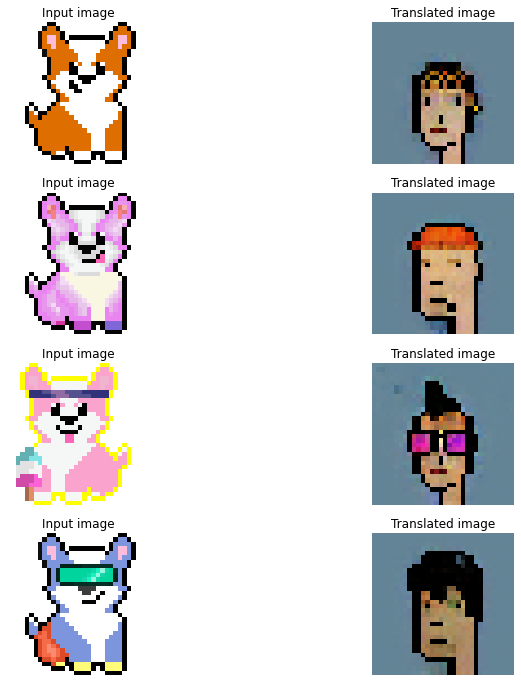

207/207 [==============================] - 116s 561ms/step - G_loss: 2.3082 - F_loss: 2.2804 - D_X_loss: 0.1313 - D_Y_loss: 0.1125
Epoch 89/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2477 - F_loss: 2.2939 - D_X_loss: 0.1217 - D_Y_loss: 0.1211

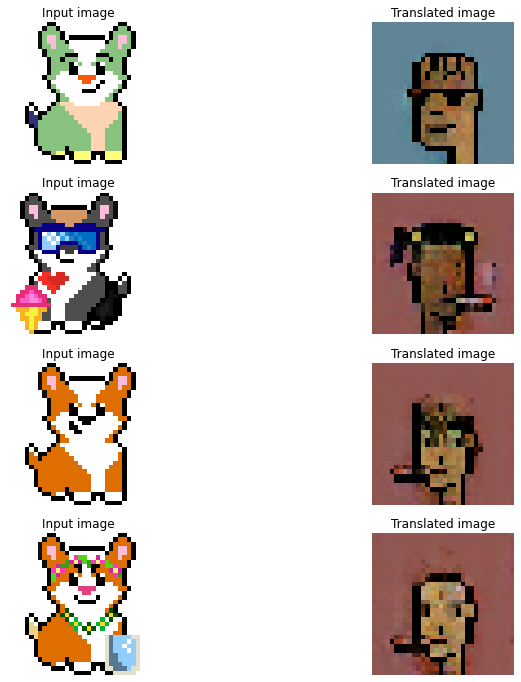

207/207 [==============================] - 116s 563ms/step - G_loss: 2.2610 - F_loss: 2.2923 - D_X_loss: 0.1212 - D_Y_loss: 0.1225
Epoch 90/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2909 - F_loss: 2.2544 - D_X_loss: 0.1250 - D_Y_loss: 0.1068

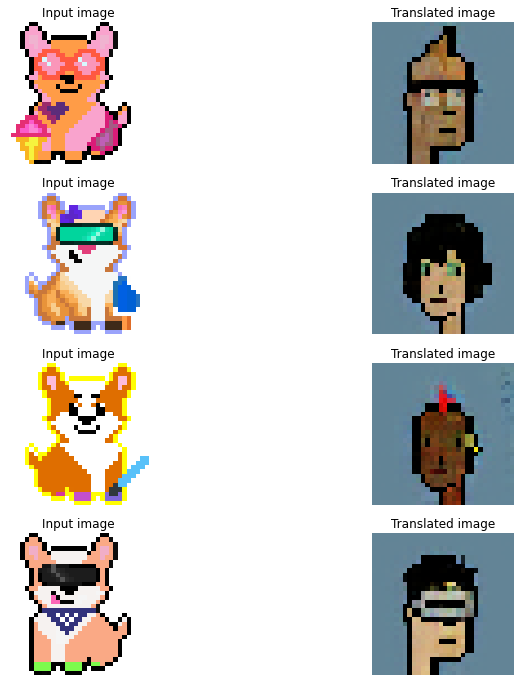

207/207 [==============================] - 117s 567ms/step - G_loss: 2.3033 - F_loss: 2.2488 - D_X_loss: 0.1257 - D_Y_loss: 0.1063
Epoch 91/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1556 - F_loss: 2.2764 - D_X_loss: 0.1207 - D_Y_loss: 0.1198

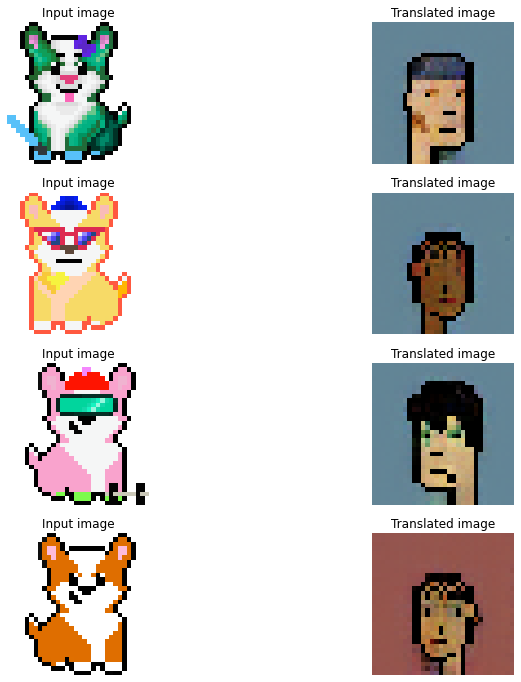

207/207 [==============================] - 122s 588ms/step - G_loss: 2.1514 - F_loss: 2.2832 - D_X_loss: 0.1202 - D_Y_loss: 0.1197
Epoch 92/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1100 - F_loss: 2.2620 - D_X_loss: 0.1240 - D_Y_loss: 0.1182

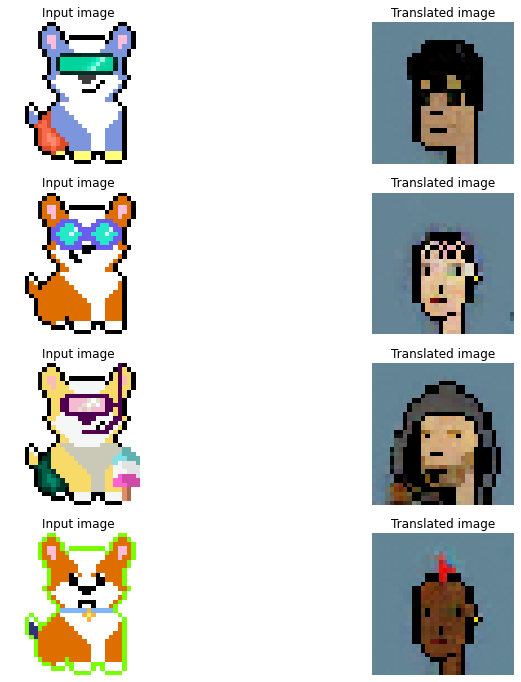

207/207 [==============================] - 121s 587ms/step - G_loss: 2.1102 - F_loss: 2.2585 - D_X_loss: 0.1254 - D_Y_loss: 0.1177
Epoch 93/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1073 - F_loss: 2.2528 - D_X_loss: 0.1204 - D_Y_loss: 0.1203

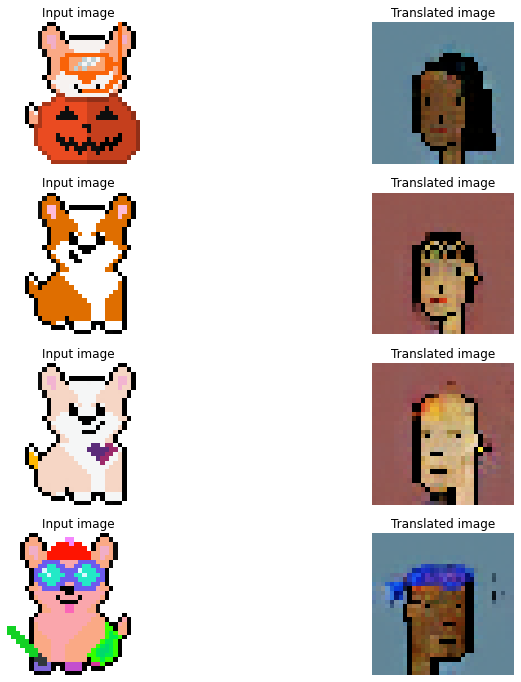

207/207 [==============================] - 121s 586ms/step - G_loss: 2.1045 - F_loss: 2.2607 - D_X_loss: 0.1204 - D_Y_loss: 0.1204
Epoch 94/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1121 - F_loss: 2.1978 - D_X_loss: 0.1316 - D_Y_loss: 0.1247

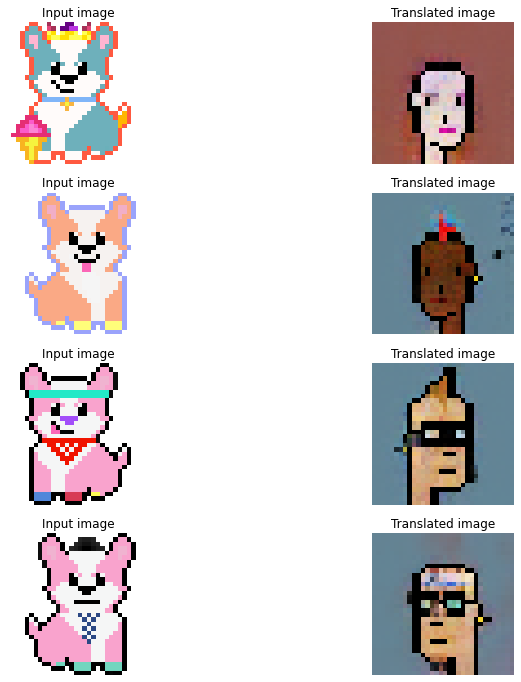

207/207 [==============================] - 121s 585ms/step - G_loss: 2.1134 - F_loss: 2.1934 - D_X_loss: 0.1331 - D_Y_loss: 0.1249
Epoch 95/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1000 - F_loss: 2.1862 - D_X_loss: 0.1309 - D_Y_loss: 0.1289

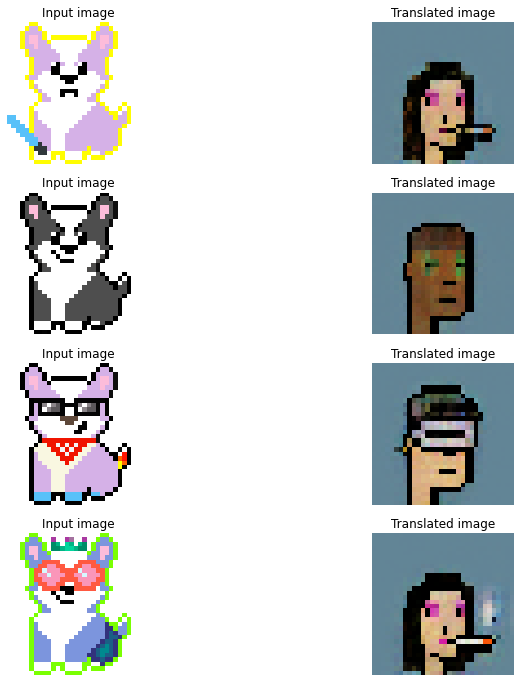

207/207 [==============================] - 121s 583ms/step - G_loss: 2.0977 - F_loss: 2.1833 - D_X_loss: 0.1324 - D_Y_loss: 0.1292
Epoch 96/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2040 - F_loss: 2.2415 - D_X_loss: 0.1244 - D_Y_loss: 0.1219

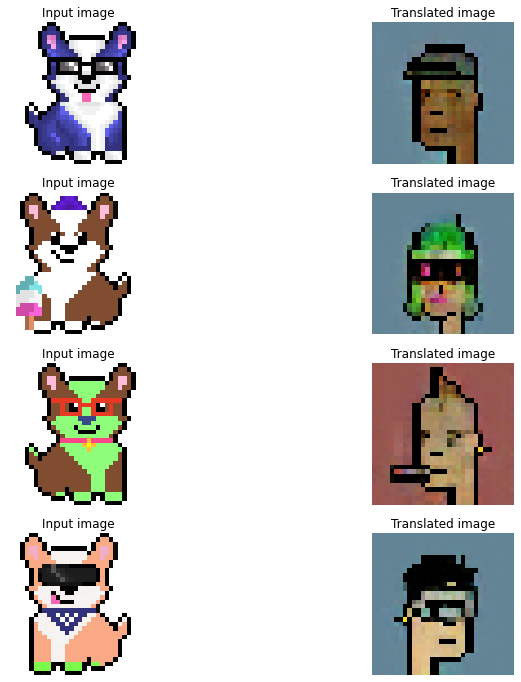

207/207 [==============================] - 120s 581ms/step - G_loss: 2.2186 - F_loss: 2.2498 - D_X_loss: 0.1239 - D_Y_loss: 0.1214
Epoch 97/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1690 - F_loss: 2.2547 - D_X_loss: 0.1236 - D_Y_loss: 0.1303

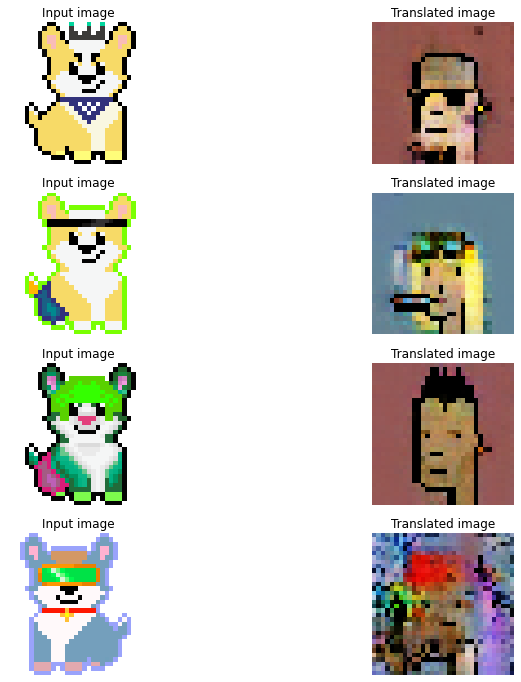

207/207 [==============================] - 120s 580ms/step - G_loss: 2.1665 - F_loss: 2.2526 - D_X_loss: 0.1238 - D_Y_loss: 0.1300
Epoch 98/200
207/207 [==============================] - ETA: 0s - G_loss: 2.2453 - F_loss: 2.2035 - D_X_loss: 0.1241 - D_Y_loss: 0.1248

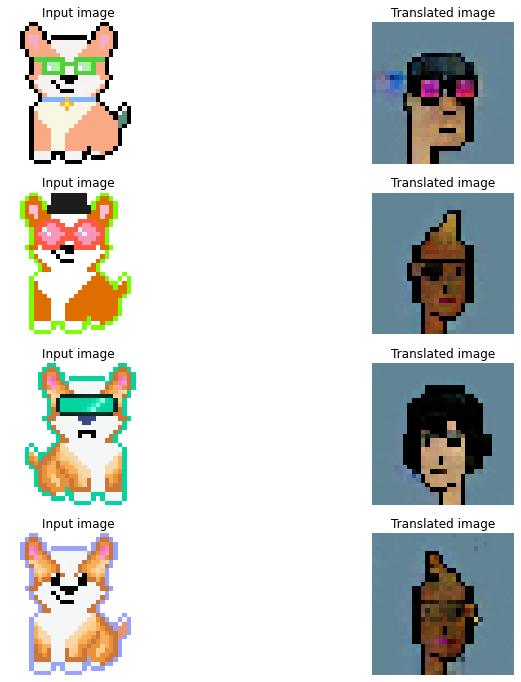

207/207 [==============================] - 120s 579ms/step - G_loss: 2.2556 - F_loss: 2.2169 - D_X_loss: 0.1236 - D_Y_loss: 0.1243
Epoch 99/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1243 - F_loss: 2.1560 - D_X_loss: 0.1371 - D_Y_loss: 0.1245

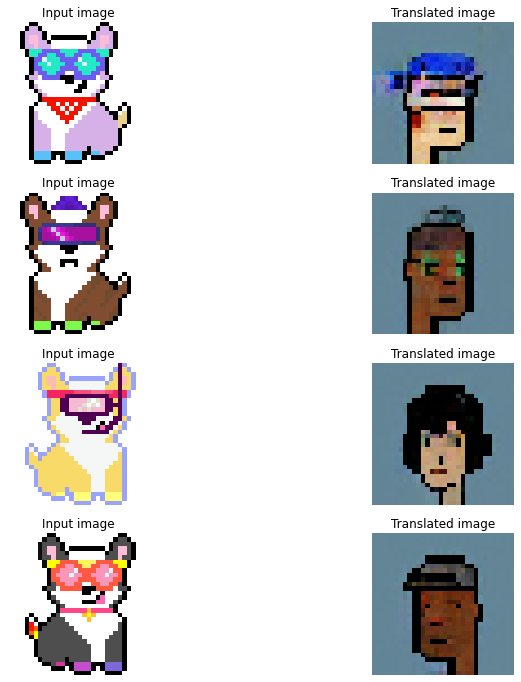

207/207 [==============================] - 119s 577ms/step - G_loss: 2.1261 - F_loss: 2.1551 - D_X_loss: 0.1369 - D_Y_loss: 0.1256
Epoch 100/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1356 - F_loss: 2.2067 - D_X_loss: 0.1267 - D_Y_loss: 0.1299

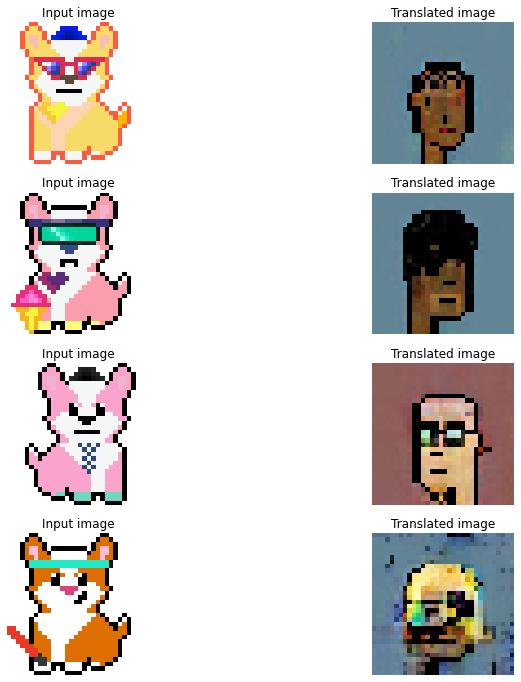

207/207 [==============================] - 119s 575ms/step - G_loss: 2.1329 - F_loss: 2.2092 - D_X_loss: 0.1262 - D_Y_loss: 0.1305
Epoch 101/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1462 - F_loss: 2.1481 - D_X_loss: 0.1301 - D_Y_loss: 0.1297

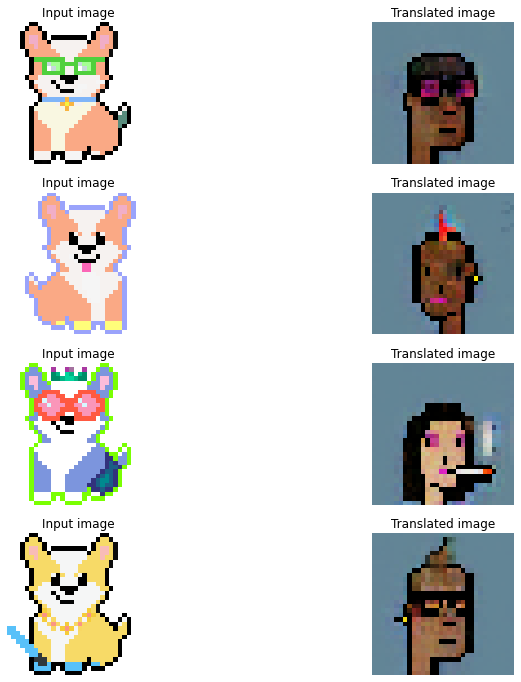

207/207 [==============================] - 119s 575ms/step - G_loss: 2.1403 - F_loss: 2.1509 - D_X_loss: 0.1295 - D_Y_loss: 0.1310
Epoch 102/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0803 - F_loss: 2.1692 - D_X_loss: 0.1257 - D_Y_loss: 0.1254

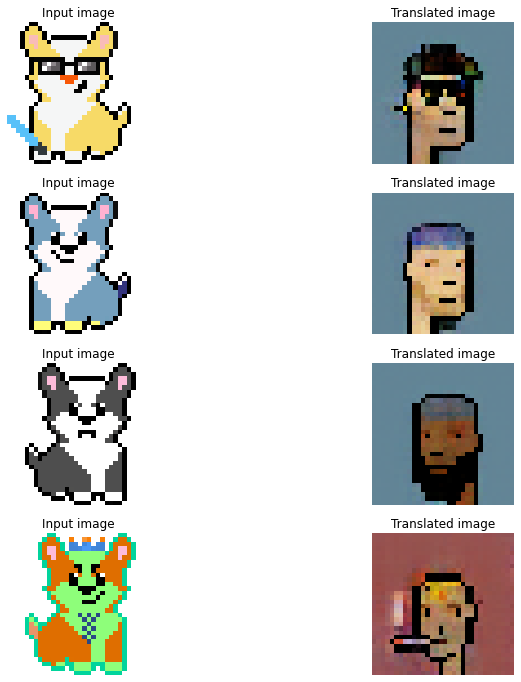

207/207 [==============================] - 119s 574ms/step - G_loss: 2.0742 - F_loss: 2.1711 - D_X_loss: 0.1256 - D_Y_loss: 0.1258
Epoch 103/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0828 - F_loss: 2.1710 - D_X_loss: 0.1343 - D_Y_loss: 0.1312

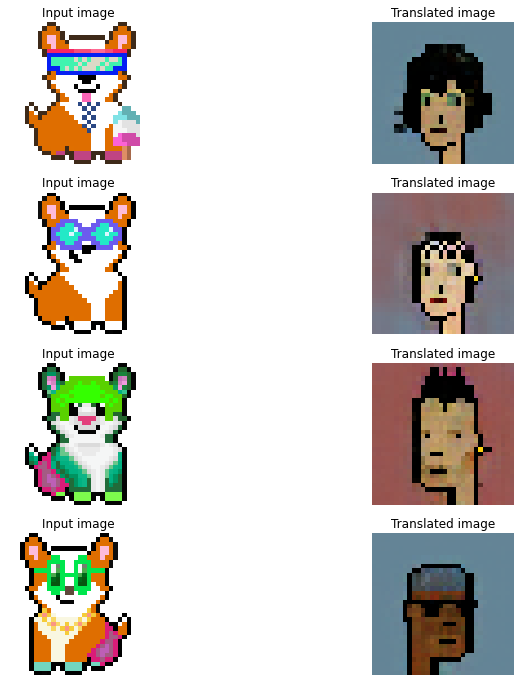

207/207 [==============================] - 119s 572ms/step - G_loss: 2.0968 - F_loss: 2.1656 - D_X_loss: 0.1353 - D_Y_loss: 0.1310
Epoch 104/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0275 - F_loss: 2.1065 - D_X_loss: 0.1297 - D_Y_loss: 0.1236

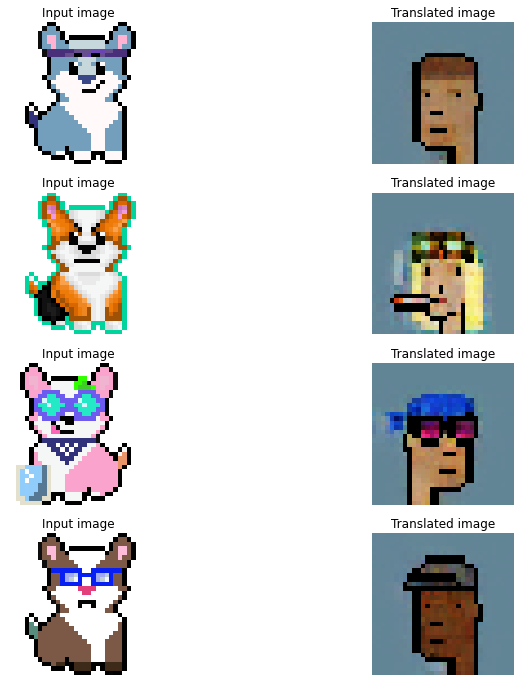

207/207 [==============================] - 119s 573ms/step - G_loss: 2.0249 - F_loss: 2.1214 - D_X_loss: 0.1291 - D_Y_loss: 0.1232
Epoch 105/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9969 - F_loss: 2.1173 - D_X_loss: 0.1384 - D_Y_loss: 0.1281

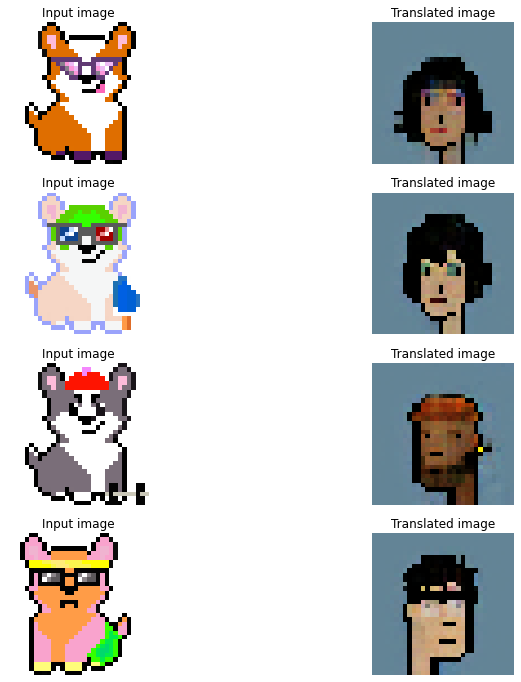

207/207 [==============================] - 118s 571ms/step - G_loss: 1.9933 - F_loss: 2.1275 - D_X_loss: 0.1379 - D_Y_loss: 0.1277
Epoch 106/200
207/207 [==============================] - ETA: 0s - G_loss: 2.1066 - F_loss: 2.0907 - D_X_loss: 0.1365 - D_Y_loss: 0.1286

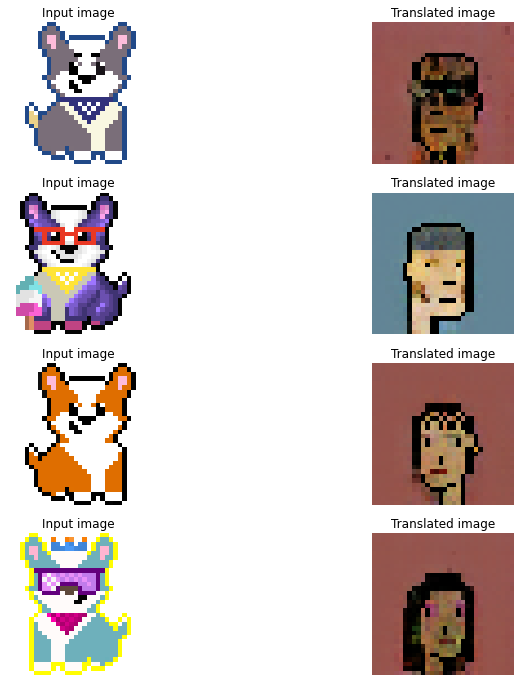

207/207 [==============================] - 118s 569ms/step - G_loss: 2.1018 - F_loss: 2.0924 - D_X_loss: 0.1361 - D_Y_loss: 0.1294
Epoch 107/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0635 - F_loss: 2.1646 - D_X_loss: 0.1300 - D_Y_loss: 0.1279

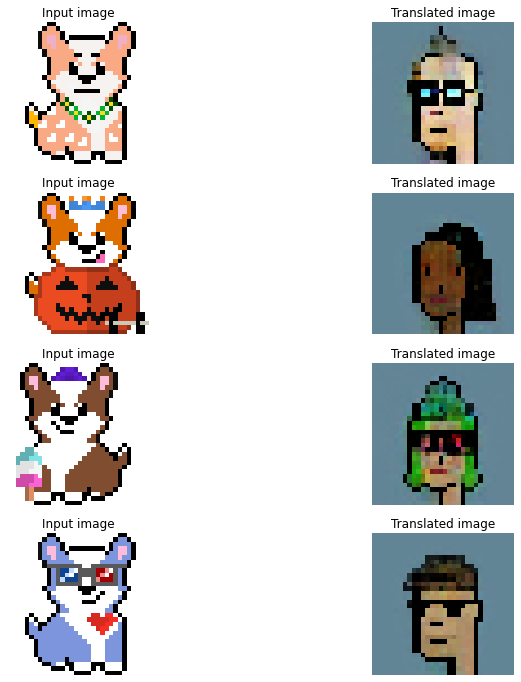

207/207 [==============================] - 117s 567ms/step - G_loss: 2.0658 - F_loss: 2.1597 - D_X_loss: 0.1315 - D_Y_loss: 0.1273
Epoch 108/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9644 - F_loss: 2.1286 - D_X_loss: 0.1374 - D_Y_loss: 0.1239

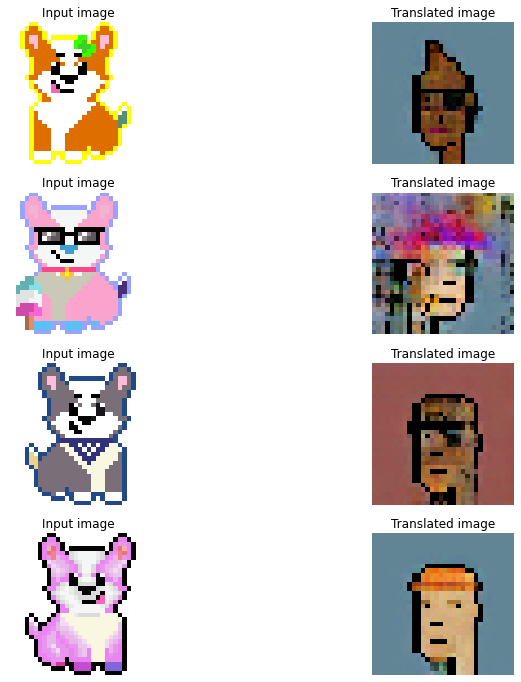

207/207 [==============================] - 117s 565ms/step - G_loss: 1.9640 - F_loss: 2.1292 - D_X_loss: 0.1371 - D_Y_loss: 0.1254
Epoch 109/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0900 - F_loss: 2.0781 - D_X_loss: 0.1394 - D_Y_loss: 0.1202

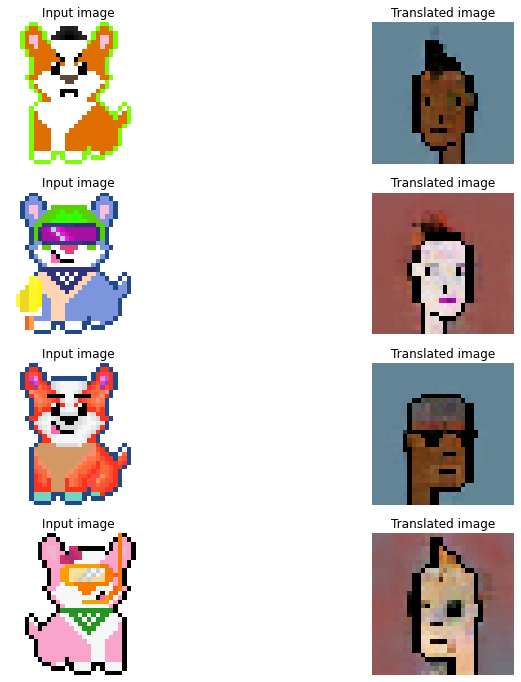

207/207 [==============================] - 116s 560ms/step - G_loss: 2.0869 - F_loss: 2.0746 - D_X_loss: 0.1388 - D_Y_loss: 0.1199
Epoch 110/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9273 - F_loss: 2.0778 - D_X_loss: 0.1357 - D_Y_loss: 0.1349

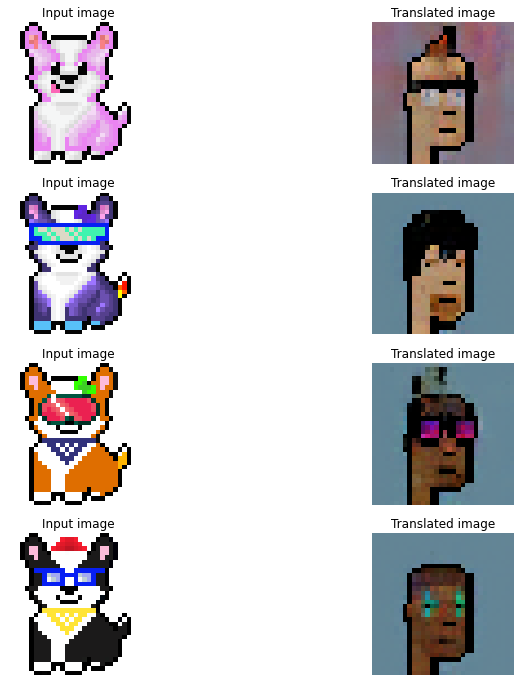

207/207 [==============================] - 116s 559ms/step - G_loss: 1.9250 - F_loss: 2.0727 - D_X_loss: 0.1365 - D_Y_loss: 0.1352
Epoch 111/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9771 - F_loss: 2.0650 - D_X_loss: 0.1403 - D_Y_loss: 0.1354

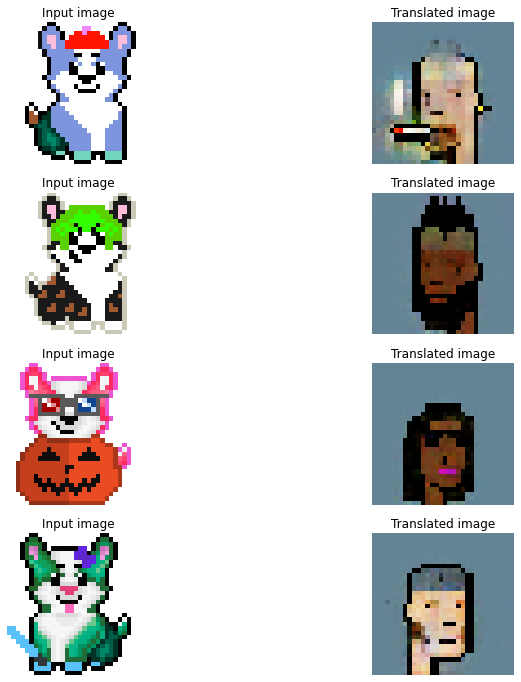

207/207 [==============================] - 115s 558ms/step - G_loss: 1.9718 - F_loss: 2.0673 - D_X_loss: 0.1398 - D_Y_loss: 0.1364
Epoch 112/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9628 - F_loss: 2.0824 - D_X_loss: 0.1303 - D_Y_loss: 0.1315

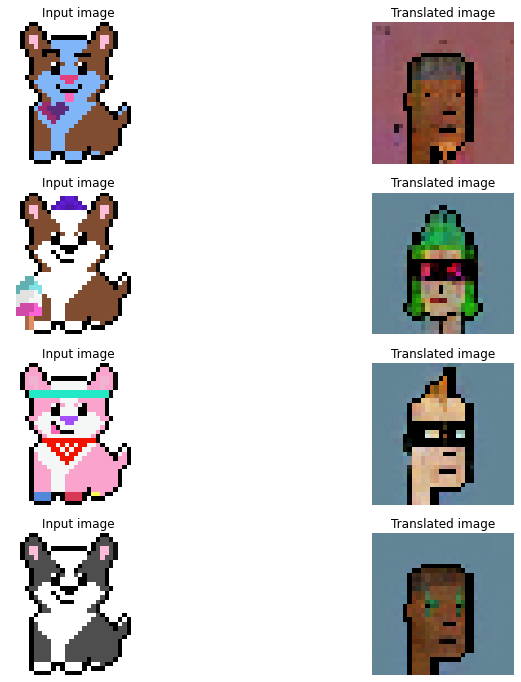

207/207 [==============================] - 115s 558ms/step - G_loss: 1.9587 - F_loss: 2.0844 - D_X_loss: 0.1297 - D_Y_loss: 0.1320
Epoch 113/200
207/207 [==============================] - ETA: 0s - G_loss: 2.0189 - F_loss: 2.0976 - D_X_loss: 0.1410 - D_Y_loss: 0.1369

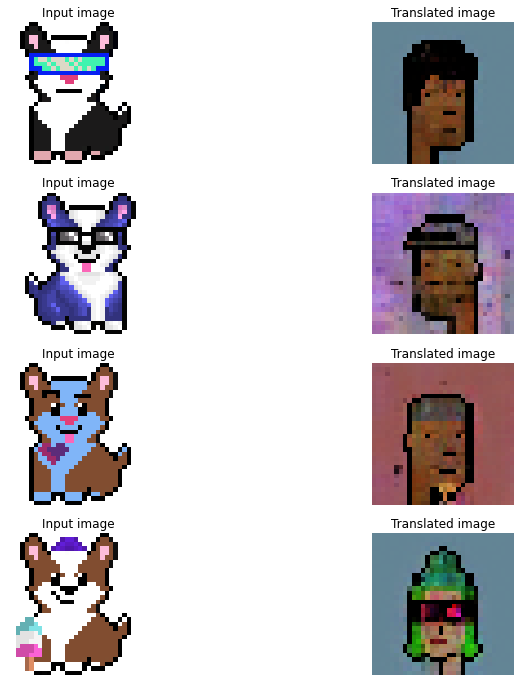

207/207 [==============================] - 115s 556ms/step - G_loss: 2.0130 - F_loss: 2.0955 - D_X_loss: 0.1415 - D_Y_loss: 0.1385
Epoch 114/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9600 - F_loss: 2.0862 - D_X_loss: 0.1345 - D_Y_loss: 0.1282

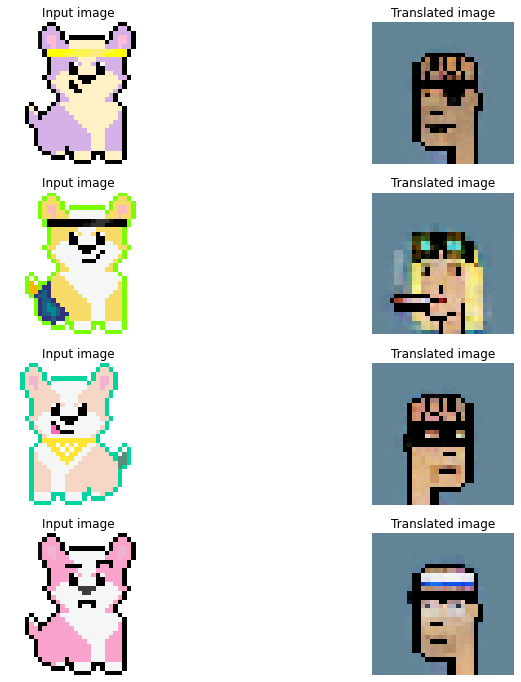

207/207 [==============================] - 115s 555ms/step - G_loss: 1.9662 - F_loss: 2.0879 - D_X_loss: 0.1340 - D_Y_loss: 0.1297
Epoch 115/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9378 - F_loss: 2.1098 - D_X_loss: 0.1330 - D_Y_loss: 0.1364

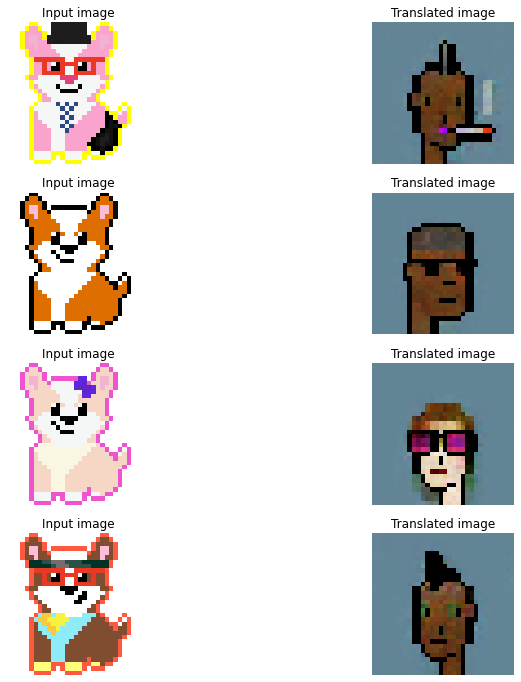

207/207 [==============================] - 115s 555ms/step - G_loss: 1.9333 - F_loss: 2.1137 - D_X_loss: 0.1326 - D_Y_loss: 0.1375
Epoch 116/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9230 - F_loss: 2.0945 - D_X_loss: 0.1329 - D_Y_loss: 0.1320

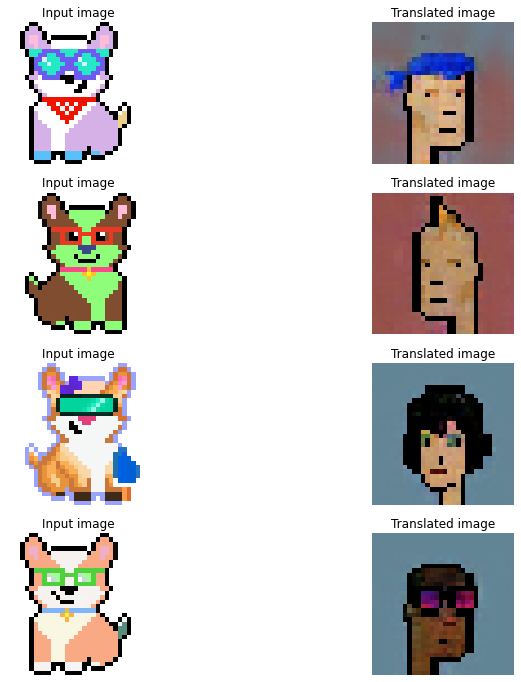

207/207 [==============================] - 115s 557ms/step - G_loss: 1.9292 - F_loss: 2.0920 - D_X_loss: 0.1327 - D_Y_loss: 0.1317
Epoch 117/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8271 - F_loss: 2.0498 - D_X_loss: 0.1370 - D_Y_loss: 0.1386

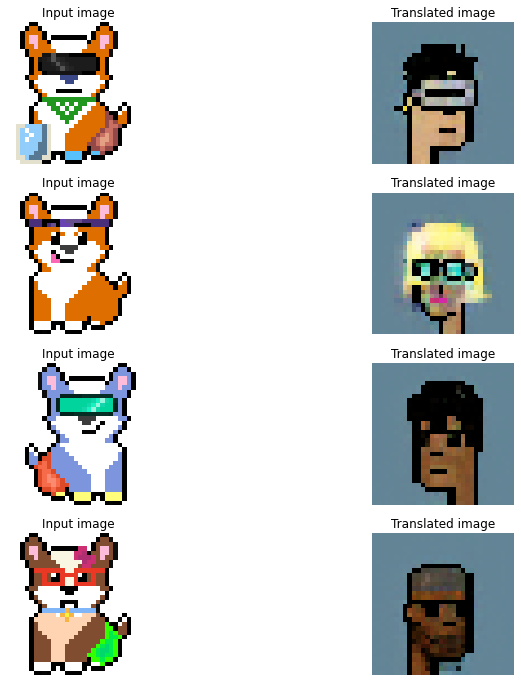

207/207 [==============================] - 123s 594ms/step - G_loss: 1.8214 - F_loss: 2.0477 - D_X_loss: 0.1366 - D_Y_loss: 0.1396
Epoch 118/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8634 - F_loss: 2.0919 - D_X_loss: 0.1330 - D_Y_loss: 0.1401

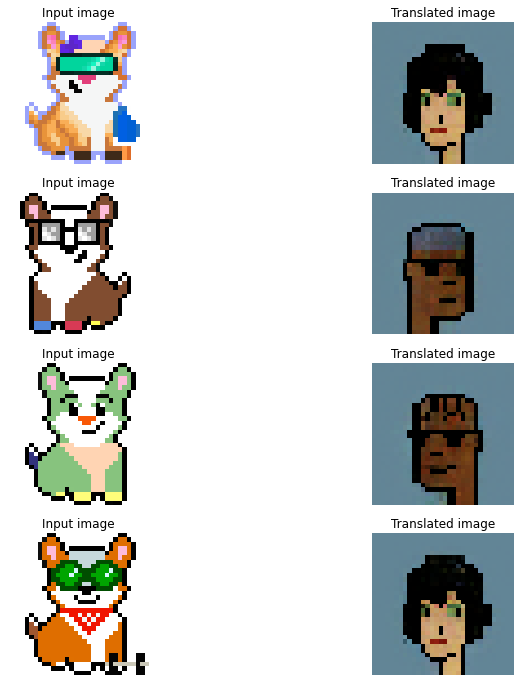

207/207 [==============================] - 123s 596ms/step - G_loss: 1.8590 - F_loss: 2.0898 - D_X_loss: 0.1330 - D_Y_loss: 0.1414
Epoch 119/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8524 - F_loss: 2.0525 - D_X_loss: 0.1398 - D_Y_loss: 0.1484

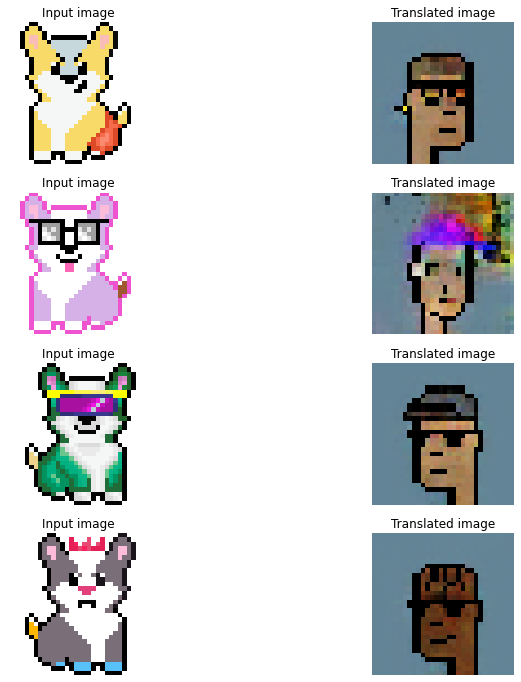

207/207 [==============================] - 127s 614ms/step - G_loss: 1.8473 - F_loss: 2.0484 - D_X_loss: 0.1401 - D_Y_loss: 0.1495
Epoch 120/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9110 - F_loss: 2.0208 - D_X_loss: 0.1399 - D_Y_loss: 0.1469

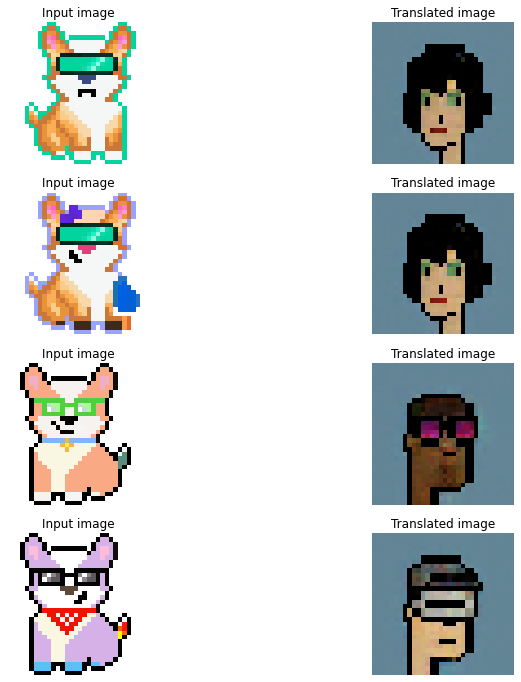

207/207 [==============================] - 127s 614ms/step - G_loss: 1.9113 - F_loss: 2.0237 - D_X_loss: 0.1395 - D_Y_loss: 0.1465
Epoch 121/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8711 - F_loss: 2.0821 - D_X_loss: 0.1305 - D_Y_loss: 0.1450

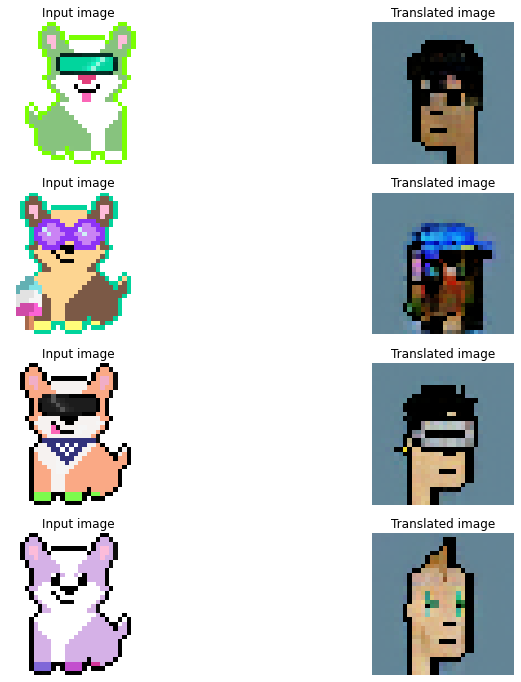

207/207 [==============================] - 127s 613ms/step - G_loss: 1.8724 - F_loss: 2.0762 - D_X_loss: 0.1312 - D_Y_loss: 0.1445
Epoch 122/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8749 - F_loss: 2.0422 - D_X_loss: 0.1372 - D_Y_loss: 0.1374

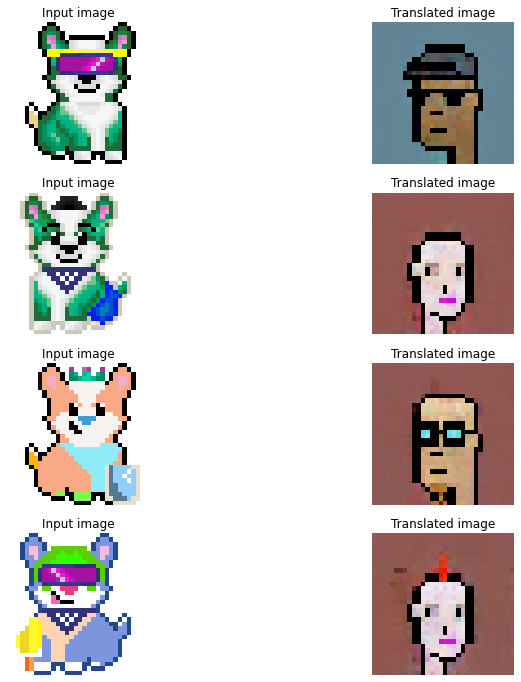

207/207 [==============================] - 127s 612ms/step - G_loss: 1.8732 - F_loss: 2.0476 - D_X_loss: 0.1368 - D_Y_loss: 0.1368
Epoch 123/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9105 - F_loss: 2.0078 - D_X_loss: 0.1441 - D_Y_loss: 0.1331

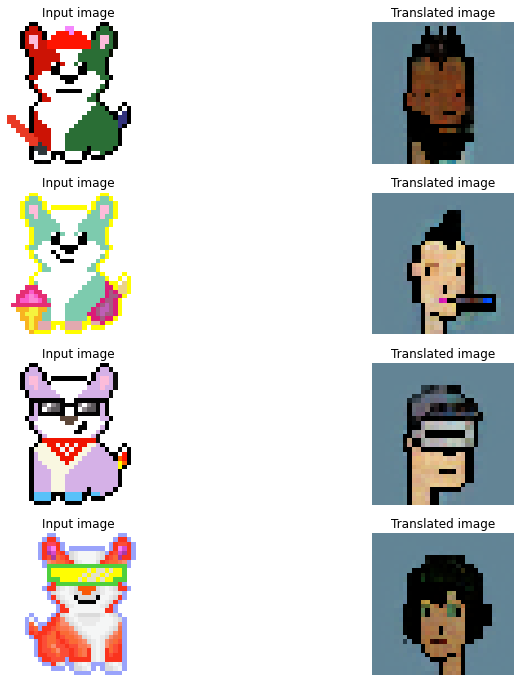

207/207 [==============================] - 126s 609ms/step - G_loss: 1.9067 - F_loss: 2.0091 - D_X_loss: 0.1436 - D_Y_loss: 0.1327
Epoch 124/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8985 - F_loss: 1.9851 - D_X_loss: 0.1486 - D_Y_loss: 0.1405

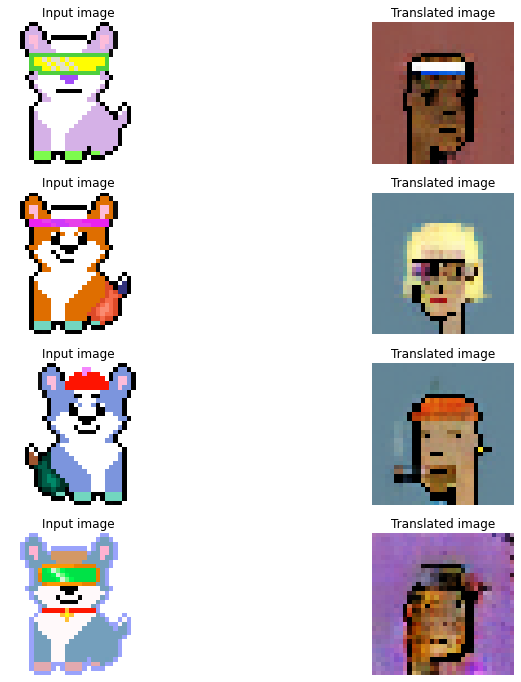

207/207 [==============================] - 120s 581ms/step - G_loss: 1.8931 - F_loss: 1.9850 - D_X_loss: 0.1480 - D_Y_loss: 0.1416
Epoch 125/200
207/207 [==============================] - ETA: 0s - G_loss: 1.9274 - F_loss: 1.9965 - D_X_loss: 0.1356 - D_Y_loss: 0.1353

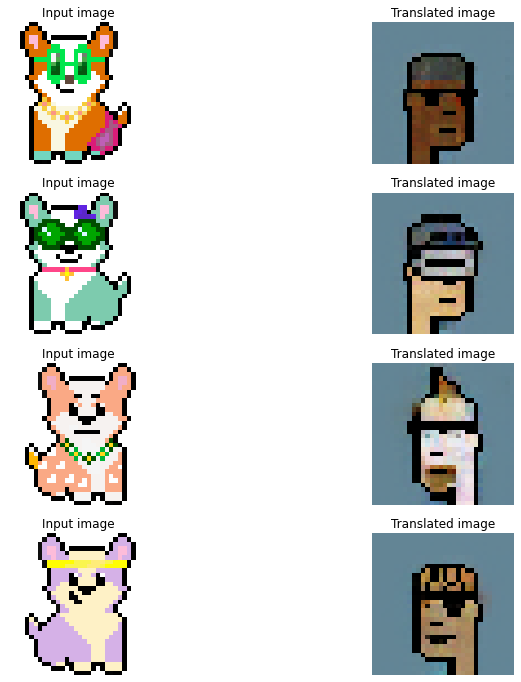

207/207 [==============================] - 120s 579ms/step - G_loss: 1.9226 - F_loss: 2.0014 - D_X_loss: 0.1350 - D_Y_loss: 0.1365
Epoch 126/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8203 - F_loss: 2.0288 - D_X_loss: 0.1408 - D_Y_loss: 0.1507

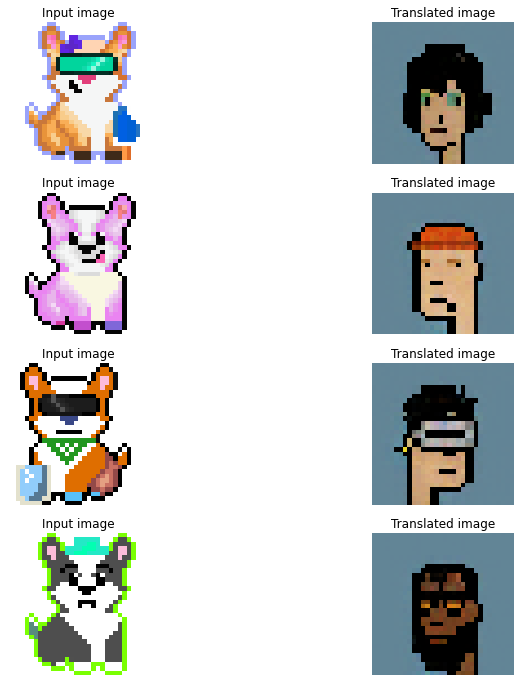

207/207 [==============================] - 120s 581ms/step - G_loss: 1.8214 - F_loss: 2.0260 - D_X_loss: 0.1411 - D_Y_loss: 0.1510
Epoch 127/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8887 - F_loss: 1.9913 - D_X_loss: 0.1387 - D_Y_loss: 0.1425

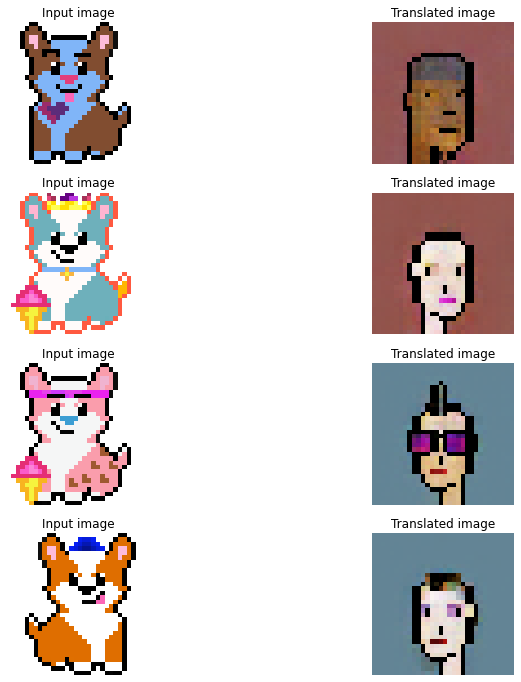

207/207 [==============================] - 119s 577ms/step - G_loss: 1.8834 - F_loss: 1.9964 - D_X_loss: 0.1387 - D_Y_loss: 0.1437
Epoch 128/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8342 - F_loss: 1.9905 - D_X_loss: 0.1434 - D_Y_loss: 0.1442

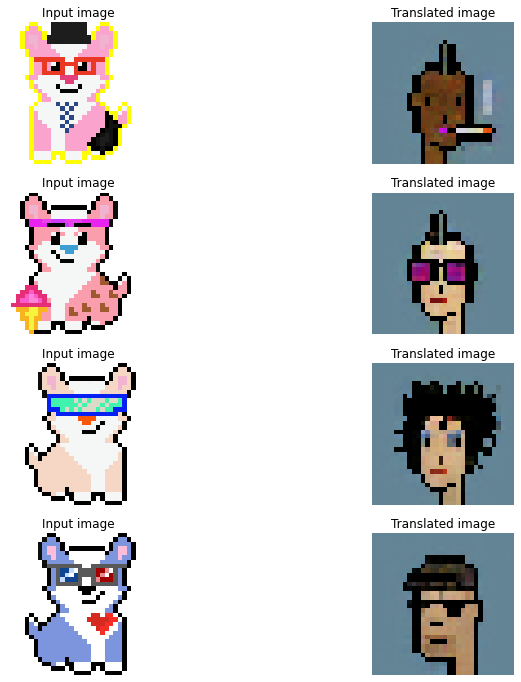

207/207 [==============================] - 119s 575ms/step - G_loss: 1.8433 - F_loss: 1.9978 - D_X_loss: 0.1429 - D_Y_loss: 0.1436
Epoch 129/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7438 - F_loss: 1.9510 - D_X_loss: 0.1500 - D_Y_loss: 0.1493

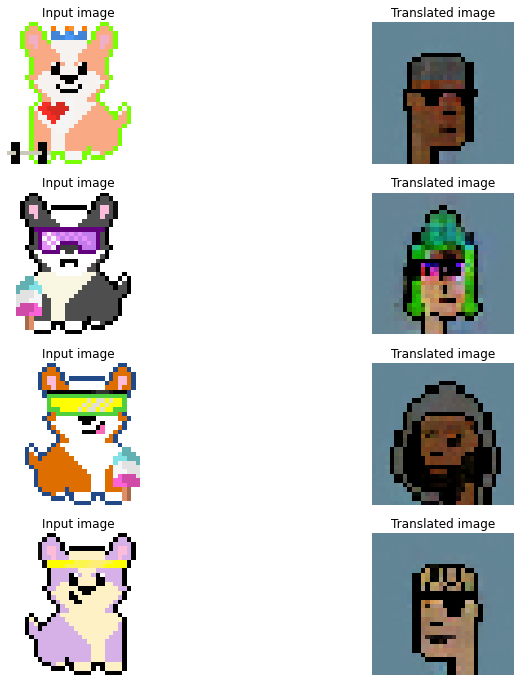

207/207 [==============================] - 119s 574ms/step - G_loss: 1.7466 - F_loss: 1.9452 - D_X_loss: 0.1511 - D_Y_loss: 0.1490
Epoch 130/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7893 - F_loss: 1.9601 - D_X_loss: 0.1521 - D_Y_loss: 0.1508

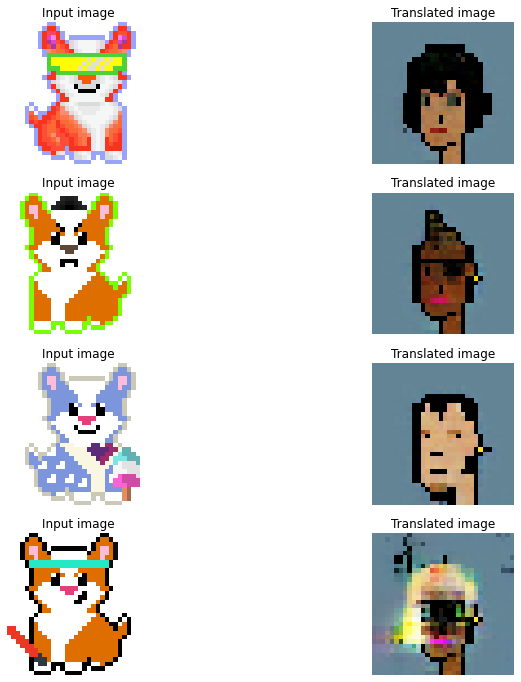

207/207 [==============================] - 119s 573ms/step - G_loss: 1.7842 - F_loss: 1.9621 - D_X_loss: 0.1522 - D_Y_loss: 0.1518
Epoch 131/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8242 - F_loss: 1.9479 - D_X_loss: 0.1420 - D_Y_loss: 0.1497

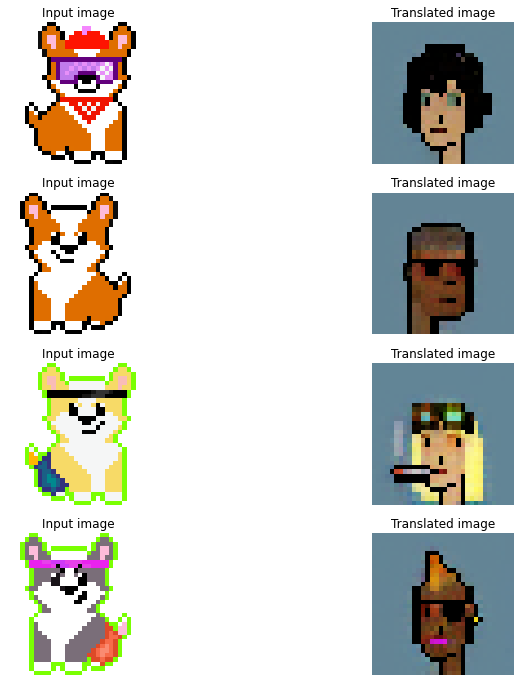

207/207 [==============================] - 118s 572ms/step - G_loss: 1.8193 - F_loss: 1.9548 - D_X_loss: 0.1413 - D_Y_loss: 0.1513
Epoch 132/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6859 - F_loss: 1.9359 - D_X_loss: 0.1483 - D_Y_loss: 0.1446

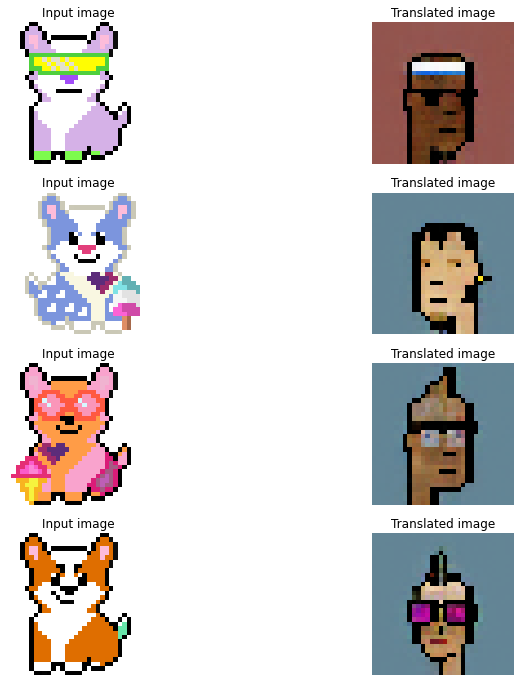

207/207 [==============================] - 118s 571ms/step - G_loss: 1.6821 - F_loss: 1.9354 - D_X_loss: 0.1491 - D_Y_loss: 0.1447
Epoch 133/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7830 - F_loss: 1.9705 - D_X_loss: 0.1479 - D_Y_loss: 0.1436

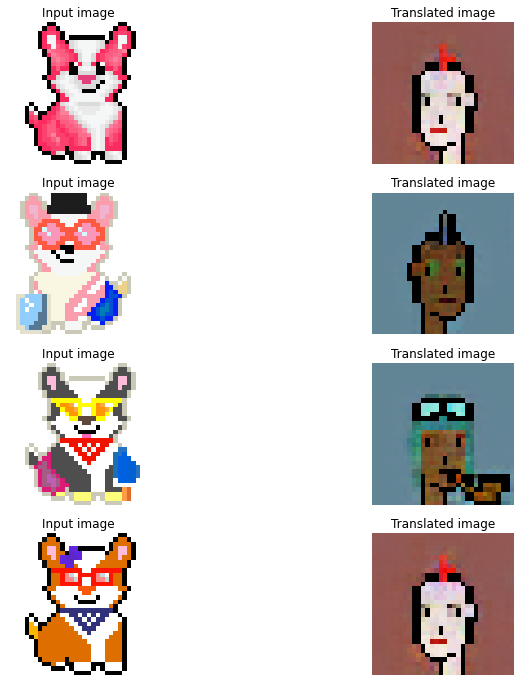

207/207 [==============================] - 118s 570ms/step - G_loss: 1.7772 - F_loss: 1.9659 - D_X_loss: 0.1481 - D_Y_loss: 0.1448
Epoch 134/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7707 - F_loss: 1.9542 - D_X_loss: 0.1410 - D_Y_loss: 0.1506

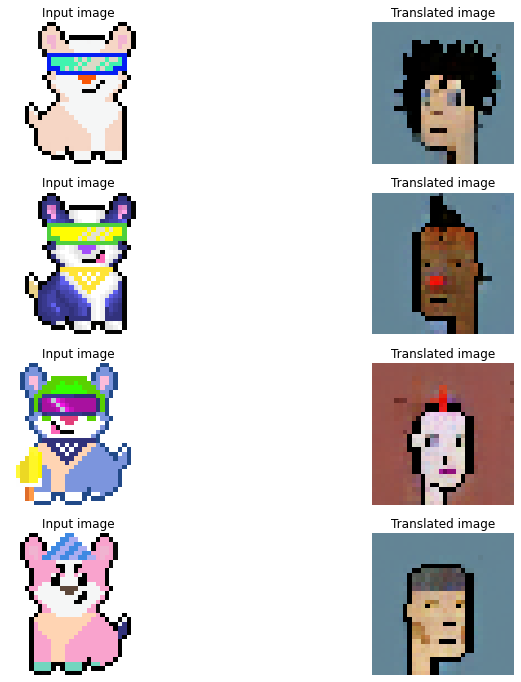

207/207 [==============================] - 118s 568ms/step - G_loss: 1.7692 - F_loss: 1.9503 - D_X_loss: 0.1411 - D_Y_loss: 0.1502
Epoch 135/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7923 - F_loss: 1.9434 - D_X_loss: 0.1425 - D_Y_loss: 0.1512

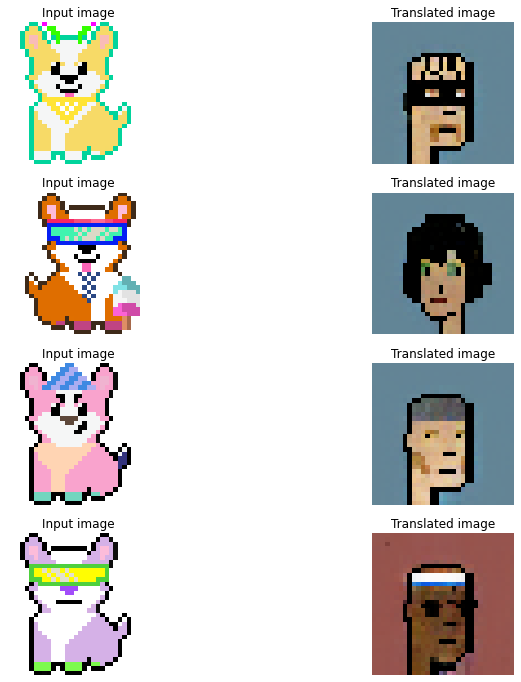

207/207 [==============================] - 117s 567ms/step - G_loss: 1.7891 - F_loss: 1.9404 - D_X_loss: 0.1432 - D_Y_loss: 0.1507
Epoch 136/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8600 - F_loss: 1.9413 - D_X_loss: 0.1485 - D_Y_loss: 0.1411

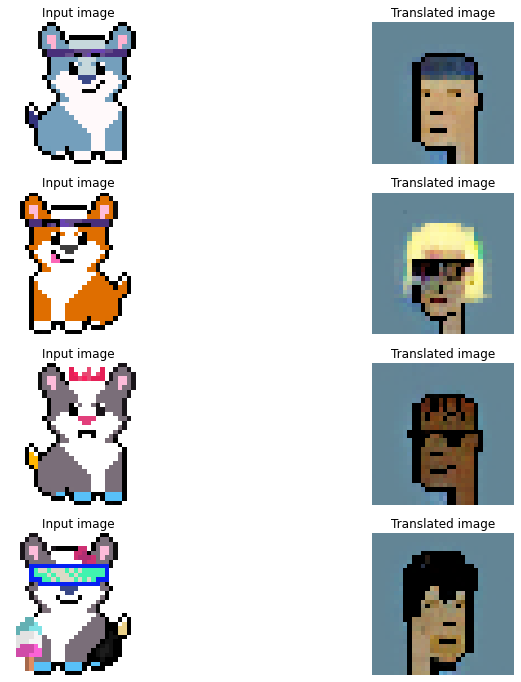

207/207 [==============================] - 117s 566ms/step - G_loss: 1.8687 - F_loss: 1.9384 - D_X_loss: 0.1490 - D_Y_loss: 0.1406
Epoch 137/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8837 - F_loss: 1.8909 - D_X_loss: 0.1461 - D_Y_loss: 0.1477

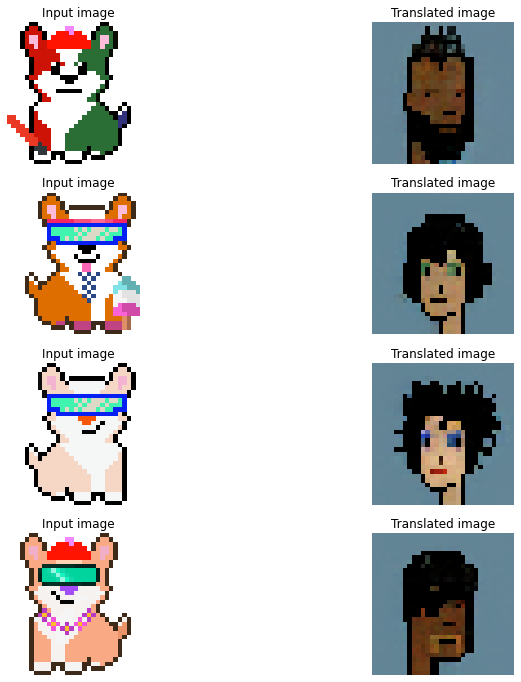

207/207 [==============================] - 117s 566ms/step - G_loss: 1.8884 - F_loss: 1.8921 - D_X_loss: 0.1456 - D_Y_loss: 0.1477
Epoch 138/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7548 - F_loss: 1.8429 - D_X_loss: 0.1557 - D_Y_loss: 0.1552

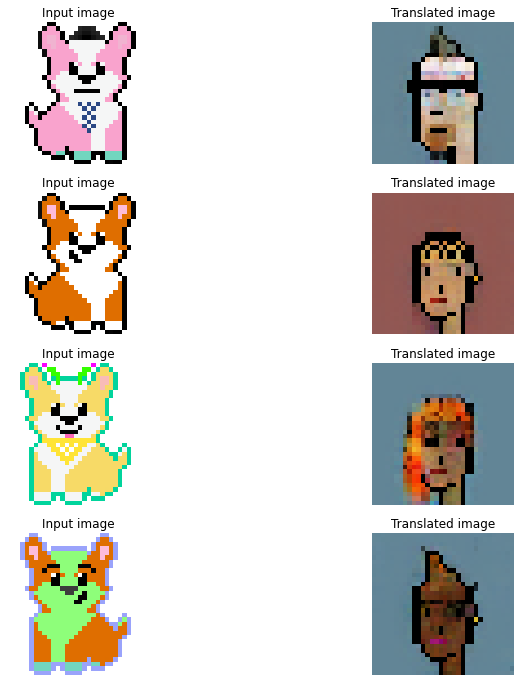

207/207 [==============================] - 117s 564ms/step - G_loss: 1.7571 - F_loss: 1.8478 - D_X_loss: 0.1553 - D_Y_loss: 0.1546
Epoch 139/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8320 - F_loss: 1.9022 - D_X_loss: 0.1530 - D_Y_loss: 0.1502

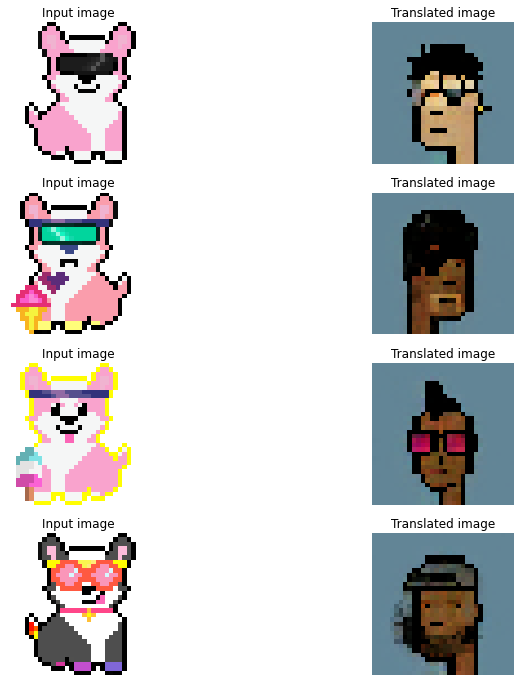

207/207 [==============================] - 116s 562ms/step - G_loss: 1.8344 - F_loss: 1.8980 - D_X_loss: 0.1534 - D_Y_loss: 0.1495
Epoch 140/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8286 - F_loss: 1.9072 - D_X_loss: 0.1463 - D_Y_loss: 0.1502

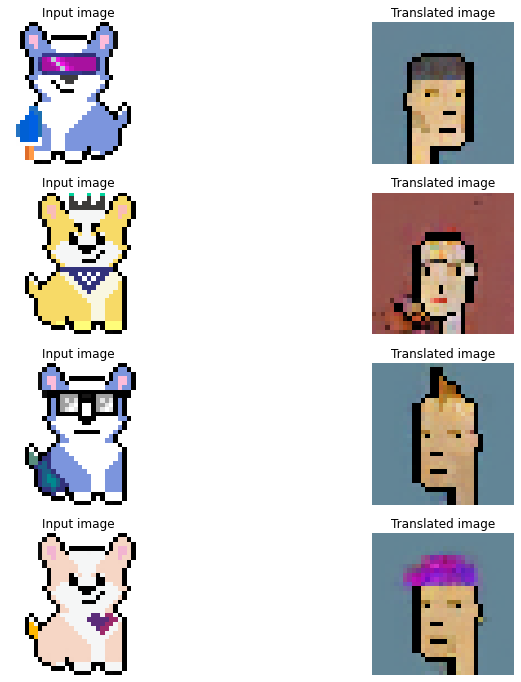

207/207 [==============================] - 116s 562ms/step - G_loss: 1.8223 - F_loss: 1.9033 - D_X_loss: 0.1463 - D_Y_loss: 0.1515
Epoch 141/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7898 - F_loss: 1.9038 - D_X_loss: 0.1465 - D_Y_loss: 0.1471

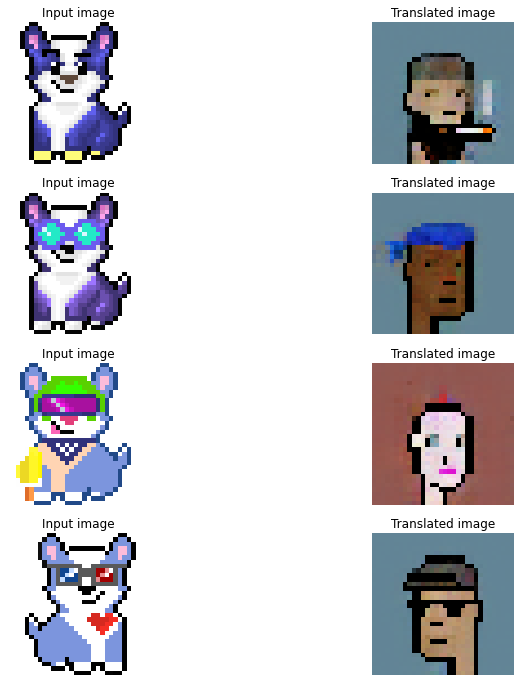

207/207 [==============================] - 116s 562ms/step - G_loss: 1.7840 - F_loss: 1.9010 - D_X_loss: 0.1467 - D_Y_loss: 0.1489
Epoch 142/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6807 - F_loss: 1.8320 - D_X_loss: 0.1512 - D_Y_loss: 0.1482

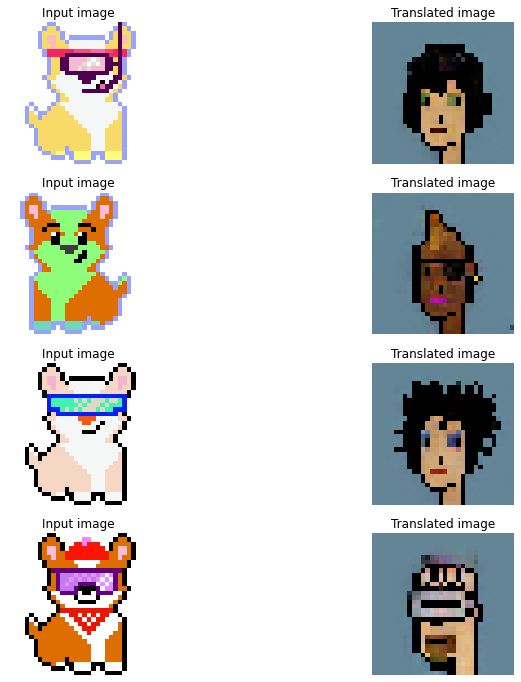

207/207 [==============================] - 116s 560ms/step - G_loss: 1.6798 - F_loss: 1.8295 - D_X_loss: 0.1521 - D_Y_loss: 0.1475
Epoch 143/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8809 - F_loss: 1.8532 - D_X_loss: 0.1472 - D_Y_loss: 0.1370

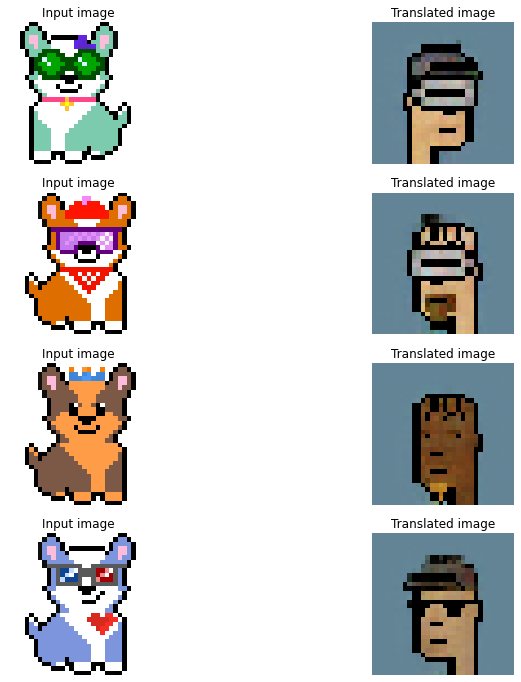

207/207 [==============================] - 116s 559ms/step - G_loss: 1.8754 - F_loss: 1.8562 - D_X_loss: 0.1475 - D_Y_loss: 0.1374
Epoch 144/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6113 - F_loss: 1.8408 - D_X_loss: 0.1554 - D_Y_loss: 0.1582

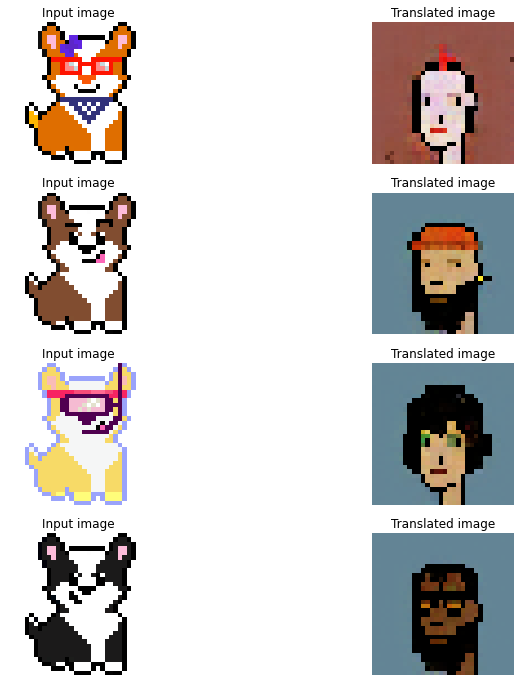

207/207 [==============================] - 115s 556ms/step - G_loss: 1.6097 - F_loss: 1.8452 - D_X_loss: 0.1547 - D_Y_loss: 0.1577
Epoch 145/200
207/207 [==============================] - ETA: 0s - G_loss: 1.8629 - F_loss: 1.9199 - D_X_loss: 0.1358 - D_Y_loss: 0.1381

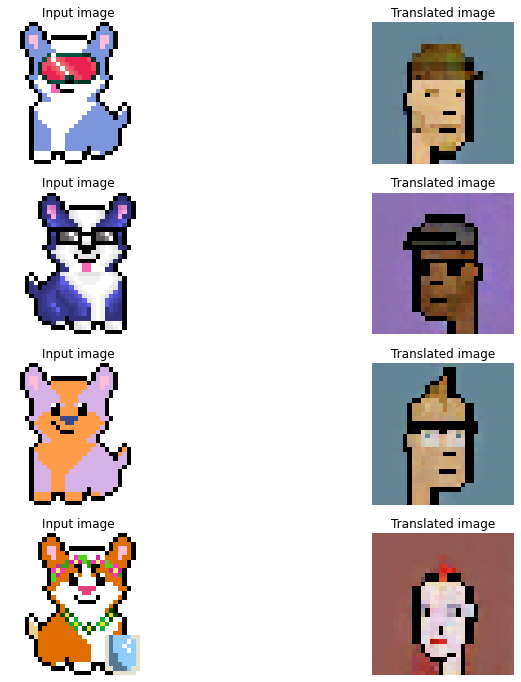

207/207 [==============================] - 116s 562ms/step - G_loss: 1.8797 - F_loss: 1.9196 - D_X_loss: 0.1356 - D_Y_loss: 0.1374
Epoch 146/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7691 - F_loss: 1.8683 - D_X_loss: 0.1391 - D_Y_loss: 0.1494

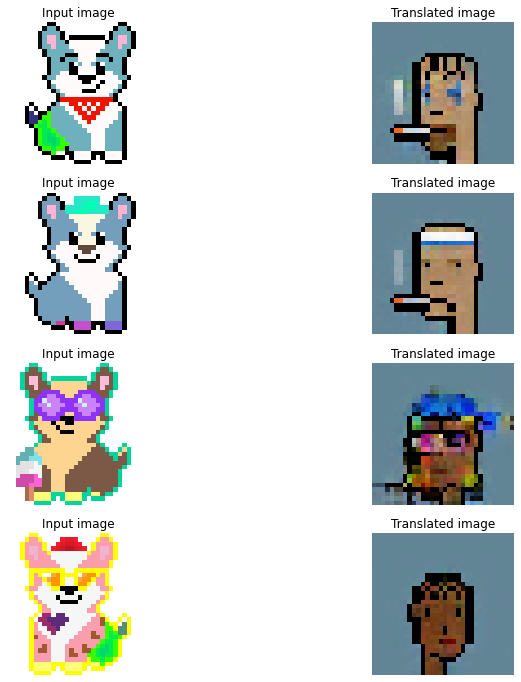

207/207 [==============================] - 121s 584ms/step - G_loss: 1.7626 - F_loss: 1.8645 - D_X_loss: 0.1403 - D_Y_loss: 0.1505
Epoch 147/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7642 - F_loss: 1.8007 - D_X_loss: 0.1515 - D_Y_loss: 0.1549

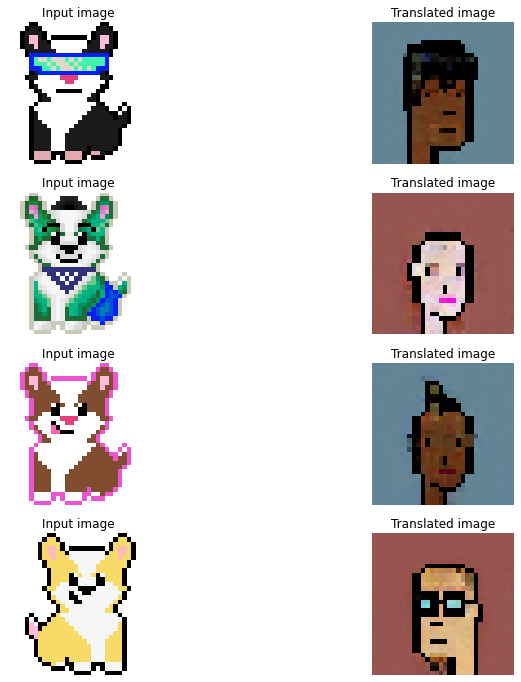

207/207 [==============================] - 121s 582ms/step - G_loss: 1.7576 - F_loss: 1.7952 - D_X_loss: 0.1533 - D_Y_loss: 0.1562
Epoch 148/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7300 - F_loss: 1.8039 - D_X_loss: 0.1597 - D_Y_loss: 0.1509

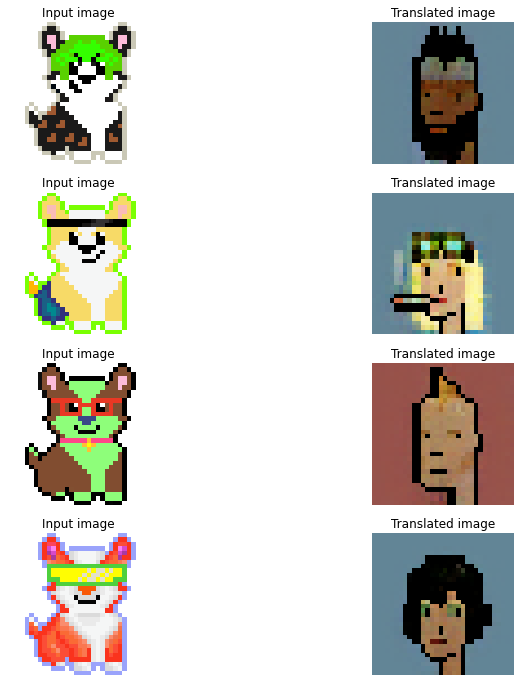

207/207 [==============================] - 120s 580ms/step - G_loss: 1.7245 - F_loss: 1.8011 - D_X_loss: 0.1600 - D_Y_loss: 0.1519
Epoch 149/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7918 - F_loss: 1.8182 - D_X_loss: 0.1437 - D_Y_loss: 0.1490

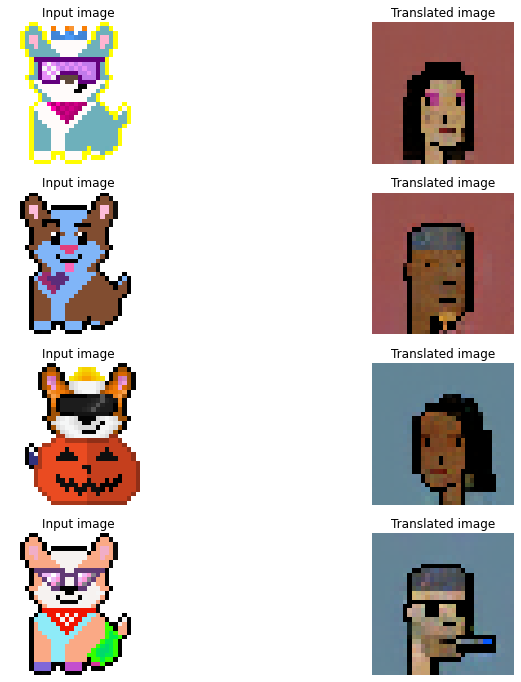

207/207 [==============================] - 120s 579ms/step - G_loss: 1.7891 - F_loss: 1.8202 - D_X_loss: 0.1432 - D_Y_loss: 0.1485
Epoch 150/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7460 - F_loss: 1.7765 - D_X_loss: 0.1468 - D_Y_loss: 0.1514

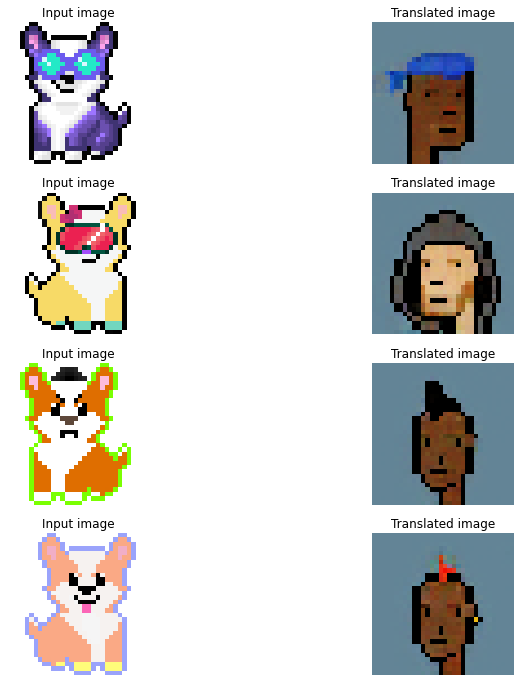

207/207 [==============================] - 120s 579ms/step - G_loss: 1.7414 - F_loss: 1.7772 - D_X_loss: 0.1466 - D_Y_loss: 0.1516
Epoch 151/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7263 - F_loss: 1.8064 - D_X_loss: 0.1475 - D_Y_loss: 0.1513

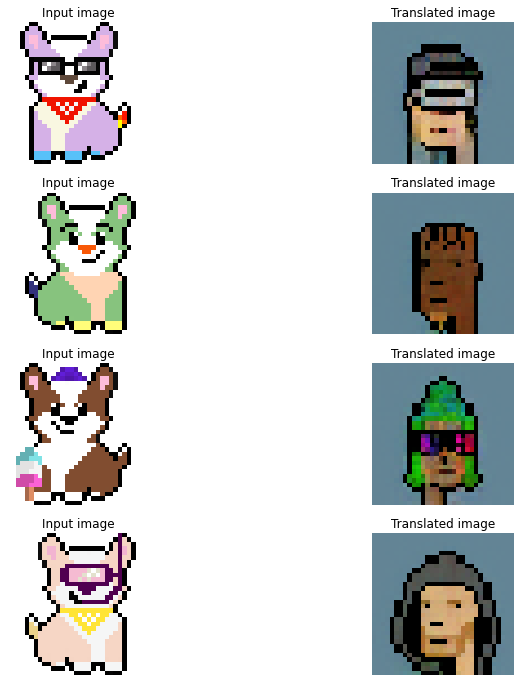

207/207 [==============================] - 119s 577ms/step - G_loss: 1.7248 - F_loss: 1.8008 - D_X_loss: 0.1486 - D_Y_loss: 0.1509
Epoch 152/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6654 - F_loss: 1.8256 - D_X_loss: 0.1427 - D_Y_loss: 0.1562

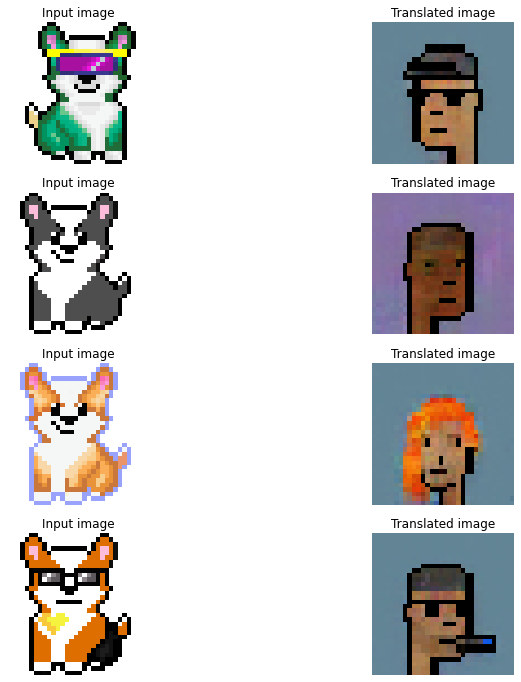

207/207 [==============================] - 119s 575ms/step - G_loss: 1.6621 - F_loss: 1.8282 - D_X_loss: 0.1423 - D_Y_loss: 0.1567
Epoch 153/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6788 - F_loss: 1.7967 - D_X_loss: 0.1492 - D_Y_loss: 0.1589

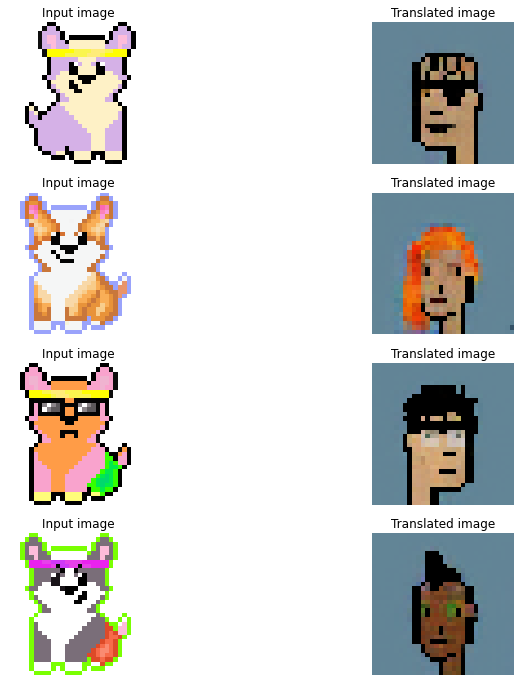

207/207 [==============================] - 119s 574ms/step - G_loss: 1.6784 - F_loss: 1.7946 - D_X_loss: 0.1489 - D_Y_loss: 0.1583
Epoch 154/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7245 - F_loss: 1.7509 - D_X_loss: 0.1507 - D_Y_loss: 0.1524

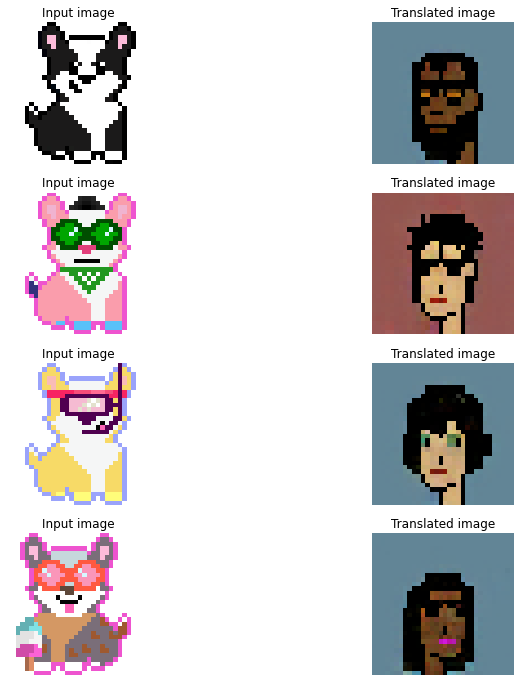

207/207 [==============================] - 119s 573ms/step - G_loss: 1.7238 - F_loss: 1.7510 - D_X_loss: 0.1503 - D_Y_loss: 0.1531
Epoch 155/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7233 - F_loss: 1.7446 - D_X_loss: 0.1521 - D_Y_loss: 0.1499

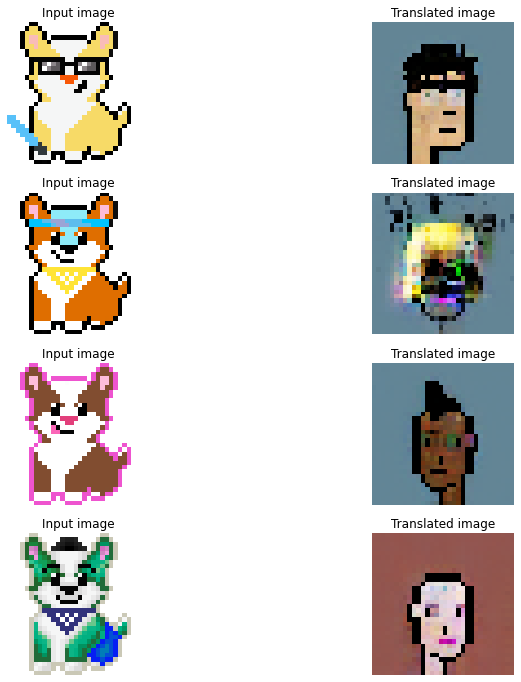

207/207 [==============================] - 118s 569ms/step - G_loss: 1.7239 - F_loss: 1.7401 - D_X_loss: 0.1527 - D_Y_loss: 0.1498
Epoch 156/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7926 - F_loss: 1.7457 - D_X_loss: 0.1540 - D_Y_loss: 0.1484

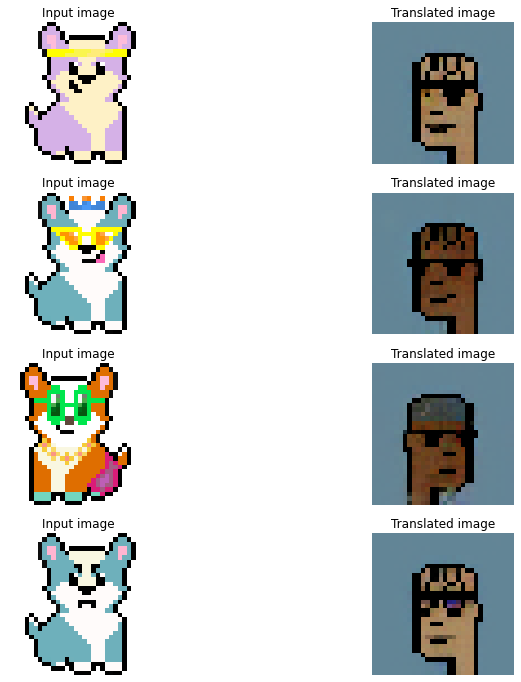

207/207 [==============================] - 117s 567ms/step - G_loss: 1.7918 - F_loss: 1.7442 - D_X_loss: 0.1536 - D_Y_loss: 0.1482
Epoch 157/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6370 - F_loss: 1.7711 - D_X_loss: 0.1495 - D_Y_loss: 0.1522

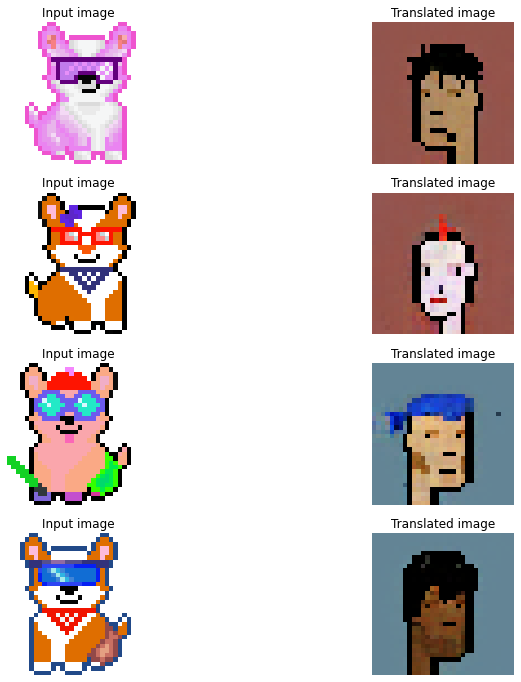

207/207 [==============================] - 117s 566ms/step - G_loss: 1.6346 - F_loss: 1.7657 - D_X_loss: 0.1501 - D_Y_loss: 0.1518
Epoch 158/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5922 - F_loss: 1.7581 - D_X_loss: 0.1502 - D_Y_loss: 0.1608

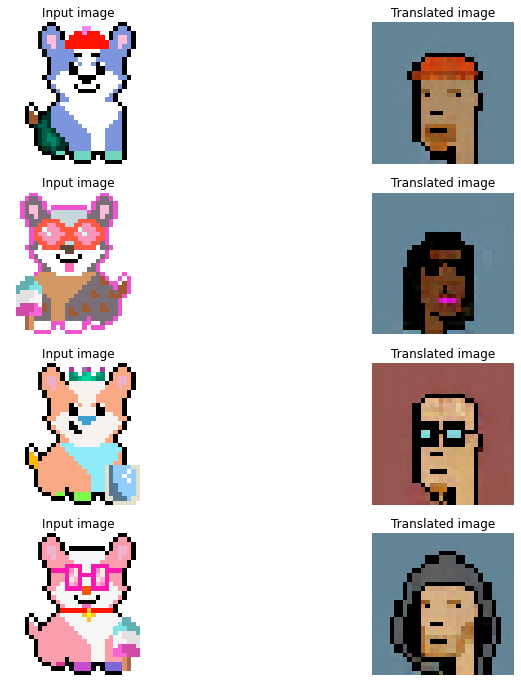

207/207 [==============================] - 117s 566ms/step - G_loss: 1.5866 - F_loss: 1.7564 - D_X_loss: 0.1497 - D_Y_loss: 0.1617
Epoch 159/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6022 - F_loss: 1.7681 - D_X_loss: 0.1480 - D_Y_loss: 0.1501

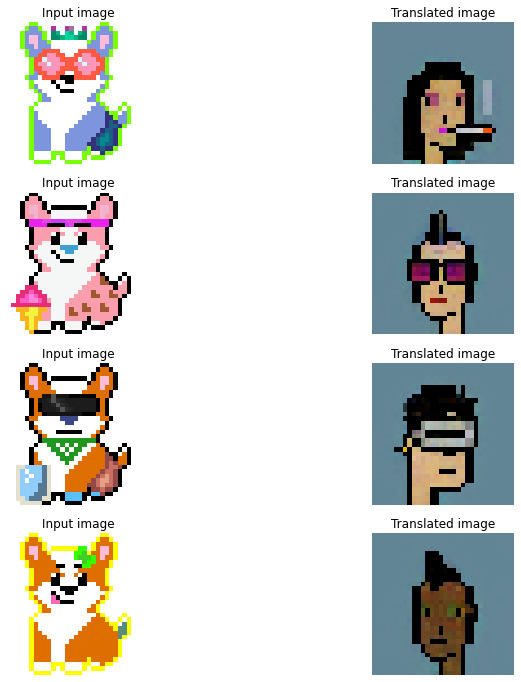

207/207 [==============================] - 117s 565ms/step - G_loss: 1.6033 - F_loss: 1.7674 - D_X_loss: 0.1485 - D_Y_loss: 0.1497
Epoch 160/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5882 - F_loss: 1.7825 - D_X_loss: 0.1542 - D_Y_loss: 0.1650

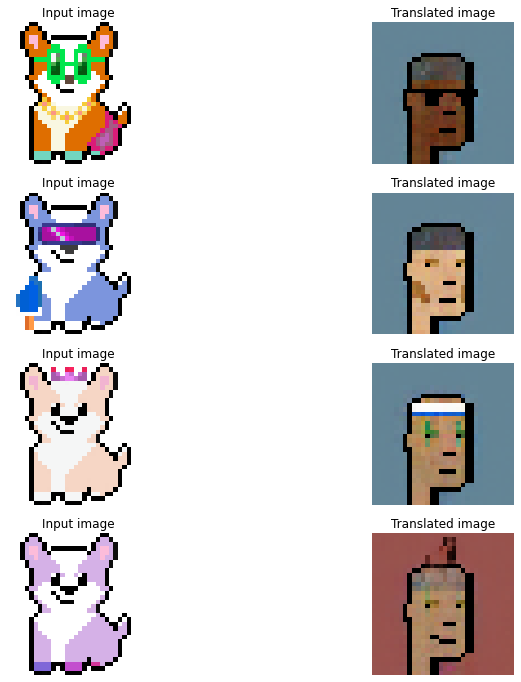

207/207 [==============================] - 117s 565ms/step - G_loss: 1.5876 - F_loss: 1.7846 - D_X_loss: 0.1536 - D_Y_loss: 0.1648
Epoch 161/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6605 - F_loss: 1.7776 - D_X_loss: 0.1528 - D_Y_loss: 0.1508

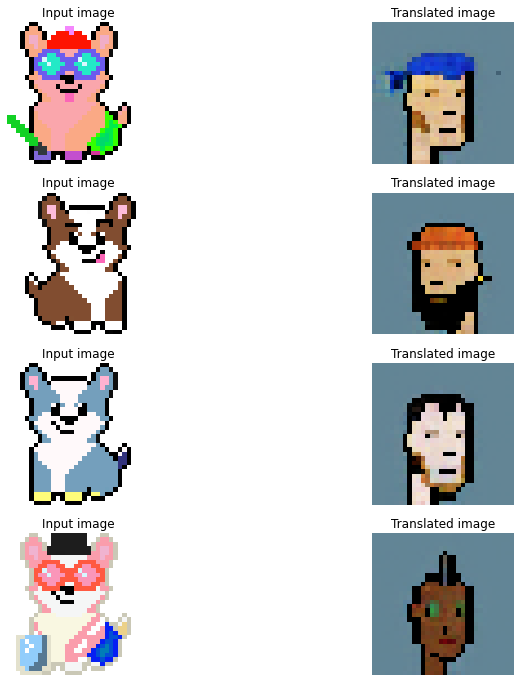

207/207 [==============================] - 117s 565ms/step - G_loss: 1.6625 - F_loss: 1.7738 - D_X_loss: 0.1526 - D_Y_loss: 0.1505
Epoch 162/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6667 - F_loss: 1.7642 - D_X_loss: 0.1473 - D_Y_loss: 0.1576

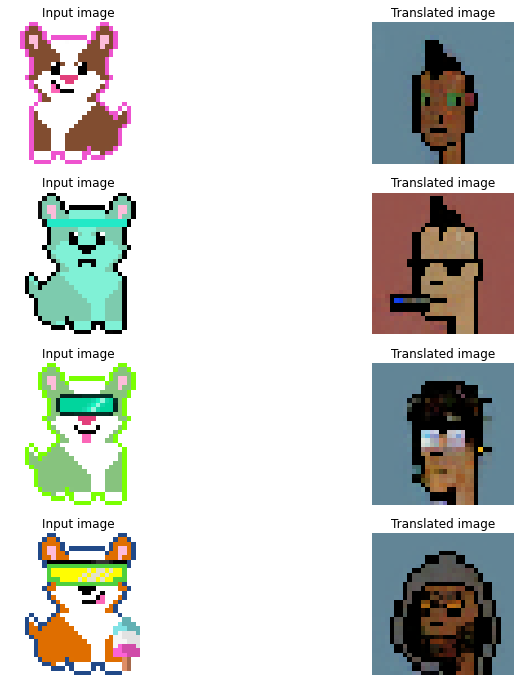

207/207 [==============================] - 117s 565ms/step - G_loss: 1.6621 - F_loss: 1.7666 - D_X_loss: 0.1470 - D_Y_loss: 0.1586
Epoch 163/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6709 - F_loss: 1.7055 - D_X_loss: 0.1543 - D_Y_loss: 0.1525

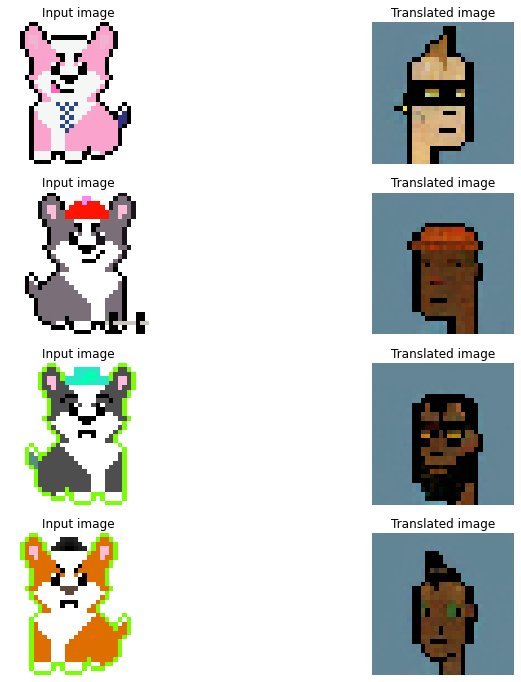

207/207 [==============================] - 117s 563ms/step - G_loss: 1.6665 - F_loss: 1.7032 - D_X_loss: 0.1541 - D_Y_loss: 0.1531
Epoch 164/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6522 - F_loss: 1.7099 - D_X_loss: 0.1560 - D_Y_loss: 0.1587

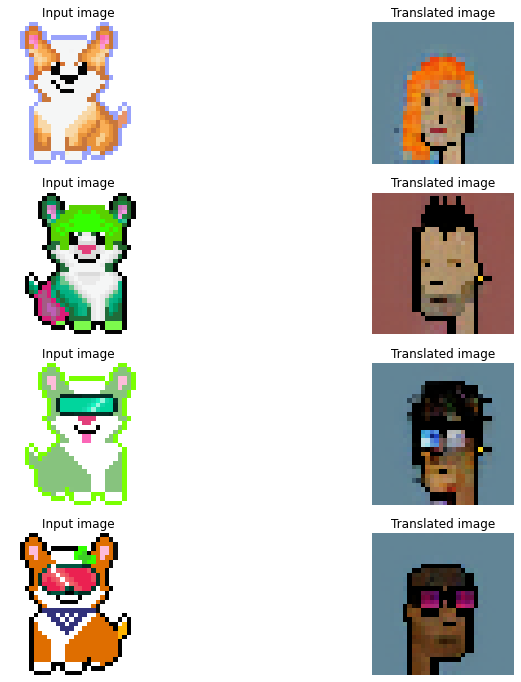

207/207 [==============================] - 116s 561ms/step - G_loss: 1.6631 - F_loss: 1.7087 - D_X_loss: 0.1554 - D_Y_loss: 0.1580
Epoch 165/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6830 - F_loss: 1.6869 - D_X_loss: 0.1539 - D_Y_loss: 0.1548

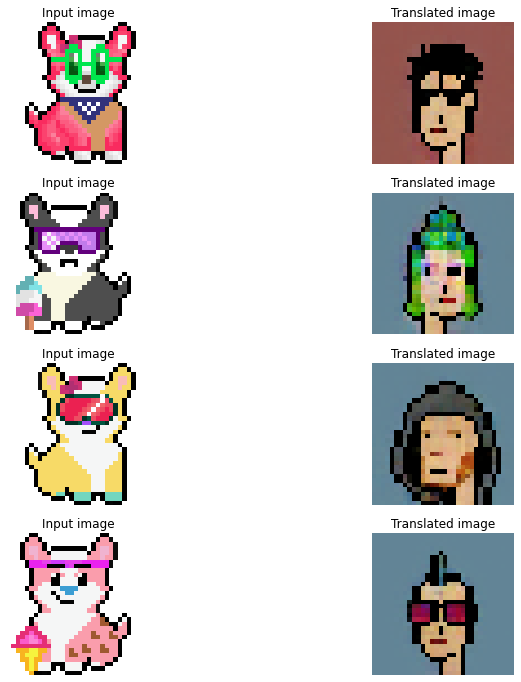

207/207 [==============================] - 116s 559ms/step - G_loss: 1.6794 - F_loss: 1.6951 - D_X_loss: 0.1535 - D_Y_loss: 0.1551
Epoch 166/200
207/207 [==============================] - ETA: 0s - G_loss: 1.7202 - F_loss: 1.7118 - D_X_loss: 0.1497 - D_Y_loss: 0.1499

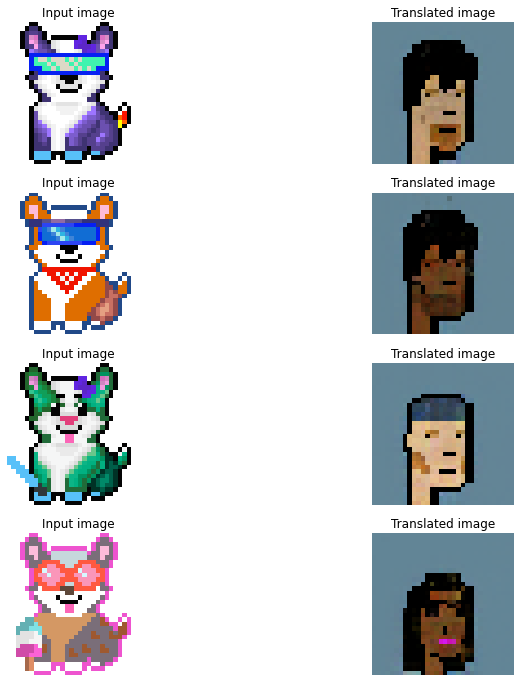

207/207 [==============================] - 116s 558ms/step - G_loss: 1.7186 - F_loss: 1.7126 - D_X_loss: 0.1496 - D_Y_loss: 0.1494
Epoch 167/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6525 - F_loss: 1.7094 - D_X_loss: 0.1555 - D_Y_loss: 0.1651

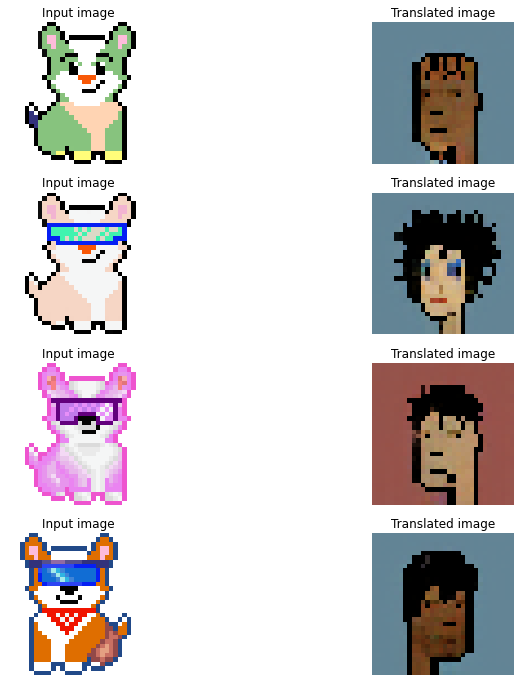

207/207 [==============================] - 115s 557ms/step - G_loss: 1.6479 - F_loss: 1.7095 - D_X_loss: 0.1556 - D_Y_loss: 0.1665
Epoch 168/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6386 - F_loss: 1.7272 - D_X_loss: 0.1513 - D_Y_loss: 0.1629

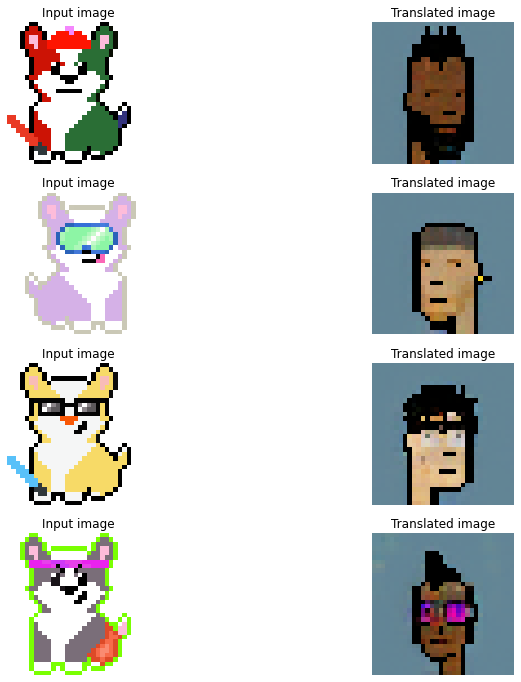

207/207 [==============================] - 115s 556ms/step - G_loss: 1.6343 - F_loss: 1.7282 - D_X_loss: 0.1514 - D_Y_loss: 0.1636
Epoch 169/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6289 - F_loss: 1.7794 - D_X_loss: 0.1500 - D_Y_loss: 0.1542

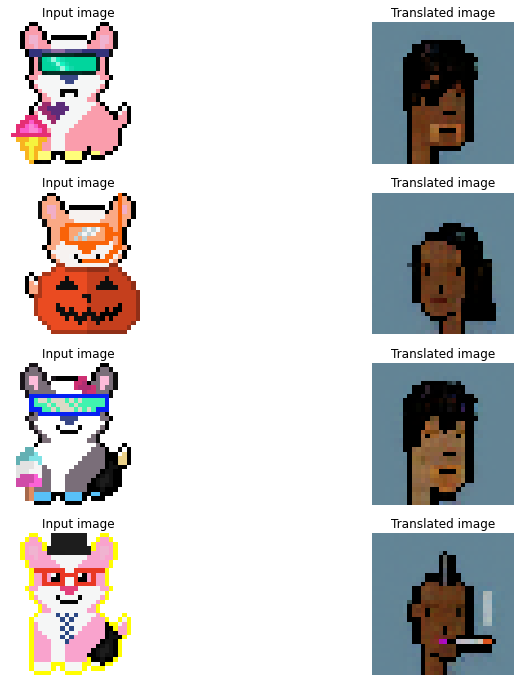

207/207 [==============================] - 115s 555ms/step - G_loss: 1.6291 - F_loss: 1.7732 - D_X_loss: 0.1519 - D_Y_loss: 0.1535
Epoch 170/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6476 - F_loss: 1.7455 - D_X_loss: 0.1549 - D_Y_loss: 0.1575

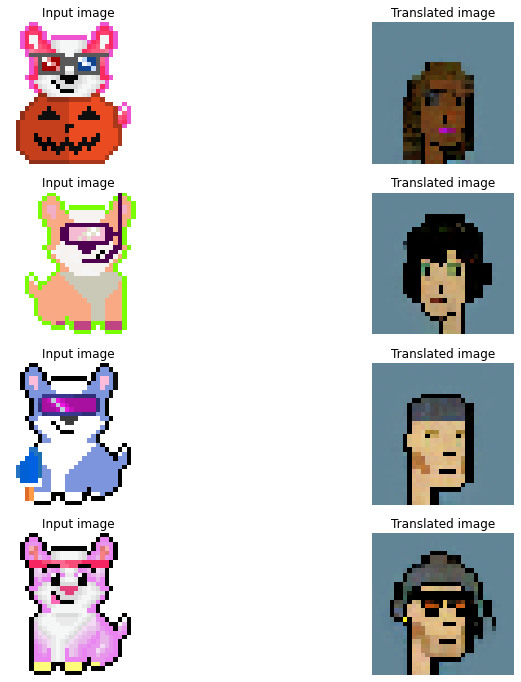

207/207 [==============================] - 115s 554ms/step - G_loss: 1.6436 - F_loss: 1.7506 - D_X_loss: 0.1542 - D_Y_loss: 0.1583
Epoch 171/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6823 - F_loss: 1.7586 - D_X_loss: 0.1521 - D_Y_loss: 0.1588

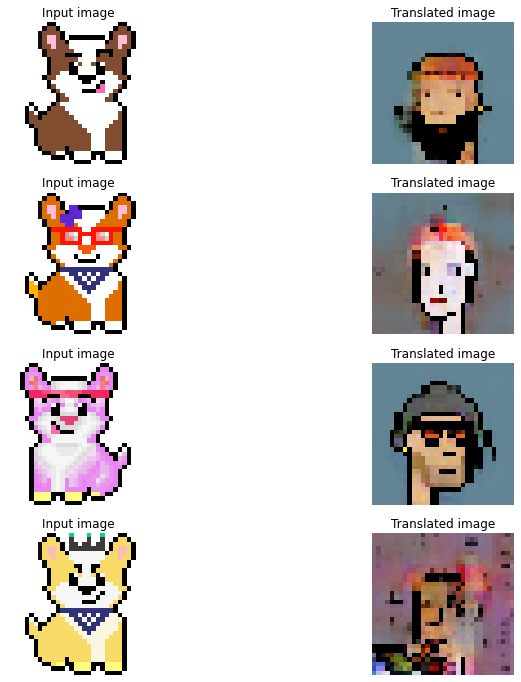

207/207 [==============================] - 115s 554ms/step - G_loss: 1.6796 - F_loss: 1.7587 - D_X_loss: 0.1526 - D_Y_loss: 0.1593
Epoch 172/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5948 - F_loss: 1.7249 - D_X_loss: 0.1486 - D_Y_loss: 0.1692

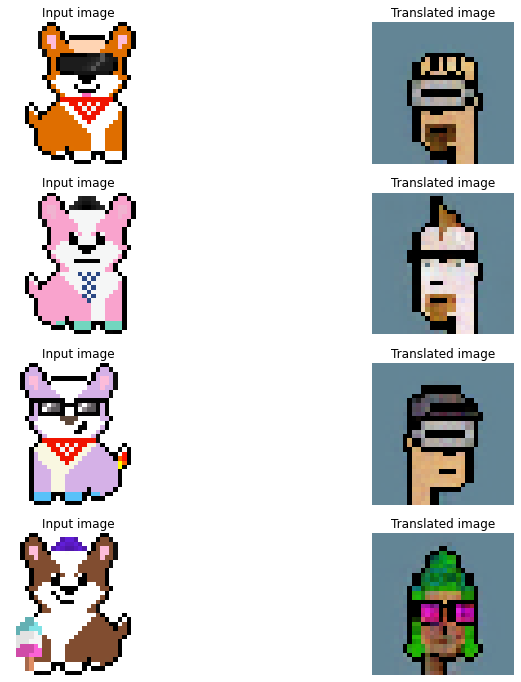

207/207 [==============================] - 115s 558ms/step - G_loss: 1.5936 - F_loss: 1.7278 - D_X_loss: 0.1487 - D_Y_loss: 0.1685
Epoch 173/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6454 - F_loss: 1.7332 - D_X_loss: 0.1415 - D_Y_loss: 0.1632

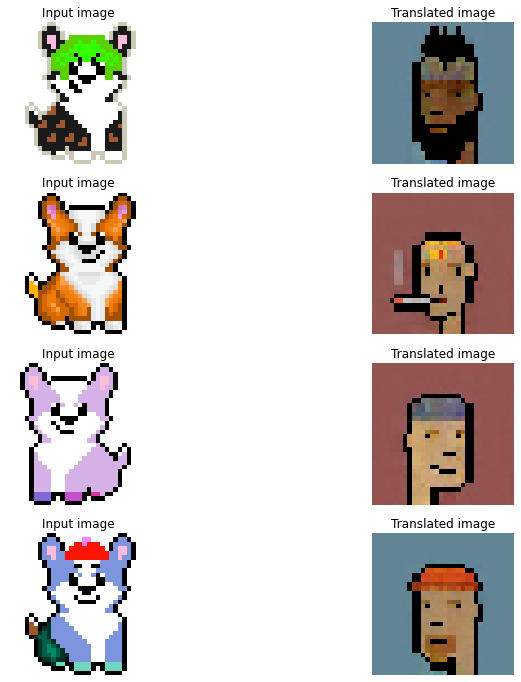

207/207 [==============================] - 121s 583ms/step - G_loss: 1.6419 - F_loss: 1.7398 - D_X_loss: 0.1417 - D_Y_loss: 0.1633
Epoch 174/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6543 - F_loss: 1.7378 - D_X_loss: 0.1479 - D_Y_loss: 0.1583

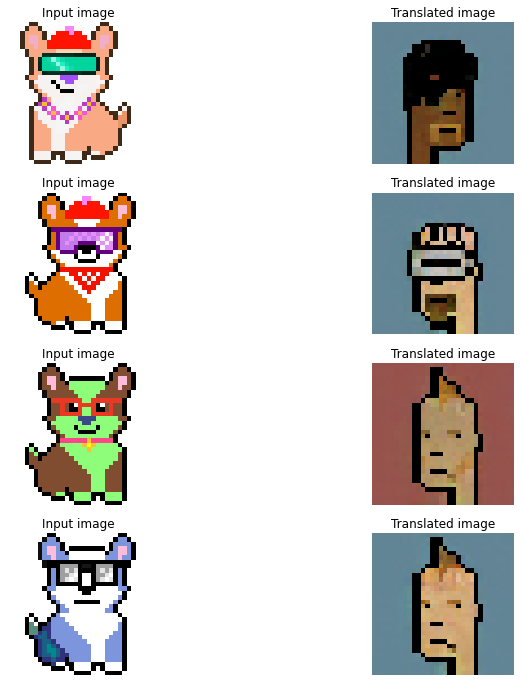

207/207 [==============================] - 120s 582ms/step - G_loss: 1.6493 - F_loss: 1.7386 - D_X_loss: 0.1476 - D_Y_loss: 0.1594
Epoch 175/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5246 - F_loss: 1.6748 - D_X_loss: 0.1641 - D_Y_loss: 0.1680

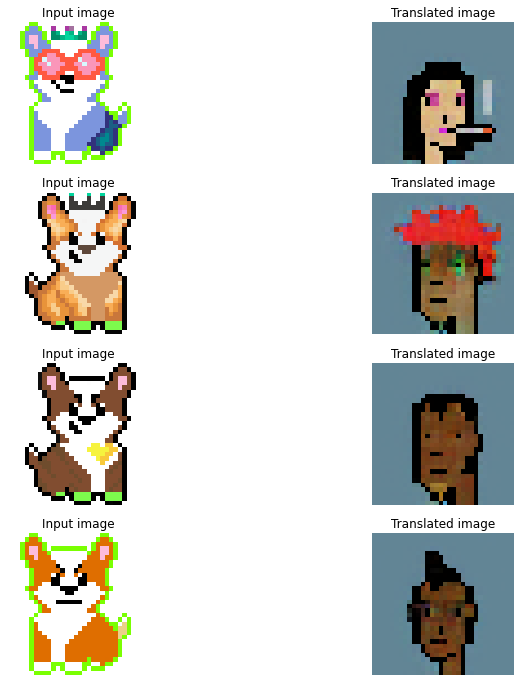

207/207 [==============================] - 120s 582ms/step - G_loss: 1.5261 - F_loss: 1.6714 - D_X_loss: 0.1643 - D_Y_loss: 0.1676
Epoch 176/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6168 - F_loss: 1.7241 - D_X_loss: 0.1442 - D_Y_loss: 0.1564

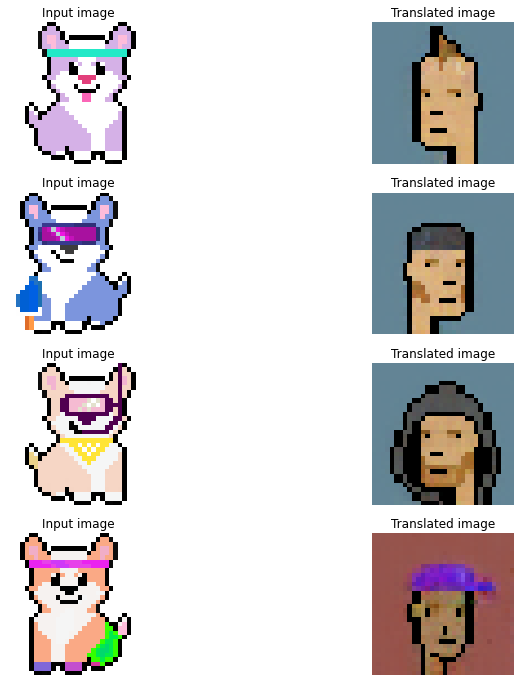

207/207 [==============================] - 120s 580ms/step - G_loss: 1.6171 - F_loss: 1.7308 - D_X_loss: 0.1436 - D_Y_loss: 0.1558
Epoch 177/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5908 - F_loss: 1.6952 - D_X_loss: 0.1490 - D_Y_loss: 0.1631

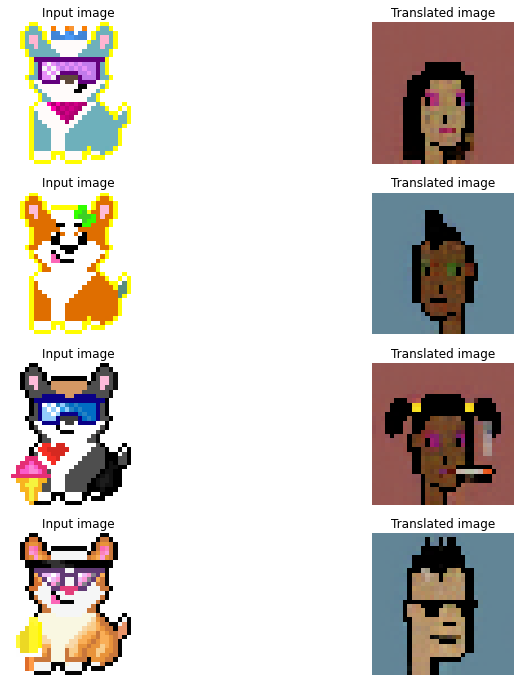

207/207 [==============================] - 120s 579ms/step - G_loss: 1.5869 - F_loss: 1.6980 - D_X_loss: 0.1490 - D_Y_loss: 0.1641
Epoch 178/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6483 - F_loss: 1.7019 - D_X_loss: 0.1414 - D_Y_loss: 0.1553

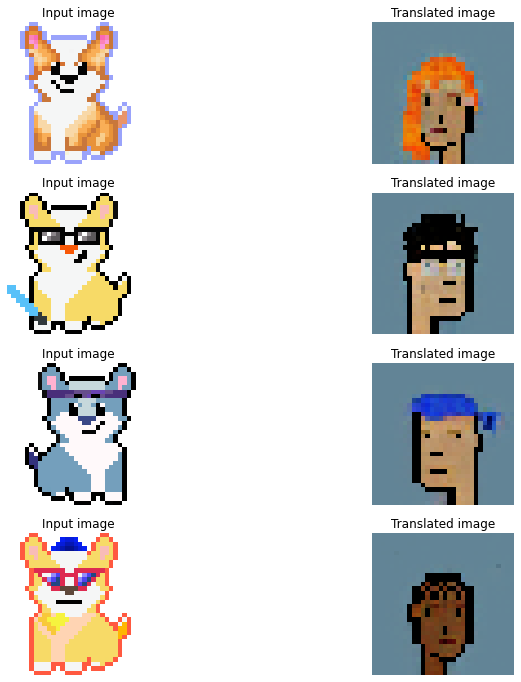

207/207 [==============================] - 120s 578ms/step - G_loss: 1.6621 - F_loss: 1.7029 - D_X_loss: 0.1408 - D_Y_loss: 0.1548
Epoch 179/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5587 - F_loss: 1.7307 - D_X_loss: 0.1466 - D_Y_loss: 0.1641

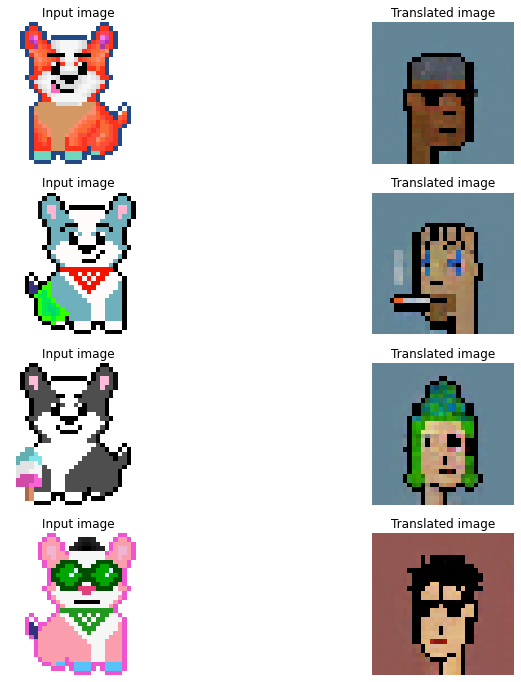

207/207 [==============================] - 119s 577ms/step - G_loss: 1.5568 - F_loss: 1.7365 - D_X_loss: 0.1461 - D_Y_loss: 0.1636
Epoch 180/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6068 - F_loss: 1.7279 - D_X_loss: 0.1470 - D_Y_loss: 0.1704

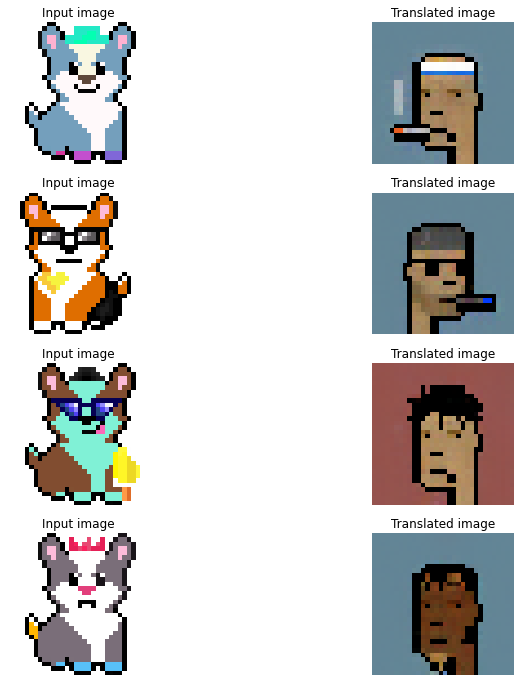

207/207 [==============================] - 119s 575ms/step - G_loss: 1.6055 - F_loss: 1.7248 - D_X_loss: 0.1470 - D_Y_loss: 0.1700
Epoch 181/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6285 - F_loss: 1.7581 - D_X_loss: 0.1466 - D_Y_loss: 0.1590

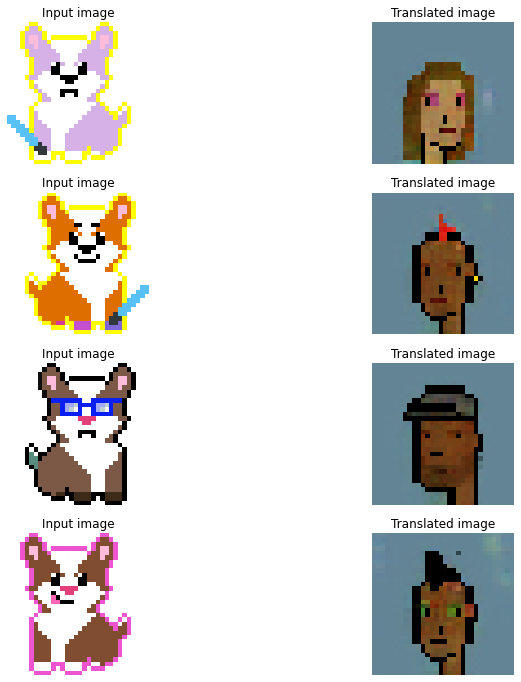

207/207 [==============================] - 119s 574ms/step - G_loss: 1.6417 - F_loss: 1.7582 - D_X_loss: 0.1460 - D_Y_loss: 0.1586
Epoch 182/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6018 - F_loss: 1.7094 - D_X_loss: 0.1516 - D_Y_loss: 0.1572

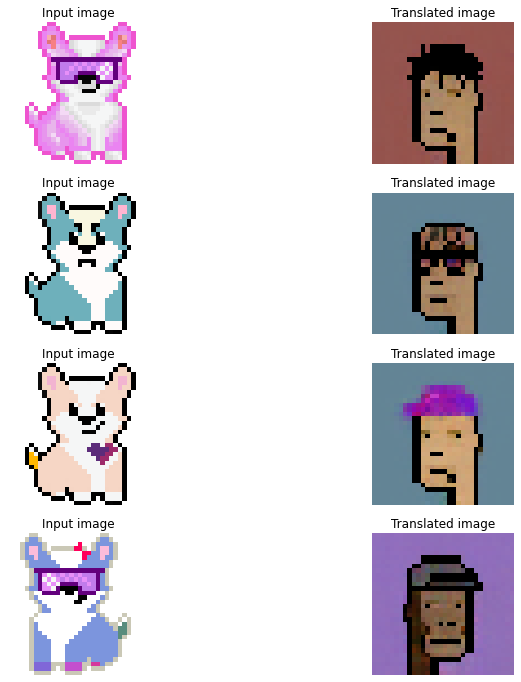

207/207 [==============================] - 119s 573ms/step - G_loss: 1.6004 - F_loss: 1.7167 - D_X_loss: 0.1511 - D_Y_loss: 0.1575
Epoch 183/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5233 - F_loss: 1.7470 - D_X_loss: 0.1466 - D_Y_loss: 0.1632

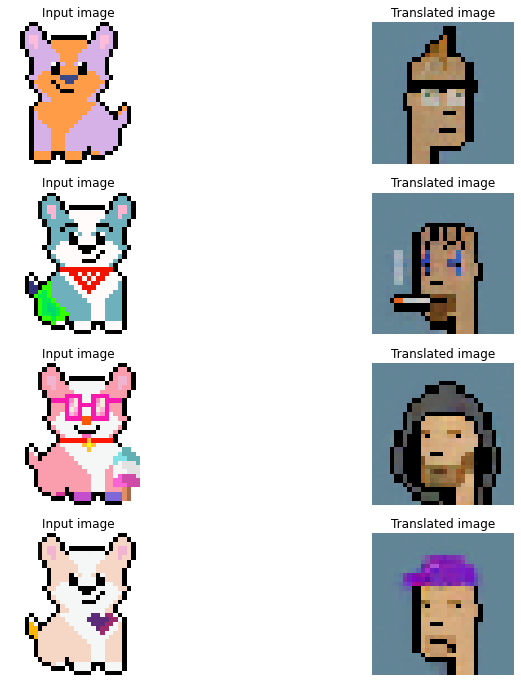

207/207 [==============================] - 118s 572ms/step - G_loss: 1.5200 - F_loss: 1.7460 - D_X_loss: 0.1482 - D_Y_loss: 0.1647
Epoch 184/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6726 - F_loss: 1.7560 - D_X_loss: 0.1442 - D_Y_loss: 0.1537

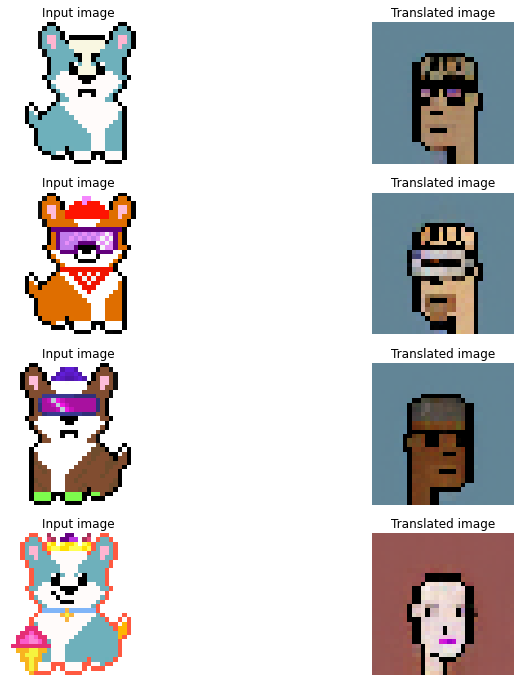

207/207 [==============================] - 118s 570ms/step - G_loss: 1.6737 - F_loss: 1.7578 - D_X_loss: 0.1436 - D_Y_loss: 0.1532
Epoch 185/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6787 - F_loss: 1.7171 - D_X_loss: 0.1405 - D_Y_loss: 0.1662

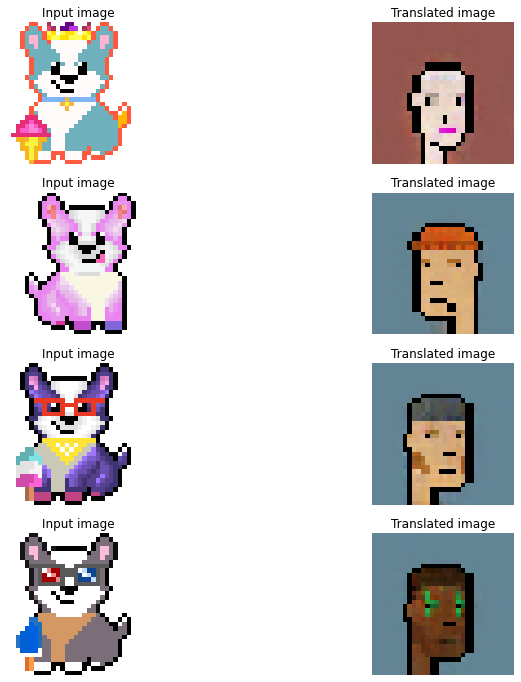

207/207 [==============================] - 118s 569ms/step - G_loss: 1.6787 - F_loss: 1.7165 - D_X_loss: 0.1404 - D_Y_loss: 0.1658
Epoch 186/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5355 - F_loss: 1.7650 - D_X_loss: 0.1431 - D_Y_loss: 0.1642

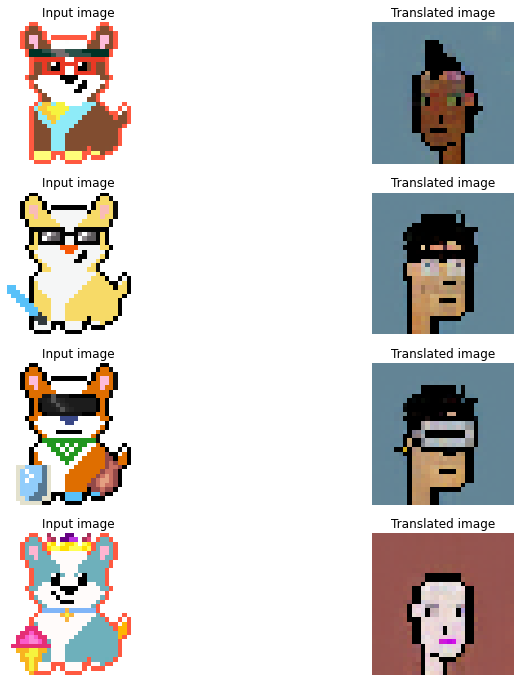

207/207 [==============================] - 117s 567ms/step - G_loss: 1.5304 - F_loss: 1.7676 - D_X_loss: 0.1434 - D_Y_loss: 0.1647
Epoch 187/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5481 - F_loss: 1.7288 - D_X_loss: 0.1480 - D_Y_loss: 0.1701

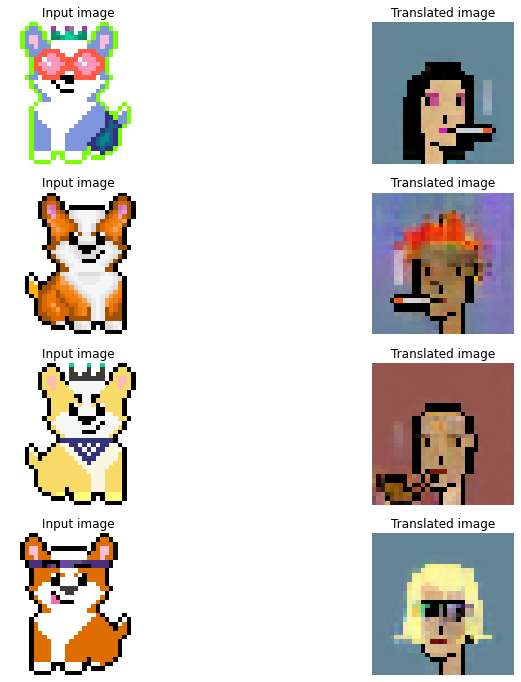

207/207 [==============================] - 117s 566ms/step - G_loss: 1.5513 - F_loss: 1.7289 - D_X_loss: 0.1489 - D_Y_loss: 0.1693
Epoch 188/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6061 - F_loss: 1.6659 - D_X_loss: 0.1476 - D_Y_loss: 0.1607

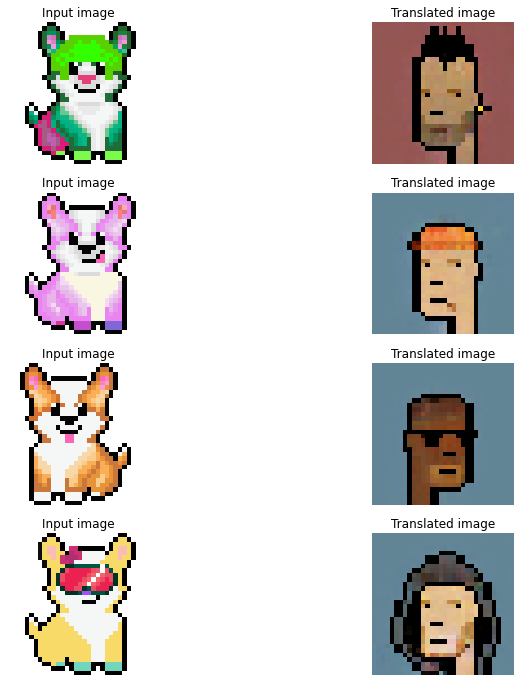

207/207 [==============================] - 117s 565ms/step - G_loss: 1.6070 - F_loss: 1.6671 - D_X_loss: 0.1484 - D_Y_loss: 0.1609
Epoch 189/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6937 - F_loss: 1.9041 - D_X_loss: 0.1433 - D_Y_loss: 0.1614

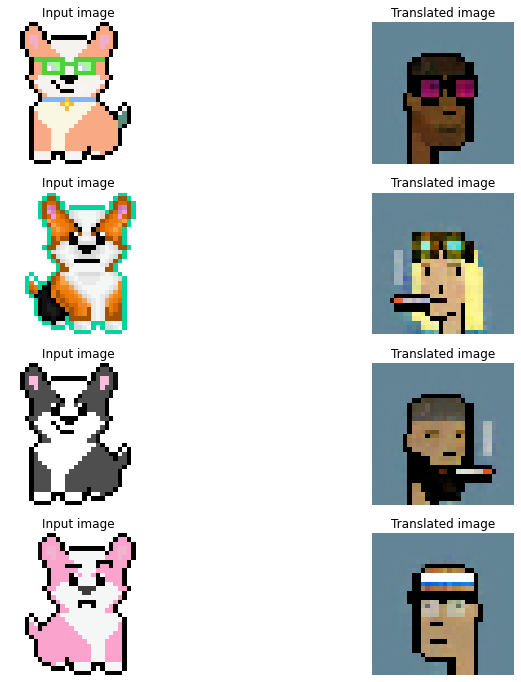

207/207 [==============================] - 117s 564ms/step - G_loss: 1.6897 - F_loss: 1.9002 - D_X_loss: 0.1430 - D_Y_loss: 0.1610
Epoch 190/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6030 - F_loss: 1.7660 - D_X_loss: 0.1414 - D_Y_loss: 0.1633

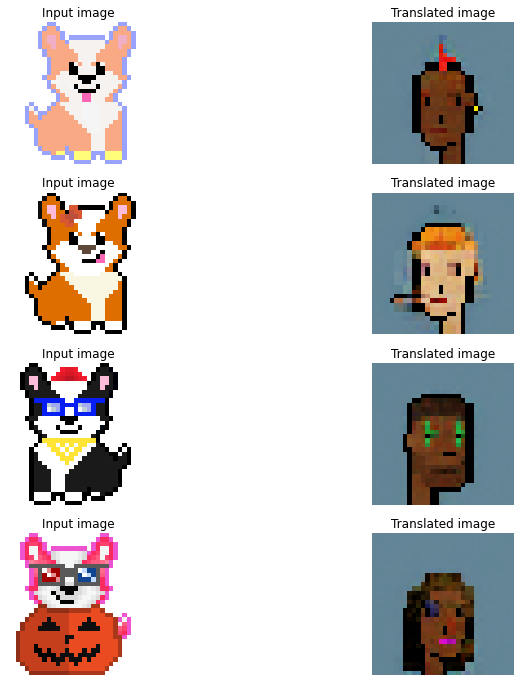

207/207 [==============================] - 116s 562ms/step - G_loss: 1.6052 - F_loss: 1.7672 - D_X_loss: 0.1407 - D_Y_loss: 0.1639
Epoch 191/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6486 - F_loss: 1.8103 - D_X_loss: 0.1361 - D_Y_loss: 0.1590

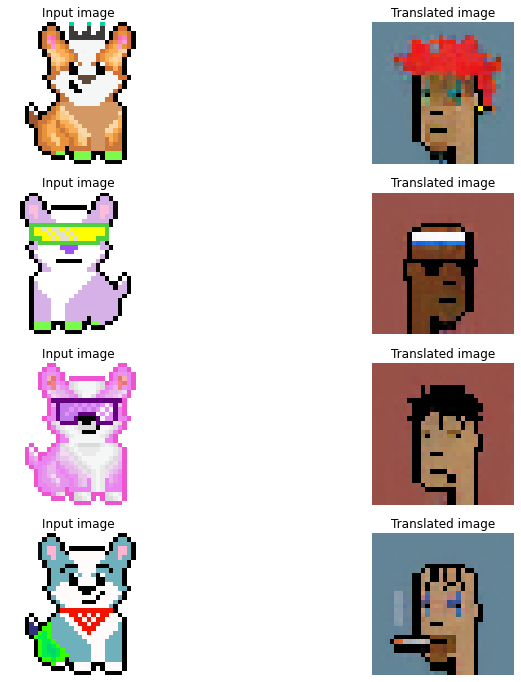

207/207 [==============================] - 116s 561ms/step - G_loss: 1.6564 - F_loss: 1.8164 - D_X_loss: 0.1354 - D_Y_loss: 0.1584
Epoch 192/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5931 - F_loss: 1.7603 - D_X_loss: 0.1474 - D_Y_loss: 0.1615

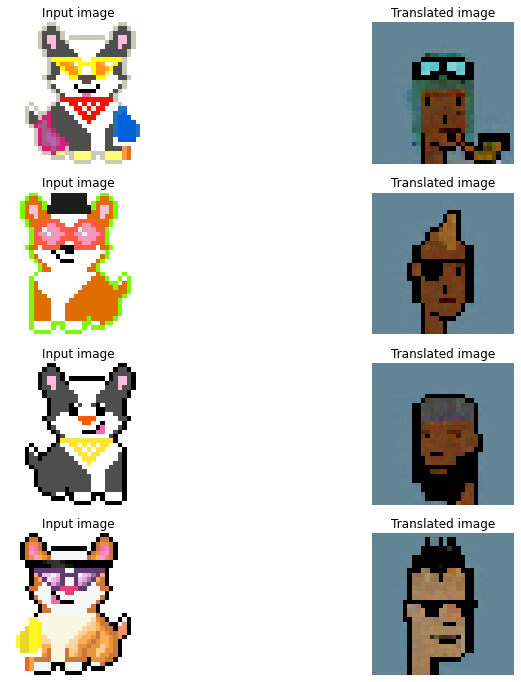

207/207 [==============================] - 115s 555ms/step - G_loss: 1.5906 - F_loss: 1.7549 - D_X_loss: 0.1492 - D_Y_loss: 0.1620
Epoch 193/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6829 - F_loss: 1.7576 - D_X_loss: 0.1391 - D_Y_loss: 0.1618

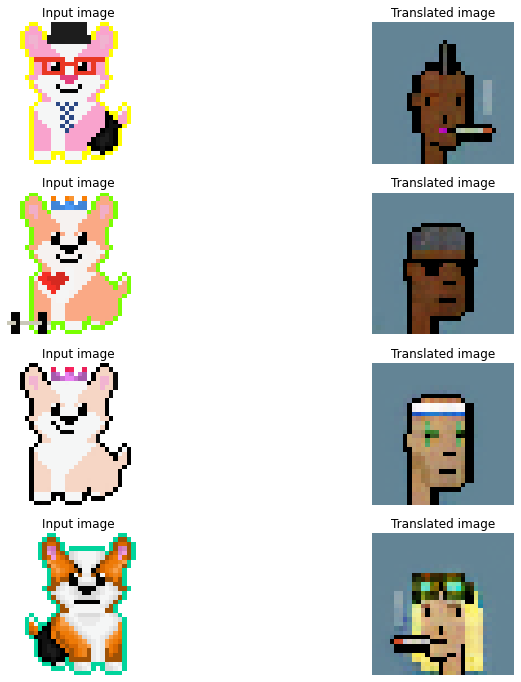

207/207 [==============================] - 115s 553ms/step - G_loss: 1.6774 - F_loss: 1.7571 - D_X_loss: 0.1394 - D_Y_loss: 0.1622
Epoch 194/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6396 - F_loss: 1.7719 - D_X_loss: 0.1487 - D_Y_loss: 0.1697

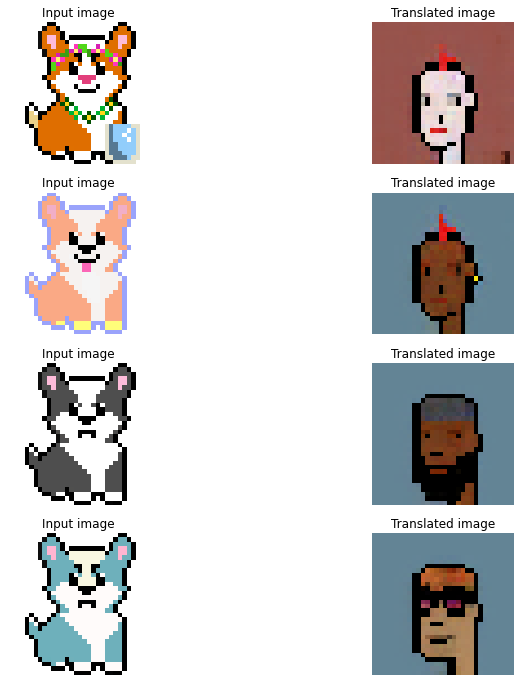

207/207 [==============================] - 114s 552ms/step - G_loss: 1.6489 - F_loss: 1.7709 - D_X_loss: 0.1501 - D_Y_loss: 0.1698
Epoch 195/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6838 - F_loss: 1.7106 - D_X_loss: 0.1487 - D_Y_loss: 0.1633

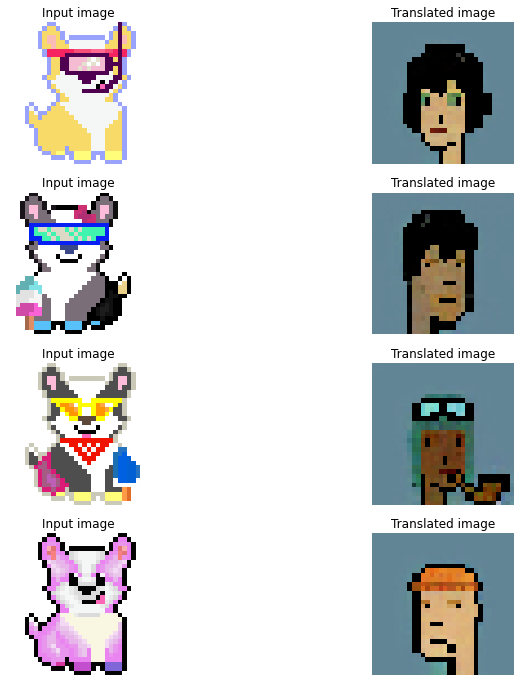

207/207 [==============================] - 114s 550ms/step - G_loss: 1.6844 - F_loss: 1.7077 - D_X_loss: 0.1491 - D_Y_loss: 0.1628
Epoch 196/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6261 - F_loss: 1.7271 - D_X_loss: 0.1490 - D_Y_loss: 0.1656

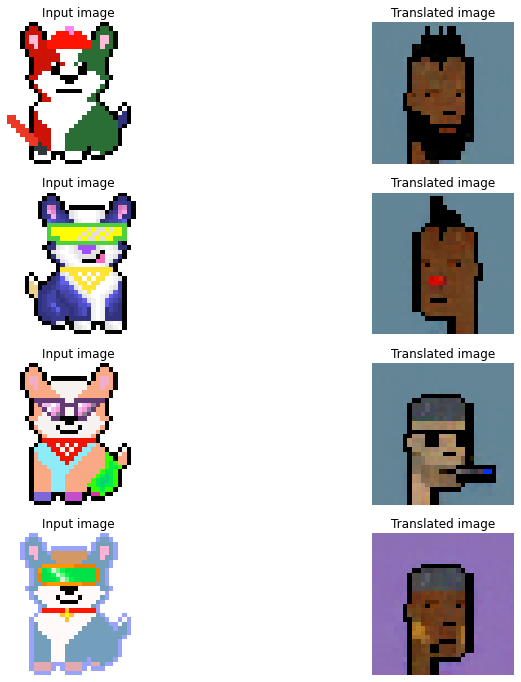

207/207 [==============================] - 114s 550ms/step - G_loss: 1.6219 - F_loss: 1.7233 - D_X_loss: 0.1491 - D_Y_loss: 0.1661
Epoch 197/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6285 - F_loss: 1.7228 - D_X_loss: 0.1448 - D_Y_loss: 0.1612

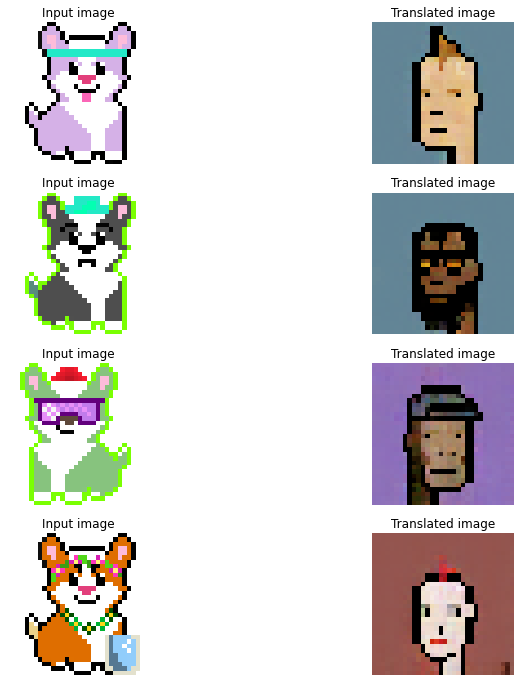

207/207 [==============================] - 114s 550ms/step - G_loss: 1.6282 - F_loss: 1.7195 - D_X_loss: 0.1457 - D_Y_loss: 0.1606
Epoch 198/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6152 - F_loss: 1.6598 - D_X_loss: 0.1459 - D_Y_loss: 0.1621

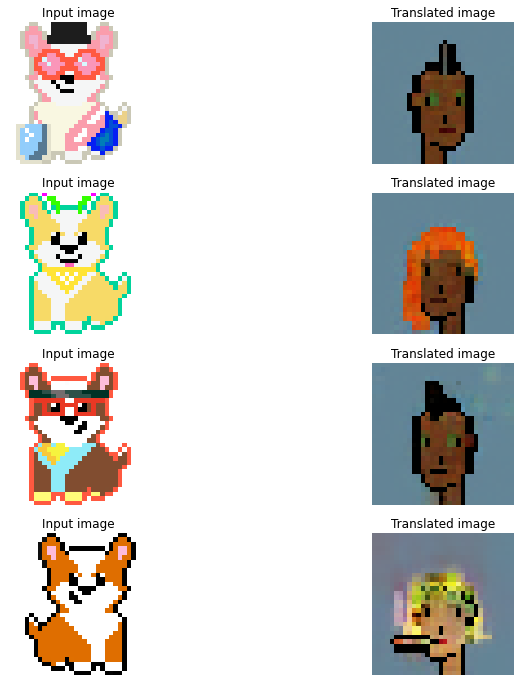

207/207 [==============================] - 115s 554ms/step - G_loss: 1.6096 - F_loss: 1.6572 - D_X_loss: 0.1456 - D_Y_loss: 0.1636
Epoch 199/200
207/207 [==============================] - ETA: 0s - G_loss: 1.6384 - F_loss: 1.6620 - D_X_loss: 0.1395 - D_Y_loss: 0.1631

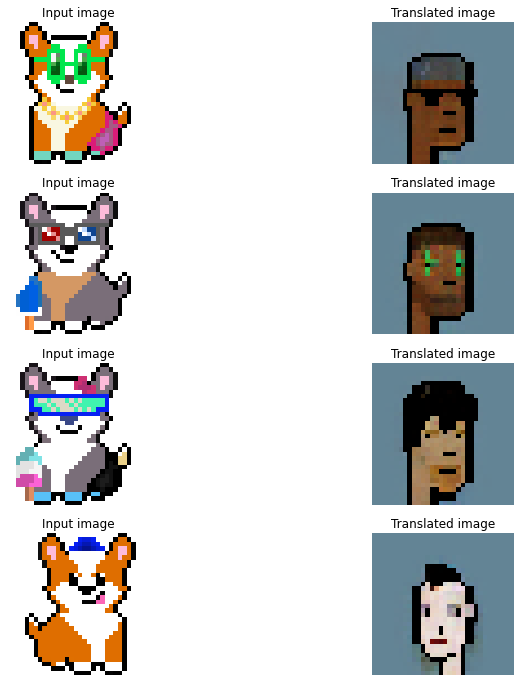

207/207 [==============================] - 114s 553ms/step - G_loss: 1.6481 - F_loss: 1.6601 - D_X_loss: 0.1397 - D_Y_loss: 0.1630
Epoch 200/200
207/207 [==============================] - ETA: 0s - G_loss: 1.5052 - F_loss: 1.6281 - D_X_loss: 0.1467 - D_Y_loss: 0.1654

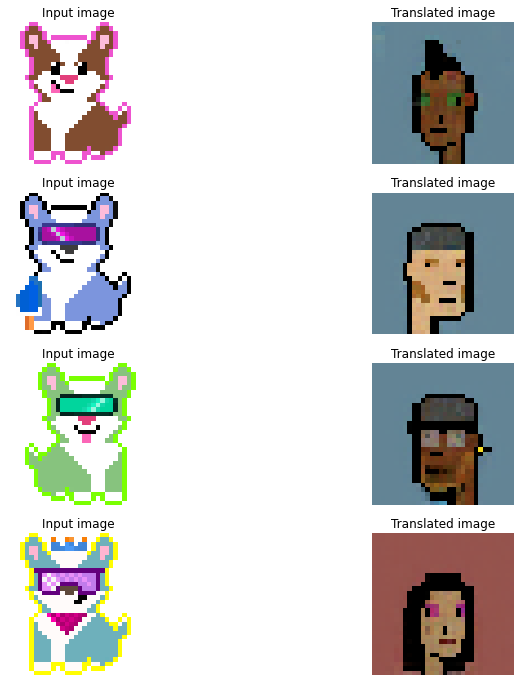

207/207 [==============================] - 115s 557ms/step - G_loss: 1.5129 - F_loss: 1.6320 - D_X_loss: 0.1464 - D_Y_loss: 0.1649


In [98]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_ds2, train_ds)),
    epochs=200,
    callbacks=[plotter],
)